In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from numpy import concatenate
from math import sqrt
from statistics import mean
import random
import matplotlib.pyplot as plt

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv('/Users/alexellard/Downloads/scenarios_data.csv', header=0, index_col=0)
df

,reservoir_demand,node_1_demand,node_2_demand,node_3_demand,node_4_demand,node_5_demand,node_6_demand,node_7_demand,node_8_demand,node_9_demand,...,link_23_flow,link_24_flow,link_25_flow,link_26_flow,link_27_flow,link_28_flow,link_29_flow,link_30_flow,link_31_flow,link_32_flow
Timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,-3348.0,154.8,169.2,18.0,118.8,169.2,234.0,86.4,82.8,104.4,...,439.2,-205.2,-75.6,-18.0,118.8,68.4,7.2,-54.0,75.6,212.4
2017-01-01 00:30:00,-2959.2,136.8,147.6,18.0,108.0,144.0,237.6,79.2,75.6,90.0,...,392.4,-187.2,-72.0,-21.6,108.0,61.2,3.6,-54.0,72.0,183.6
2017-01-01 01:00:00,-2692.8,129.6,126.0,14.4,104.4,133.2,205.2,72.0,72.0,90.0,...,349.2,-176.4,-64.8,-18.0,93.6,50.4,3.6,-39.6,54.0,151.2
2017-01-01 01:30:00,-2379.6,104.4,100.8,10.8,86.4,122.4,180.0,68.4,57.6,82.8,...,316.8,-158.4,-54.0,-10.8,79.2,46.8,7.2,-32.4,50.4,140.4
2017-01-01 02:00:00,-2228.4,104.4,104.4,10.8,79.2,122.4,183.6,68.4,54.0,75.6,...,277.2,-144.0,-57.6,-18.0,72.0,39.6,7.2,-32.4,43.2,118.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 21:30:00,-5306.4,205.2,208.8,39.6,183.6,284.4,316.8,176.4,133.2,129.6,...,604.8,-259.2,32.4,115.2,169.2,100.8,10.8,-100.8,122.4,309.6
2017-12-31 22:00:00,-4910.4,208.8,183.6,39.6,154.8,252.0,295.2,165.6,133.2,133.2,...,565.2,-241.2,21.6,100.8,154.8,86.4,18.0,-75.6,100.8,288.0
2017-12-31 22:30:00,-4683.6,187.2,183.6,36.0,147.6,230.4,320.4,147.6,118.8,126.0,...,529.2,-226.8,21.6,100.8,147.6,86.4,14.4,-86.4,108.0,266.4


In [3]:
#Run pressure node 29

MAE_average = []
RMSE_average = []
R2_average = []
maximum_MAE = []
sensors_covered = []
n_columns_to_drop = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]
for n in n_columns_to_drop:
    MAE = []
    RMSE = []
    R2 = []
    for run in range(1,11):
        Y = df[df.columns[61]]
        X = df.drop(columns=['node_29_pressure'])
        X['node_29_pressure'] = Y
        columns = []
        columns_to_drop = random.sample(list(X.columns), n)
        # Drop the selected columns from the dataframe
        if X.columns[-1] in columns_to_drop:
            columns_to_drop.remove(X.columns[-1])
        X.drop(columns_to_drop, axis=1, inplace=True)
        columns.append(columns_to_drop)
        print(columns)
        print('starting df shape:', X.shape)
        print(f'This is training run {run} and has the shape: ', X.shape)
        print(f'The value of dropped columns is {n}')

        # split into train and test sets
        values = X.values
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled = scaler.fit_transform(values)
        train, test = train_test_split(scaled, test_size=0.2, random_state=0)

        # split into input and outputs
        train_X, train_y = train[:, :-1], train[:, -1]
        test_X, test_y = test[:, :-1], test[:, -1]

        #define model
        model = xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.9,
            colsample_bytree=0.8,
            random_state=42
        )

        # fit the model on the training data
        model.fit(train_X, train_y)

        # make predictions on the test data
        y_pred = model.predict(test_X)

        test_y = test_y.reshape((len(test_y), 1))
        print('test y shape :', test_y.shape)
        inv_test_y = concatenate((test_y, test_X[:, -X.shape[1]:]), axis=1)
        print('Inv y shape :', inv_test_y.shape)
        test_y_inverse = scaler.inverse_transform(inv_test_y)
        test_y_inverse = test_y_inverse[:,0]
        
        y_pred = y_pred.reshape((len(y_pred), 1))
        print('y pred shape :', y_pred.shape)
        inv_y_pred = concatenate((y_pred, test_X[:, -X.shape[1]:]), axis=1)
        print('inv y pred :', inv_y_pred.shape)
        y_pred_inverse = scaler.inverse_transform(inv_y_pred)
        y_pred_inverse = y_pred_inverse[:,0]

        # evaluate scaled errors
        mae_inverse = mean_absolute_error(test_y_inverse, y_pred_inverse)
        MAE.append(mae_inverse)
        print(f'Run {run} Mean Absolute Error:', mae_inverse)
        rmse_inverse = sqrt(mean_squared_error(test_y_inverse, y_pred_inverse))
        RMSE.append(rmse_inverse)
        print('RMSE: %.3f' % rmse_inverse)
        r2_inverse = r2_score(test_y_inverse, y_pred_inverse)
        R2.append(r2_inverse)
        print('R^2: %.3f' % r2_inverse)
    percentage_list = round(X.shape[1] / 96 * 100)
    sensors_covered.append(percentage_list)
    MAE_mean = mean(MAE)
    RMSE_mean = mean(RMSE)
    R2_mean = mean(R2)
    max_MAE = max(MAE)
    maximum_MAE.append(max_MAE)
    MAE_average.append(MAE_mean)
    RMSE_average.append(RMSE_mean)
    R2_average.append(R2_mean)
print('Length MAE_average: ', len(MAE_average))
print('Length sensors_covered: ', len(sensors_covered))

[[]]
starting df shape: (87600, 96)
This is training run 1 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 1 Mean Absolute Error: 2.7127859912848926
RMSE: 3.887
R^2: 1.000
[[]]
starting df shape: (87600, 96)
This is training run 2 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 2 Mean Absolute Error: 2.7127859912848926
RMSE: 3.887
R^2: 1.000
[[]]
starting df shape: (87600, 96)
This is training run 3 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 3 Mean Absolute Error: 2.7127859912848926
RMSE: 3.887
R^2: 1.000
[[]]
starting df shape: (87600, 96)
This is training run 4 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 4 Mean Absolute Error: 2.7127859912848926
RMSE: 3.887
R^2: 1.000
[[]]
starting df shape: (87600, 96)
This is training run 5 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 5 Mean Absolute Error: 2.7127859912848926
RMSE: 3.887
R^2: 1.000
[[]]
starting df shape: (87600, 96)
This is training run 6 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 6 Mean Absolute Error: 2.7127859912848926
RMSE: 3.887
R^2: 1.000
[[]]
starting df shape: (87600, 96)
This is training run 7 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 7 Mean Absolute Error: 2.7127859912848926
RMSE: 3.887
R^2: 1.000
[[]]
starting df shape: (87600, 96)
This is training run 8 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 8 Mean Absolute Error: 2.7127859912848926
RMSE: 3.887
R^2: 1.000
[[]]
starting df shape: (87600, 96)
This is training run 9 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 9 Mean Absolute Error: 2.7127859912848926
RMSE: 3.887
R^2: 1.000
[[]]
starting df shape: (87600, 96)
This is training run 10 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 10 Mean Absolute Error: 2.7127859912848926
RMSE: 3.887
R^2: 1.000
[['node_22_pressure', 'link_11_flow', 'link_18_flow', 'link_2_flow', 'node_19_demand']]
starting df shape: (87600, 91)
This is training run 1 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 1 Mean Absolute Error: 2.7921532760518244
RMSE: 3.984
R^2: 1.000
[['node_10_pressure', 'node_15_demand', 'node_12_pressure', 'link_1_flow', 'node_19_demand']]
starting df shape: (87600, 91)
This is training run 2 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 2 Mean Absolute Error: 3.1753967429665058
RMSE: 4.526
R^2: 1.000
[['node_12_pressure', 'node_7_pressure', 'node_2_pressure', 'node_22_demand', 'node_23_pressure']]
starting df shape: (87600, 91)
This is training run 3 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 3 Mean Absolute Error: 2.768296877587007
RMSE: 3.927
R^2: 1.000
[['node_15_pressure', 'node_5_demand', 'node_18_demand', 'node_18_pressure', 'node_23_demand']]
starting df shape: (87600, 91)
This is training run 4 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 4 Mean Absolute Error: 2.7593472445094123
RMSE: 3.977
R^2: 1.000
[['node_8_pressure', 'node_30_demand', 'node_21_pressure', 'node_24_demand', 'node_24_pressure']]
starting df shape: (87600, 91)
This is training run 5 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 5 Mean Absolute Error: 2.7738088358853914
RMSE: 4.005
R^2: 1.000
[['node_9_pressure', 'link_7_flow', 'link_32_flow', 'link_18_flow', 'link_14_flow']]
starting df shape: (87600, 91)
This is training run 6 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 6 Mean Absolute Error: 2.894858025145307
RMSE: 4.189
R^2: 1.000
[['node_3_pressure', 'node_21_pressure', 'node_3_demand', 'node_30_demand', 'node_12_pressure']]
starting df shape: (87600, 91)
This is training run 7 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 7 Mean Absolute Error: 2.8002486541777953
RMSE: 4.021
R^2: 1.000
[['link_32_flow', 'node_8_pressure', 'node_9_demand', 'link_26_flow', 'link_9_flow']]
starting df shape: (87600, 91)
This is training run 8 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 8 Mean Absolute Error: 2.787499130299358
RMSE: 3.956
R^2: 1.000
[['node_18_demand', 'node_13_demand', 'link_10_flow', 'node_3_pressure', 'node_16_demand']]
starting df shape: (87600, 91)
This is training run 9 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 9 Mean Absolute Error: 3.1759397057530157
RMSE: 4.527
R^2: 1.000
[['link_3_flow', 'link_22_flow', 'node_9_pressure', 'link_4_flow', 'node_8_demand']]
starting df shape: (87600, 91)
This is training run 10 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 10 Mean Absolute Error: 2.788719189564047
RMSE: 3.956
R^2: 1.000
[['link_13_flow', 'node_5_pressure', 'link_2_flow', 'node_6_demand', 'node_11_pressure', 'reservoir_pressure', 'node_21_pressure', 'node_30_demand', 'link_6_flow', 'node_1_demand']]
starting df shape: (87600, 86)
This is training run 1 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 1 Mean Absolute Error: 3.185435261095075
RMSE: 4.644
R^2: 1.000
[['node_19_pressure', 'node_25_demand', 'node_18_demand', 'node_7_pressure', 'node_11_demand', 'node_10_pressure', 'link_6_flow', 'node_17_pressure', 'link_2_flow', 'node_13_pressure']]
starting df shape: (87600, 86)
This is training run 2 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 2 Mean Absolute Error: 3.057926094817257
RMSE: 4.393
R^2: 1.000
[['node_14_demand', 'node_15_demand', 'node_30_pressure', 'link_1_flow', 'node_16_pressure', 'node_4_demand', 'link_19_flow', 'link_9_flow', 'node_1_pressure', 'node_24_demand']]
starting df shape: (87600, 86)
This is training run 3 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 3 Mean Absolute Error: 4.469289679476055
RMSE: 6.107
R^2: 1.000
[['node_19_pressure', 'node_1_pressure', 'link_20_flow', 'node_18_pressure', 'node_17_demand', 'link_31_flow', 'link_22_flow', 'link_4_flow', 'node_28_pressure', 'node_11_pressure']]
starting df shape: (87600, 86)
This is training run 4 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 4 Mean Absolute Error: 3.5113958150860327
RMSE: 4.946
R^2: 1.000
[['node_18_demand', 'link_16_flow', 'node_5_demand', 'node_22_pressure', 'link_25_flow', 'link_2_flow', 'node_26_demand', 'link_19_flow', 'node_31_pressure', 'node_2_pressure']]
starting df shape: (87600, 86)
This is training run 5 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 5 Mean Absolute Error: 3.437470387202233
RMSE: 4.827
R^2: 1.000
[['link_29_flow', 'node_5_pressure', 'link_5_flow', 'node_31_pressure', 'node_20_pressure', 'node_10_pressure', 'reservoir_pressure', 'link_7_flow', 'link_18_flow', 'node_21_demand']]
starting df shape: (87600, 86)
This is training run 6 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 6 Mean Absolute Error: 3.491150422920081
RMSE: 4.858
R^2: 1.000
[['link_2_flow', 'node_20_demand', 'node_5_pressure', 'link_10_flow', 'node_4_demand', 'node_12_pressure', 'node_3_pressure', 'node_31_demand', 'node_1_demand', 'node_15_pressure']]
starting df shape: (87600, 86)
This is training run 7 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 7 Mean Absolute Error: 3.0079009802575283
RMSE: 4.215
R^2: 1.000
[['link_8_flow', 'node_11_demand', 'link_32_flow', 'node_21_demand', 'node_16_demand', 'link_24_flow', 'link_16_flow', 'link_6_flow', 'node_12_demand', 'link_20_flow']]
starting df shape: (87600, 86)
This is training run 8 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 8 Mean Absolute Error: 3.0518404215017023
RMSE: 4.301
R^2: 1.000
[['link_5_flow', 'node_24_pressure', 'node_31_demand', 'node_22_pressure', 'reservoir_demand', 'node_21_pressure', 'link_28_flow', 'node_8_demand', 'node_19_pressure']]
starting df shape: (87600, 87)
This is training run 9 and has the shape:  (87600, 87)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 87)
y pred shape : (17520, 1)
inv y pred : (17520, 87)
Run 9 Mean Absolute Error: 0.18412297909115194
RMSE: 0.275
R^2: 1.000
[['node_5_demand', 'node_12_pressure', 'node_6_demand', 'node_14_demand', 'node_24_demand', 'node_21_pressure', 'node_6_pressure', 'reservoir_demand', 'node_3_demand', 'link_4_flow']]
starting df shape: (87600, 86)
This is training run 10 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 10 Mean Absolute Error: 0.16871658951908397
RMSE: 0.246
R^2: 1.000
[['node_4_demand', 'node_30_demand', 'node_8_pressure', 'link_26_flow', 'link_4_flow', 'node_28_demand', 'link_30_flow', 'node_12_pressure', 'node_22_demand', 'node_14_demand', 'node_15_pressure', 'link_10_flow', 'node_26_pressure', 'node_27_demand', 'node_2_pressure']]
starting df shape: (87600, 81)
This is training run 1 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 1 Mean Absolute Error: 2.869828157390619
RMSE: 4.058
R^2: 1.000
[['node_7_pressure', 'node_9_demand', 'node_1_demand', 'link_3_flow', 'link_1_flow', 'node_26_demand', 'node_26_pressure', 'node_20_pressure', 'node_19_demand', 'link_32_flow', 'link_17_flow', 'node_27_demand', 'link_15_flow', 'node_1_pressure', 'node_14_demand']]
starting df shape: (87600, 81)
This is training run 2 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 2 Mean Absolute Error: 2.873817315311664
RMSE: 4.025
R^2: 1.000
[['node_7_pressure', 'link_10_flow', 'link_3_flow', 'node_28_demand', 'node_6_pressure', 'node_24_pressure', 'node_22_pressure', 'node_5_demand', 'node_21_demand', 'link_30_flow', 'node_13_pressure', 'node_18_demand', 'node_1_pressure', 'node_16_pressure', 'link_14_flow']]
starting df shape: (87600, 81)
This is training run 3 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 3 Mean Absolute Error: 2.892025644873203
RMSE: 4.069
R^2: 1.000
[['node_15_demand', 'node_18_pressure', 'link_18_flow', 'node_24_pressure', 'link_20_flow', 'link_22_flow', 'link_26_flow', 'node_20_pressure', 'node_27_demand', 'node_20_demand', 'node_28_pressure', 'link_27_flow', 'link_3_flow', 'node_22_demand', 'node_6_demand']]
starting df shape: (87600, 81)
This is training run 4 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 4 Mean Absolute Error: 3.2833696689543146
RMSE: 4.603
R^2: 1.000
[['link_21_flow', 'link_19_flow', 'link_4_flow', 'link_6_flow', 'link_14_flow', 'node_9_demand', 'node_13_pressure', 'link_17_flow', 'link_12_flow', 'node_19_demand', 'link_18_flow', 'node_10_pressure', 'node_13_demand', 'node_15_pressure', 'reservoir_demand']]
starting df shape: (87600, 81)
This is training run 5 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 5 Mean Absolute Error: 0.17394462474798297
RMSE: 0.258
R^2: 1.000
[['node_20_pressure', 'node_7_demand', 'link_15_flow', 'link_10_flow', 'node_16_demand', 'node_15_demand', 'link_31_flow', 'link_28_flow', 'node_1_demand', 'link_4_flow', 'node_5_demand', 'link_22_flow', 'node_2_demand', 'node_30_demand', 'node_11_demand']]
starting df shape: (87600, 81)
This is training run 6 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 6 Mean Absolute Error: 3.017056978059459
RMSE: 4.275
R^2: 1.000
[['node_7_pressure', 'link_23_flow', 'link_18_flow', 'node_1_pressure', 'node_2_demand', 'link_9_flow', 'node_15_demand', 'node_16_demand', 'node_27_pressure', 'link_25_flow', 'node_28_demand', 'node_3_pressure', 'node_24_pressure', 'link_30_flow', 'node_8_pressure']]
starting df shape: (87600, 81)
This is training run 7 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 7 Mean Absolute Error: 2.9193023161223253
RMSE: 4.254
R^2: 1.000
[['node_12_pressure', 'node_1_pressure', 'node_8_pressure', 'node_30_pressure', 'node_5_pressure', 'node_4_demand', 'node_8_demand', 'link_30_flow', 'node_3_demand', 'node_17_pressure', 'link_23_flow', 'link_27_flow', 'link_28_flow', 'link_1_flow', 'link_7_flow']]
starting df shape: (87600, 81)
This is training run 8 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 8 Mean Absolute Error: 4.227797711919562
RMSE: 5.854
R^2: 1.000
[['node_25_pressure', 'node_9_demand', 'link_6_flow', 'link_9_flow', 'node_28_pressure', 'link_10_flow', 'node_6_demand', 'node_26_demand', 'node_6_pressure', 'node_11_demand', 'link_15_flow', 'link_21_flow', 'link_24_flow', 'node_29_demand', 'node_1_pressure']]
starting df shape: (87600, 81)
This is training run 9 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 9 Mean Absolute Error: 3.27864678585832
RMSE: 4.711
R^2: 1.000
[['node_16_pressure', 'link_29_flow', 'node_15_demand', 'link_25_flow', 'node_9_pressure', 'node_5_demand', 'link_9_flow', 'link_28_flow', 'node_17_demand', 'node_13_demand', 'node_10_pressure', 'link_8_flow', 'node_31_demand', 'link_1_flow', 'link_30_flow']]
starting df shape: (87600, 81)
This is training run 10 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 10 Mean Absolute Error: 2.985736012380246
RMSE: 4.302
R^2: 1.000
[['link_20_flow', 'link_6_flow', 'node_22_pressure', 'node_22_demand', 'link_30_flow', 'node_21_pressure', 'link_26_flow', 'link_3_flow', 'node_6_demand', 'link_12_flow', 'node_4_pressure', 'node_15_demand', 'node_7_pressure', 'node_8_pressure', 'link_7_flow', 'link_1_flow', 'link_25_flow', 'node_25_demand', 'node_26_pressure', 'node_2_pressure']]
starting df shape: (87600, 76)
This is training run 1 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 1 Mean Absolute Error: 2.6521893535574237
RMSE: 3.818
R^2: 1.000
[['link_5_flow', 'node_24_demand', 'link_20_flow', 'link_30_flow', 'node_5_pressure', 'node_11_pressure', 'node_24_pressure', 'link_31_flow', 'node_29_demand', 'node_13_demand', 'link_23_flow', 'link_13_flow', 'node_12_pressure', 'node_14_demand', 'node_18_pressure', 'node_12_demand', 'node_17_pressure', 'link_10_flow', 'link_16_flow', 'link_25_flow']]
starting df shape: (87600, 76)
This is training run 2 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 2 Mean Absolute Error: 2.955573173029768
RMSE: 4.240
R^2: 1.000
[['node_5_demand', 'node_8_demand', 'node_11_demand', 'link_32_flow', 'node_28_demand', 'link_14_flow', 'node_18_demand', 'reservoir_demand', 'link_19_flow', 'node_19_demand', 'node_30_pressure', 'link_24_flow', 'node_12_demand', 'node_24_pressure', 'node_7_pressure', 'node_27_demand', 'node_21_pressure', 'node_20_pressure', 'node_26_pressure', 'node_31_pressure']]
starting df shape: (87600, 76)
This is training run 3 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 3 Mean Absolute Error: 0.352268963817256
RMSE: 0.497
R^2: 1.000
[['node_25_pressure', 'node_17_pressure', 'node_14_pressure', 'node_18_pressure', 'node_28_pressure', 'node_17_demand', 'link_9_flow', 'node_21_demand', 'node_1_demand', 'node_16_demand', 'link_17_flow', 'node_14_demand', 'link_31_flow', 'link_6_flow', 'node_2_demand', 'node_6_demand', 'link_7_flow', 'node_26_demand', 'node_15_demand']]
starting df shape: (87600, 77)
This is training run 4 and has the shape:  (87600, 77)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 77)
y pred shape : (17520, 1)
inv y pred : (17520, 77)
Run 4 Mean Absolute Error: 3.2806253358818958
RMSE: 4.673
R^2: 1.000
[['node_15_pressure', 'node_2_demand', 'node_7_pressure', 'link_24_flow', 'link_30_flow', 'node_12_demand', 'link_14_flow', 'link_8_flow', 'link_32_flow', 'node_6_pressure', 'node_24_pressure', 'node_20_demand', 'node_2_pressure', 'node_14_pressure', 'node_1_pressure', 'node_8_pressure', 'node_18_pressure', 'reservoir_pressure', 'link_22_flow', 'node_11_demand']]
starting df shape: (87600, 76)
This is training run 5 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 5 Mean Absolute Error: 3.074431700133986
RMSE: 4.393
R^2: 1.000
[['node_1_demand', 'node_16_demand', 'node_16_pressure', 'node_2_demand', 'link_9_flow', 'link_11_flow', 'node_4_demand', 'node_28_pressure', 'node_9_demand', 'node_25_demand', 'link_6_flow', 'link_32_flow', 'link_1_flow', 'node_12_pressure', 'node_8_demand', 'node_27_pressure', 'link_21_flow', 'node_3_pressure', 'link_28_flow', 'link_24_flow']]
starting df shape: (87600, 76)
This is training run 6 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 6 Mean Absolute Error: 3.836423871225726
RMSE: 5.343
R^2: 1.000
[['node_5_pressure', 'node_24_demand', 'node_31_demand', 'node_9_demand', 'node_14_demand', 'link_13_flow', 'node_13_demand', 'link_32_flow', 'node_7_pressure', 'node_28_pressure', 'node_26_pressure', 'node_4_demand', 'node_20_pressure', 'node_14_pressure', 'link_4_flow', 'node_29_demand', 'node_13_pressure', 'link_9_flow', 'reservoir_demand', 'link_21_flow']]
starting df shape: (87600, 76)
This is training run 7 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 7 Mean Absolute Error: 0.2242168588253714
RMSE: 0.315
R^2: 1.000
[['link_16_flow', 'node_23_demand', 'node_9_pressure', 'node_3_pressure', 'node_19_demand', 'node_30_pressure', 'reservoir_demand', 'node_2_demand', 'node_31_pressure', 'node_28_demand', 'node_4_demand', 'node_13_pressure', 'node_1_pressure', 'link_9_flow', 'node_5_pressure', 'link_17_flow', 'node_9_demand', 'link_10_flow', 'node_10_demand', 'node_24_pressure']]
starting df shape: (87600, 76)
This is training run 8 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 8 Mean Absolute Error: 0.33974968203456646
RMSE: 0.485
R^2: 1.000
[['node_26_demand', 'node_16_pressure', 'link_19_flow', 'node_1_pressure', 'link_26_flow', 'node_18_demand', 'node_25_demand', 'link_11_flow', 'node_14_pressure', 'node_15_demand', 'link_27_flow', 'node_20_demand', 'node_7_demand', 'node_6_demand', 'node_24_demand', 'node_24_pressure', 'link_24_flow', 'link_30_flow', 'link_14_flow', 'link_5_flow']]
starting df shape: (87600, 76)
This is training run 9 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 9 Mean Absolute Error: 3.3090998493775996
RMSE: 4.699
R^2: 1.000
[['node_31_pressure', 'node_23_pressure', 'link_2_flow', 'node_31_demand', 'link_8_flow', 'node_11_pressure', 'link_10_flow', 'node_23_demand', 'node_28_pressure', 'link_11_flow', 'link_17_flow', 'link_3_flow', 'link_32_flow', 'node_19_pressure', 'node_3_pressure', 'node_2_pressure', 'node_6_demand', 'node_15_pressure', 'link_20_flow', 'node_4_demand']]
starting df shape: (87600, 76)
This is training run 10 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 10 Mean Absolute Error: 2.7260914973102124
RMSE: 3.934
R^2: 1.000
[['node_30_pressure', 'node_6_pressure', 'node_20_demand', 'node_1_pressure', 'link_15_flow', 'node_18_demand', 'node_22_pressure', 'link_14_flow', 'node_6_demand', 'node_18_pressure', 'node_27_demand', 'node_25_pressure', 'node_28_demand', 'node_19_demand', 'node_3_demand', 'node_8_demand', 'node_20_pressure', 'node_4_pressure', 'link_19_flow', 'node_29_demand', 'node_31_demand', 'link_25_flow', 'link_13_flow', 'node_13_demand']]
starting df shape: (87600, 72)
This is training run 1 and has the shape:  (87600, 72)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 72)
y pred shape : (17520, 1)
inv y pred : (17520, 72)
Run 1 Mean Absolute Error: 4.302668691226782
RMSE: 5.903
R^2: 1.000
[['node_30_demand', 'link_4_flow', 'link_12_flow', 'node_10_demand', 'link_24_flow', 'node_1_demand', 'link_21_flow', 'link_8_flow', 'node_15_pressure', 'node_5_demand', 'node_11_pressure', 'link_17_flow', 'link_13_flow', 'node_31_pressure', 'node_7_pressure', 'node_3_demand', 'node_28_pressure', 'node_30_pressure', 'node_28_demand', 'node_17_pressure', 'reservoir_pressure', 'node_2_pressure', 'node_14_pressure', 'link_2_flow', 'node_18_pressure']]
starting df shape: (87600, 71)
This is training run 2 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 2 Mean Absolute Error: 6.701069787530089
RMSE: 9.034
R^2: 1.000
[['link_28_flow', 'node_27_demand', 'link_9_flow', 'link_17_flow', 'link_15_flow', 'node_22_demand', 'node_11_pressure', 'link_27_flow', 'link_22_flow', 'node_7_pressure', 'link_5_flow', 'node_28_demand', 'node_31_pressure', 'node_12_pressure', 'node_4_pressure', 'node_4_demand', 'node_18_pressure', 'link_1_flow', 'node_20_demand', 'reservoir_pressure', 'node_7_demand', 'node_3_pressure', 'link_32_flow', 'node_8_demand']]
starting df shape: (87600, 72)
This is training run 3 and has the shape:  (87600, 72)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 72)
y pred shape : (17520, 1)
inv y pred : (17520, 72)
Run 3 Mean Absolute Error: 3.2159253199006086
RMSE: 4.667
R^2: 1.000
[['node_12_pressure', 'link_4_flow', 'link_29_flow', 'node_2_pressure', 'link_1_flow', 'node_1_demand', 'link_32_flow', 'node_25_demand', 'node_31_demand', 'node_12_demand', 'link_14_flow', 'link_31_flow', 'node_1_pressure', 'node_16_pressure', 'node_27_demand', 'node_6_demand', 'node_9_pressure', 'link_18_flow', 'node_20_demand', 'node_13_pressure', 'link_16_flow', 'node_22_demand', 'node_21_demand', 'node_4_demand', 'node_2_demand']]
starting df shape: (87600, 71)
This is training run 4 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 4 Mean Absolute Error: 2.899012230507127
RMSE: 4.128
R^2: 1.000
[['node_23_demand', 'reservoir_demand', 'link_29_flow', 'node_8_demand', 'link_27_flow', 'node_9_demand', 'link_18_flow', 'node_2_pressure', 'node_31_pressure', 'link_7_flow', 'node_17_pressure', 'node_30_pressure', 'node_25_pressure', 'node_22_pressure', 'node_28_demand', 'node_19_pressure', 'link_10_flow', 'link_16_flow', 'link_2_flow', 'node_10_pressure', 'node_15_demand', 'node_21_demand', 'node_16_demand', 'link_14_flow']]
starting df shape: (87600, 72)
This is training run 5 and has the shape:  (87600, 72)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 72)
y pred shape : (17520, 1)
inv y pred : (17520, 72)
Run 5 Mean Absolute Error: 0.33839165476877353
RMSE: 0.472
R^2: 1.000
[['node_30_demand', 'node_1_demand', 'link_5_flow', 'node_21_pressure', 'link_14_flow', 'node_31_pressure', 'node_11_demand', 'node_2_pressure', 'node_8_demand', 'link_3_flow', 'node_3_demand', 'node_15_pressure', 'node_13_demand', 'node_5_pressure', 'node_10_pressure', 'node_18_demand', 'node_25_pressure', 'node_23_pressure', 'node_2_demand', 'link_32_flow', 'link_8_flow', 'link_23_flow', 'node_20_pressure', 'node_24_demand']]
starting df shape: (87600, 72)
This is training run 6 and has the shape:  (87600, 72)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 72)
y pred shape : (17520, 1)
inv y pred : (17520, 72)
Run 6 Mean Absolute Error: 3.3412818293758453
RMSE: 4.705
R^2: 1.000
[['node_25_pressure', 'link_12_flow', 'link_28_flow', 'node_26_pressure', 'link_32_flow', 'link_20_flow', 'link_11_flow', 'node_17_demand', 'link_4_flow', 'node_13_pressure', 'node_28_demand', 'node_9_demand', 'node_8_demand', 'link_14_flow', 'link_2_flow', 'node_20_pressure', 'node_17_pressure', 'node_14_pressure', 'node_18_demand', 'node_31_pressure', 'node_29_demand', 'node_5_demand', 'node_19_demand', 'node_6_demand']]
starting df shape: (87600, 72)
This is training run 7 and has the shape:  (87600, 72)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 72)
y pred shape : (17520, 1)
inv y pred : (17520, 72)
Run 7 Mean Absolute Error: 2.9454773161108876
RMSE: 4.226
R^2: 1.000
[['node_6_demand', 'node_21_pressure', 'node_16_demand', 'node_29_demand', 'link_14_flow', 'link_4_flow', 'node_24_demand', 'link_30_flow', 'node_20_demand', 'node_5_demand', 'node_31_demand', 'node_22_pressure', 'link_6_flow', 'node_17_demand', 'node_30_pressure', 'link_31_flow', 'node_18_demand', 'node_27_pressure', 'node_4_pressure', 'node_23_demand', 'node_15_demand', 'node_28_demand', 'node_3_pressure', 'node_14_pressure']]
starting df shape: (87600, 72)
This is training run 8 and has the shape:  (87600, 72)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 72)
y pred shape : (17520, 1)
inv y pred : (17520, 72)
Run 8 Mean Absolute Error: 4.480708217597117
RMSE: 6.252
R^2: 1.000
[['node_8_pressure', 'node_7_demand', 'node_15_demand', 'node_27_demand', 'node_12_demand', 'node_13_pressure', 'node_9_demand', 'link_22_flow', 'node_26_pressure', 'node_13_demand', 'link_5_flow', 'node_4_demand', 'link_1_flow', 'node_21_pressure', 'node_31_demand', 'node_14_pressure', 'node_19_demand', 'link_24_flow', 'link_14_flow', 'link_21_flow', 'node_28_demand', 'link_19_flow', 'node_17_demand', 'node_15_pressure']]
starting df shape: (87600, 72)
This is training run 9 and has the shape:  (87600, 72)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 72)
y pred shape : (17520, 1)
inv y pred : (17520, 72)
Run 9 Mean Absolute Error: 3.0695136274020034
RMSE: 4.403
R^2: 1.000
[['node_12_pressure', 'node_13_pressure', 'node_25_demand', 'node_24_demand', 'link_20_flow', 'link_4_flow', 'node_29_demand', 'node_31_demand', 'node_14_demand', 'link_24_flow', 'link_32_flow', 'node_8_pressure', 'node_24_pressure', 'node_18_demand', 'node_2_pressure', 'link_15_flow', 'link_18_flow', 'node_2_demand', 'node_17_pressure', 'node_15_pressure', 'link_19_flow', 'node_21_pressure', 'link_23_flow', 'node_5_demand', 'node_1_pressure']]
starting df shape: (87600, 71)
This is training run 10 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 10 Mean Absolute Error: 2.8990947668047085
RMSE: 4.181
R^2: 1.000
[['node_15_demand', 'link_14_flow', 'node_7_demand', 'node_9_demand', 'link_6_flow', 'node_31_pressure', 'node_8_pressure', 'reservoir_demand', 'link_24_flow', 'node_12_demand', 'node_2_demand', 'node_17_pressure', 'node_16_pressure', 'node_8_demand', 'node_30_demand', 'node_11_demand', 'link_3_flow', 'node_28_pressure', 'link_4_flow', 'link_13_flow', 'node_29_demand', 'link_23_flow', 'node_26_pressure', 'node_24_pressure', 'node_24_demand', 'node_17_demand', 'node_13_pressure', 'node_19_demand', 'node_13_demand', 'node_11_pressure']]
starting df shape: (87600, 66)
This is training run 1 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 1 Mean Absolute Error: 0.27644292230070117
RMSE: 0.380
R^2: 1.000
[['node_30_pressure', 'node_7_demand', 'node_16_demand', 'link_1_flow', 'node_21_demand', 'node_12_demand', 'link_15_flow', 'node_20_demand', 'node_22_pressure', 'link_3_flow', 'node_28_pressure', 'node_2_demand', 'reservoir_pressure', 'link_2_flow', 'node_6_pressure', 'link_24_flow', 'node_13_pressure', 'node_5_demand', 'node_27_pressure', 'node_29_demand', 'node_15_demand', 'node_13_demand', 'link_6_flow', 'node_25_pressure', 'link_31_flow', 'link_25_flow', 'node_10_demand', 'link_19_flow', 'link_12_flow', 'node_1_demand']]
starting df shape: (87600, 66)
This is training run 2 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 2 Mean Absolute Error: 5.019025989810713
RMSE: 6.720
R^2: 1.000
[['node_1_demand', 'node_23_demand', 'link_21_flow', 'node_20_pressure', 'node_18_demand', 'link_9_flow', 'node_16_demand', 'link_24_flow', 'node_19_demand', 'node_3_pressure', 'node_30_demand', 'node_8_demand', 'node_10_demand', 'link_19_flow', 'node_9_demand', 'node_12_pressure', 'link_30_flow', 'node_7_demand', 'link_13_flow', 'node_31_pressure', 'node_23_pressure', 'node_16_pressure', 'node_8_pressure', 'link_26_flow', 'node_2_pressure', 'link_10_flow', 'node_28_demand', 'link_23_flow', 'node_21_demand', 'link_29_flow']]
starting df shape: (87600, 66)
This is training run 3 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 3 Mean Absolute Error: 3.050312997507656
RMSE: 4.294
R^2: 1.000
[['link_10_flow', 'link_19_flow', 'node_1_pressure', 'node_11_pressure', 'node_10_demand', 'node_20_demand', 'link_16_flow', 'link_25_flow', 'node_13_demand', 'link_12_flow', 'link_30_flow', 'link_26_flow', 'link_14_flow', 'node_19_pressure', 'node_4_pressure', 'link_22_flow', 'node_30_demand', 'link_2_flow', 'node_18_pressure', 'node_30_pressure', 'link_32_flow', 'node_4_demand', 'node_9_pressure', 'link_6_flow', 'node_31_pressure', 'node_12_pressure', 'node_9_demand', 'node_6_pressure', 'node_5_demand', 'link_20_flow']]
starting df shape: (87600, 66)
This is training run 4 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 4 Mean Absolute Error: 5.894744889135242
RMSE: 8.358
R^2: 1.000
[['node_13_demand', 'node_11_demand', 'link_32_flow', 'link_3_flow', 'node_28_demand', 'node_5_pressure', 'link_8_flow', 'node_26_demand', 'node_12_pressure', 'node_25_demand', 'node_23_pressure', 'link_21_flow', 'node_9_pressure', 'node_7_pressure', 'link_27_flow', 'link_19_flow', 'link_14_flow', 'node_14_demand', 'link_18_flow', 'node_19_pressure', 'node_6_pressure', 'node_1_pressure', 'node_17_pressure', 'link_25_flow', 'link_24_flow', 'node_10_demand', 'node_3_pressure', 'link_4_flow', 'node_19_demand', 'node_25_pressure']]
starting df shape: (87600, 66)
This is training run 5 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 5 Mean Absolute Error: 2.848594180163526
RMSE: 4.090
R^2: 1.000
[['link_13_flow', 'link_3_flow', 'link_23_flow', 'link_24_flow', 'node_16_demand', 'node_15_demand', 'node_25_pressure', 'node_2_demand', 'node_6_demand', 'node_7_demand', 'node_27_pressure', 'node_9_demand', 'node_15_pressure', 'link_2_flow', 'node_22_demand', 'node_31_pressure', 'node_17_pressure', 'node_29_demand', 'node_30_pressure', 'link_14_flow', 'node_30_demand', 'node_10_pressure', 'link_17_flow', 'link_1_flow', 'node_21_demand', 'node_1_demand', 'node_26_demand', 'link_12_flow', 'node_18_pressure']]
starting df shape: (87600, 67)
This is training run 6 and has the shape:  (87600, 67)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 67)
y pred shape : (17520, 1)
inv y pred : (17520, 67)
Run 6 Mean Absolute Error: 5.341449599183246
RMSE: 7.546
R^2: 1.000
[['node_11_pressure', 'reservoir_pressure', 'node_21_pressure', 'node_12_pressure', 'node_1_pressure', 'link_23_flow', 'node_17_pressure', 'node_6_demand', 'node_9_demand', 'node_2_demand', 'node_6_pressure', 'link_8_flow', 'node_1_demand', 'link_30_flow', 'node_7_demand', 'node_15_pressure', 'node_27_demand', 'node_10_pressure', 'link_32_flow', 'link_28_flow', 'node_18_demand', 'node_23_pressure', 'node_2_pressure', 'node_24_demand', 'link_21_flow', 'node_25_demand', 'link_26_flow', 'node_26_pressure', 'node_7_pressure', 'node_3_pressure']]
starting df shape: (87600, 66)
This is training run 7 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 7 Mean Absolute Error: 2.868166757576667
RMSE: 4.119
R^2: 1.000
[['node_23_demand', 'node_8_demand', 'node_19_demand', 'node_12_demand', 'node_28_pressure', 'link_2_flow', 'node_2_pressure', 'link_29_flow', 'link_11_flow', 'node_16_pressure', 'link_16_flow', 'link_7_flow', 'link_9_flow', 'node_25_pressure', 'node_23_pressure', 'link_17_flow', 'link_10_flow', 'node_3_pressure', 'node_2_demand', 'node_17_pressure', 'node_20_pressure', 'node_18_pressure', 'node_21_pressure', 'link_31_flow', 'node_18_demand', 'node_11_demand', 'link_15_flow', 'node_9_pressure', 'link_32_flow']]
starting df shape: (87600, 67)
This is training run 8 and has the shape:  (87600, 67)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 67)
y pred shape : (17520, 1)
inv y pred : (17520, 67)
Run 8 Mean Absolute Error: 3.1368617156253418
RMSE: 4.418
R^2: 1.000
[['link_19_flow', 'node_20_pressure', 'node_6_demand', 'link_31_flow', 'link_14_flow', 'link_21_flow', 'link_5_flow', 'link_32_flow', 'link_17_flow', 'node_23_pressure', 'node_1_demand', 'link_13_flow', 'node_13_demand', 'node_23_demand', 'node_6_pressure', 'node_14_pressure', 'node_20_demand', 'node_15_pressure', 'node_27_pressure', 'node_14_demand', 'node_18_demand', 'node_29_demand', 'link_24_flow', 'node_8_pressure', 'link_11_flow', 'node_4_demand', 'link_20_flow', 'node_28_demand', 'node_18_pressure']]
starting df shape: (87600, 67)
This is training run 9 and has the shape:  (87600, 67)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 67)
y pred shape : (17520, 1)
inv y pred : (17520, 67)
Run 9 Mean Absolute Error: 2.88182382329545
RMSE: 4.037
R^2: 1.000
[['node_14_pressure', 'link_26_flow', 'node_9_pressure', 'node_18_demand', 'reservoir_demand', 'node_15_pressure', 'link_5_flow', 'link_17_flow', 'node_1_demand', 'link_12_flow', 'node_20_demand', 'node_13_demand', 'node_10_demand', 'node_17_pressure', 'node_15_demand', 'node_28_pressure', 'node_28_demand', 'link_32_flow', 'node_31_demand', 'link_30_flow', 'node_6_demand', 'node_14_demand', 'link_15_flow', 'link_18_flow', 'node_5_demand', 'node_3_demand', 'reservoir_pressure', 'link_19_flow', 'node_21_pressure', 'node_2_demand']]
starting df shape: (87600, 66)
This is training run 10 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 10 Mean Absolute Error: 0.15514357171395077
RMSE: 0.214
R^2: 1.000
[['node_14_pressure', 'node_21_pressure', 'node_1_pressure', 'node_15_pressure', 'node_26_demand', 'node_11_demand', 'node_4_demand', 'node_11_pressure', 'node_20_pressure', 'node_30_pressure', 'reservoir_demand', 'link_29_flow', 'node_25_demand', 'node_28_pressure', 'node_4_pressure', 'link_8_flow', 'node_21_demand', 'node_31_demand', 'node_6_demand', 'node_12_demand', 'node_16_pressure', 'link_26_flow', 'node_22_pressure', 'link_15_flow', 'node_19_pressure', 'node_7_demand', 'link_9_flow', 'link_28_flow', 'reservoir_pressure', 'node_23_pressure', 'node_29_demand', 'node_13_demand', 'link_30_flow', 'node_17_demand', 'link_32_flow']]
starting df shape: (87600, 61)
This is training run 1 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 1 Mean Absolute Error: 0.28158865728561916
RMSE: 0.385
R^2: 1.000
[['node_27_demand', 'node_13_pressure', 'node_6_pressure', 'link_17_flow', 'node_14_pressure', 'node_23_demand', 'node_3_demand', 'node_4_demand', 'node_16_pressure', 'node_8_demand', 'node_20_demand', 'node_30_pressure', 'node_24_demand', 'node_17_pressure', 'node_19_demand', 'node_31_pressure', 'node_13_demand', 'node_30_demand', 'node_15_demand', 'link_1_flow', 'node_10_pressure', 'link_22_flow', 'link_11_flow', 'node_9_demand', 'link_4_flow', 'node_28_demand', 'link_19_flow', 'link_21_flow', 'node_17_demand', 'link_27_flow', 'node_19_pressure', 'link_31_flow', 'link_26_flow', 'node_1_demand', 'reservoir_demand']]
starting df shape: (87600, 61)
This is training run 2 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 2 Mean Absolute Error: 0.32474614160787824
RMSE: 0.449
R^2: 1.000
[['node_6_pressure', 'node_20_pressure', 'link_22_flow', 'node_24_pressure', 'link_17_flow', 'node_22_demand', 'node_3_pressure', 'node_21_demand', 'node_9_pressure', 'link_11_flow', 'link_12_flow', 'link_16_flow', 'link_21_flow', 'node_24_demand', 'node_23_demand', 'node_5_demand', 'node_2_demand', 'node_22_pressure', 'link_8_flow', 'node_20_demand', 'link_28_flow', 'node_13_pressure', 'node_6_demand', 'node_10_pressure', 'node_19_pressure', 'node_28_pressure', 'node_16_demand', 'link_29_flow', 'node_30_demand', 'node_11_pressure', 'link_18_flow', 'link_5_flow', 'link_3_flow', 'node_26_demand']]
starting df shape: (87600, 62)
This is training run 3 and has the shape:  (87600, 62)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 62)
y pred shape : (17520, 1)
inv y pred : (17520, 62)
Run 3 Mean Absolute Error: 3.9831386739351795
RMSE: 5.471
R^2: 1.000
[['node_22_pressure', 'link_4_flow', 'node_10_demand', 'link_22_flow', 'node_28_demand', 'node_10_pressure', 'link_16_flow', 'node_25_demand', 'node_14_pressure', 'node_21_pressure', 'node_14_demand', 'link_19_flow', 'link_8_flow', 'node_4_demand', 'node_3_demand', 'link_5_flow', 'node_5_pressure', 'link_31_flow', 'node_7_pressure', 'link_14_flow', 'link_12_flow', 'node_19_demand', 'link_1_flow', 'node_24_demand', 'link_2_flow', 'node_23_demand', 'node_30_pressure', 'node_15_pressure', 'link_24_flow', 'node_20_pressure', 'link_23_flow', 'node_7_demand', 'node_13_pressure', 'node_15_demand', 'node_11_demand']]
starting df shape: (87600, 61)
This is training run 4 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 4 Mean Absolute Error: 3.570711137387282
RMSE: 5.007
R^2: 1.000
[['link_21_flow', 'node_24_pressure', 'node_12_demand', 'link_24_flow', 'node_17_pressure', 'node_2_pressure', 'node_27_demand', 'node_6_pressure', 'node_18_pressure', 'node_13_demand', 'link_31_flow', 'node_15_pressure', 'link_14_flow', 'link_29_flow', 'node_23_pressure', 'node_11_demand', 'node_20_demand', 'node_18_demand', 'node_28_pressure', 'link_20_flow', 'node_25_pressure', 'link_9_flow', 'link_3_flow', 'node_8_pressure', 'node_15_demand', 'link_25_flow', 'link_26_flow', 'link_12_flow', 'link_18_flow', 'link_10_flow', 'node_5_pressure', 'link_11_flow', 'node_30_pressure', 'link_8_flow']]
starting df shape: (87600, 62)
This is training run 5 and has the shape:  (87600, 62)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 62)
y pred shape : (17520, 1)
inv y pred : (17520, 62)
Run 5 Mean Absolute Error: 5.576209187173667
RMSE: 7.507
R^2: 1.000
[['node_18_pressure', 'link_28_flow', 'node_5_pressure', 'node_22_pressure', 'node_12_demand', 'node_18_demand', 'node_14_pressure', 'node_11_pressure', 'node_9_demand', 'node_4_demand', 'node_28_demand', 'node_10_demand', 'node_25_demand', 'node_20_demand', 'link_5_flow', 'node_24_pressure', 'node_30_demand', 'link_29_flow', 'node_14_demand', 'link_25_flow', 'link_20_flow', 'node_26_demand', 'link_32_flow', 'node_17_demand', 'node_1_pressure', 'node_30_pressure', 'node_2_demand', 'node_23_pressure', 'node_3_pressure', 'node_27_demand', 'node_25_pressure', 'node_16_pressure', 'node_13_demand', 'link_24_flow', 'node_6_pressure']]
starting df shape: (87600, 61)
This is training run 6 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 6 Mean Absolute Error: 4.22197848927987
RMSE: 5.776
R^2: 1.000
[['link_4_flow', 'node_15_demand', 'node_26_pressure', 'node_4_demand', 'node_19_pressure', 'link_26_flow', 'node_6_pressure', 'node_14_pressure', 'link_18_flow', 'node_14_demand', 'node_11_pressure', 'link_13_flow', 'reservoir_demand', 'node_7_demand', 'node_1_demand', 'link_25_flow', 'node_16_demand', 'link_15_flow', 'link_1_flow', 'link_31_flow', 'node_31_pressure', 'node_23_demand', 'node_21_demand', 'node_13_pressure', 'link_21_flow', 'link_12_flow', 'node_18_pressure', 'node_9_pressure', 'link_5_flow', 'link_7_flow', 'node_30_pressure', 'link_10_flow', 'node_3_demand', 'link_20_flow', 'node_20_demand']]
starting df shape: (87600, 61)
This is training run 7 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 7 Mean Absolute Error: 0.30333760316596176
RMSE: 0.423
R^2: 1.000
[['link_30_flow', 'node_8_demand', 'link_17_flow', 'node_13_pressure', 'node_6_demand', 'node_10_demand', 'link_23_flow', 'node_23_demand', 'link_29_flow', 'node_5_demand', 'node_17_demand', 'node_2_demand', 'link_6_flow', 'link_16_flow', 'link_28_flow', 'node_25_demand', 'node_20_demand', 'node_3_pressure', 'link_26_flow', 'node_9_demand', 'node_9_pressure', 'node_23_pressure', 'node_14_pressure', 'node_25_pressure', 'node_22_demand', 'node_4_demand', 'node_10_pressure', 'node_30_demand', 'node_15_demand', 'node_1_pressure', 'node_28_demand', 'node_11_pressure', 'reservoir_pressure', 'node_20_pressure', 'node_6_pressure']]
starting df shape: (87600, 61)
This is training run 8 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 8 Mean Absolute Error: 2.84419362058039
RMSE: 4.015
R^2: 1.000
[['link_12_flow', 'reservoir_demand', 'node_3_pressure', 'node_21_demand', 'link_25_flow', 'node_25_pressure', 'node_24_pressure', 'node_28_pressure', 'node_7_pressure', 'node_11_pressure', 'link_19_flow', 'link_11_flow', 'node_21_pressure', 'node_12_pressure', 'link_7_flow', 'node_8_demand', 'node_22_demand', 'node_28_demand', 'node_15_demand', 'link_29_flow', 'node_18_demand', 'node_17_pressure', 'node_19_demand', 'node_12_demand', 'link_32_flow', 'node_25_demand', 'node_8_pressure', 'link_21_flow', 'node_27_pressure', 'node_4_pressure', 'link_31_flow', 'node_9_pressure', 'node_13_pressure', 'link_8_flow', 'node_7_demand']]
starting df shape: (87600, 61)
This is training run 9 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 9 Mean Absolute Error: 0.19664166597706725
RMSE: 0.283
R^2: 1.000
[['node_14_pressure', 'node_13_demand', 'node_8_demand', 'node_27_pressure', 'reservoir_pressure', 'link_14_flow', 'node_23_pressure', 'link_18_flow', 'node_11_pressure', 'node_6_demand', 'link_13_flow', 'node_21_pressure', 'link_20_flow', 'node_12_pressure', 'link_23_flow', 'link_16_flow', 'link_24_flow', 'node_6_pressure', 'node_7_demand', 'link_32_flow', 'node_5_pressure', 'link_10_flow', 'node_1_pressure', 'node_27_demand', 'node_17_pressure', 'node_28_pressure', 'reservoir_demand', 'link_21_flow', 'link_6_flow', 'node_31_demand', 'link_11_flow', 'node_24_pressure', 'node_18_demand', 'node_16_demand', 'node_29_demand']]
starting df shape: (87600, 61)
This is training run 10 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 10 Mean Absolute Error: 0.22715214403243858
RMSE: 0.320
R^2: 1.000
[['link_17_flow', 'link_11_flow', 'node_14_demand', 'node_20_pressure', 'link_29_flow', 'node_19_demand', 'node_8_demand', 'link_30_flow', 'node_15_pressure', 'node_28_demand', 'link_15_flow', 'link_6_flow', 'node_4_pressure', 'node_12_demand', 'link_3_flow', 'node_14_pressure', 'node_12_pressure', 'link_13_flow', 'node_26_pressure', 'link_18_flow', 'node_21_pressure', 'link_20_flow', 'node_24_pressure', 'link_8_flow', 'node_5_demand', 'node_5_pressure', 'node_11_pressure', 'node_18_pressure', 'link_23_flow', 'link_27_flow', 'link_4_flow', 'node_16_pressure', 'node_23_demand', 'node_30_pressure', 'node_15_demand', 'link_25_flow', 'node_10_pressure', 'node_22_demand', 'link_32_flow']]
starting df shape: (87600, 57)
This is training run 1 and has the shape:  (87600, 57)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 57)
y pred shape : (17520, 1)
inv y pred : (17520, 57)
Run 1 Mean Absolute Error: 3.9838636877372577
RMSE: 5.499
R^2: 1.000
[['node_31_pressure', 'link_12_flow', 'node_27_pressure', 'node_13_pressure', 'reservoir_demand', 'node_21_pressure', 'node_10_demand', 'node_3_demand', 'node_18_pressure', 'node_22_demand', 'node_4_demand', 'node_24_pressure', 'node_1_pressure', 'node_14_pressure', 'node_8_pressure', 'node_7_pressure', 'node_14_demand', 'link_21_flow', 'node_3_pressure', 'node_26_pressure', 'link_4_flow', 'link_17_flow', 'link_11_flow', 'node_25_pressure', 'link_10_flow', 'link_2_flow', 'node_10_pressure', 'node_27_demand', 'link_26_flow', 'link_32_flow', 'node_11_pressure', 'node_6_demand', 'node_20_pressure', 'node_28_pressure', 'link_6_flow', 'node_16_demand', 'link_14_flow', 'link_27_flow', 'node_28_demand']]
starting df shape: (87600, 57)
This is training run 2 and has the shape:  (87600, 57)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 57)
y pred shape : (17520, 1)
inv y pred : (17520, 57)
Run 2 Mean Absolute Error: 0.2854023293198775
RMSE: 0.384
R^2: 1.000
[['link_12_flow', 'node_4_demand', 'link_32_flow', 'link_3_flow', 'node_17_demand', 'node_14_pressure', 'node_23_pressure', 'link_1_flow', 'node_7_demand', 'link_29_flow', 'node_5_demand', 'node_8_demand', 'link_14_flow', 'node_24_pressure', 'link_4_flow', 'node_26_demand', 'node_18_pressure', 'link_22_flow', 'node_30_pressure', 'link_18_flow', 'link_31_flow', 'link_30_flow', 'node_22_demand', 'link_11_flow', 'node_27_pressure', 'node_7_pressure', 'node_23_demand', 'node_21_demand', 'link_9_flow', 'link_19_flow', 'node_25_pressure', 'node_8_pressure', 'node_21_pressure', 'node_30_demand', 'link_17_flow', 'link_27_flow', 'link_5_flow', 'link_24_flow', 'node_2_demand']]
starting df shape: (87600, 57)
This is training run 3 and has the shape:  (87600, 57)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 57)
y pred shape : (17520, 1)
inv y pred : (17520, 57)
Run 3 Mean Absolute Error: 4.469184939923605
RMSE: 6.168
R^2: 1.000
[['node_1_pressure', 'node_17_demand', 'link_22_flow', 'link_27_flow', 'node_26_demand', 'link_20_flow', 'link_5_flow', 'node_4_pressure', 'node_3_pressure', 'link_9_flow', 'node_8_demand', 'link_29_flow', 'link_4_flow', 'node_24_pressure', 'node_14_pressure', 'link_24_flow', 'node_5_pressure', 'link_6_flow', 'node_1_demand', 'node_31_pressure', 'node_4_demand', 'node_19_demand', 'node_16_pressure', 'reservoir_demand', 'node_13_pressure', 'node_20_pressure', 'node_30_pressure', 'link_18_flow', 'node_20_demand', 'node_21_demand', 'link_17_flow', 'node_22_pressure', 'node_12_pressure', 'link_7_flow', 'node_7_pressure', 'node_2_pressure', 'node_16_demand', 'node_3_demand', 'node_17_pressure', 'node_9_pressure']]
starting df shape: (87600, 56)
This is training run 4 and has the shape:  (87600, 56)
The value of dropped col

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 4 Mean Absolute Error: 0.30473687962328416
RMSE: 0.434
R^2: 1.000
[['node_14_pressure', 'node_22_demand', 'link_8_flow', 'node_24_demand', 'link_13_flow', 'node_5_pressure', 'link_25_flow', 'link_6_flow', 'node_31_demand', 'link_14_flow', 'node_12_pressure', 'node_31_pressure', 'link_32_flow', 'node_9_demand', 'node_28_pressure', 'node_7_demand', 'node_20_demand', 'link_1_flow', 'link_7_flow', 'node_25_demand', 'link_17_flow', 'node_30_pressure', 'node_1_demand', 'node_3_demand', 'link_3_flow', 'node_22_pressure', 'node_10_pressure', 'node_24_pressure', 'link_21_flow', 'link_16_flow', 'node_27_demand', 'node_11_demand', 'link_4_flow', 'node_28_demand', 'link_18_flow', 'link_5_flow', 'link_26_flow', 'link_15_flow', 'node_5_demand']]
starting df shape: (87600, 57)
This is training run 5 and has the shape:  (87600, 57)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 57)
y pred shape : (17520, 1)
inv y pred : (17520, 57)
Run 5 Mean Absolute Error: 8.8570585314413
RMSE: 12.084
R^2: 1.000
[['node_26_demand', 'link_13_flow', 'link_26_flow', 'node_4_demand', 'link_16_flow', 'link_21_flow', 'link_7_flow', 'link_25_flow', 'node_14_demand', 'node_6_demand', 'link_28_flow', 'node_31_pressure', 'node_18_demand', 'node_3_pressure', 'link_6_flow', 'link_31_flow', 'node_9_demand', 'link_2_flow', 'node_8_demand', 'link_30_flow', 'node_24_demand', 'node_17_pressure', 'node_21_demand', 'node_2_demand', 'link_15_flow', 'node_1_demand', 'node_20_pressure', 'node_11_demand', 'node_29_demand', 'node_10_pressure', 'node_12_demand', 'node_4_pressure', 'node_28_pressure', 'node_31_demand', 'node_13_demand', 'reservoir_demand', 'node_11_pressure', 'node_27_pressure', 'node_24_pressure', 'node_3_demand']]
starting df shape: (87600, 56)
This is training run 6 and has the shape:  (87600, 56)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 6 Mean Absolute Error: 0.22441907019892685
RMSE: 0.311
R^2: 1.000
[['node_2_demand', 'node_13_demand', 'node_13_pressure', 'link_20_flow', 'node_7_pressure', 'link_21_flow', 'link_2_flow', 'node_26_pressure', 'link_8_flow', 'link_11_flow', 'node_15_pressure', 'node_10_pressure', 'link_5_flow', 'link_25_flow', 'link_30_flow', 'node_17_pressure', 'link_23_flow', 'link_9_flow', 'reservoir_demand', 'node_24_demand', 'link_26_flow', 'link_14_flow', 'node_31_demand', 'node_6_demand', 'link_10_flow', 'node_25_pressure', 'node_20_pressure', 'link_27_flow', 'node_8_demand', 'link_24_flow', 'link_31_flow', 'link_32_flow', 'node_26_demand', 'node_10_demand', 'node_15_demand', 'link_7_flow', 'node_19_demand', 'node_2_pressure', 'node_29_demand', 'node_27_demand']]
starting df shape: (87600, 56)
This is training run 7 and has the shape:  (87600, 56)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 7 Mean Absolute Error: 0.18925109785120364
RMSE: 0.271
R^2: 1.000
[['node_30_demand', 'link_7_flow', 'node_23_pressure', 'node_30_pressure', 'node_17_demand', 'link_28_flow', 'link_22_flow', 'node_8_pressure', 'node_26_demand', 'node_20_pressure', 'link_4_flow', 'link_24_flow', 'node_4_demand', 'node_3_pressure', 'node_31_demand', 'link_8_flow', 'link_25_flow', 'node_18_pressure', 'node_24_pressure', 'node_14_pressure', 'link_13_flow', 'link_12_flow', 'node_9_pressure', 'node_3_demand', 'link_9_flow', 'node_12_pressure', 'node_2_pressure', 'reservoir_demand', 'node_27_demand', 'node_1_pressure', 'node_15_pressure', 'node_26_pressure', 'node_16_pressure', 'node_12_demand', 'node_27_pressure', 'node_2_demand', 'node_13_demand', 'node_8_demand', 'link_19_flow', 'link_14_flow']]
starting df shape: (87600, 56)
This is training run 8 and has the shape:  (87600, 56)
The value of dropped 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 8 Mean Absolute Error: 0.22320082276819964
RMSE: 0.310
R^2: 1.000
[['link_17_flow', 'node_5_demand', 'node_21_demand', 'node_2_demand', 'link_21_flow', 'link_20_flow', 'node_9_pressure', 'link_15_flow', 'link_2_flow', 'link_30_flow', 'link_26_flow', 'reservoir_demand', 'node_26_pressure', 'node_10_demand', 'node_8_pressure', 'node_27_pressure', 'node_22_demand', 'link_24_flow', 'node_30_pressure', 'node_13_pressure', 'node_31_demand', 'link_31_flow', 'node_26_demand', 'node_8_demand', 'link_16_flow', 'node_14_demand', 'link_25_flow', 'link_23_flow', 'node_13_demand', 'node_15_pressure', 'node_27_demand', 'link_13_flow', 'link_3_flow', 'node_31_pressure', 'link_6_flow', 'node_24_pressure', 'node_11_demand', 'node_5_pressure', 'node_22_pressure']]
starting df shape: (87600, 57)
This is training run 9 and has the shape:  (87600, 57)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 57)
y pred shape : (17520, 1)
inv y pred : (17520, 57)
Run 9 Mean Absolute Error: 0.3522283965923378
RMSE: 0.512
R^2: 1.000
[['node_3_demand', 'node_19_pressure', 'node_9_pressure', 'link_10_flow', 'link_26_flow', 'link_31_flow', 'link_12_flow', 'link_1_flow', 'link_8_flow', 'node_4_pressure', 'node_27_pressure', 'node_17_demand', 'link_16_flow', 'link_29_flow', 'link_9_flow', 'node_28_pressure', 'link_21_flow', 'node_28_demand', 'node_14_demand', 'node_7_pressure', 'node_3_pressure', 'node_23_demand', 'link_2_flow', 'link_14_flow', 'node_5_demand', 'link_11_flow', 'node_22_pressure', 'node_30_pressure', 'link_27_flow', 'node_25_pressure', 'link_15_flow', 'node_15_pressure', 'link_5_flow', 'node_20_demand', 'link_19_flow', 'link_4_flow', 'node_9_demand', 'node_13_pressure', 'link_13_flow', 'node_1_pressure']]
starting df shape: (87600, 56)
This is training run 10 and has the shape:  (87600, 56)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 10 Mean Absolute Error: 5.210052741468245
RMSE: 6.995
R^2: 1.000
[['link_20_flow', 'link_10_flow', 'node_21_pressure', 'node_26_demand', 'node_1_demand', 'link_1_flow', 'node_4_demand', 'node_27_pressure', 'link_22_flow', 'node_24_pressure', 'node_25_demand', 'node_12_pressure', 'node_31_demand', 'link_6_flow', 'link_12_flow', 'node_1_pressure', 'node_7_demand', 'node_2_pressure', 'node_8_pressure', 'node_19_demand', 'link_16_flow', 'node_16_pressure', 'node_15_demand', 'node_24_demand', 'link_5_flow', 'link_17_flow', 'node_12_demand', 'link_13_flow', 'link_31_flow', 'node_9_demand', 'link_30_flow', 'link_25_flow', 'node_6_demand', 'node_20_demand', 'node_29_demand', 'node_26_pressure', 'node_10_pressure', 'node_17_pressure', 'link_15_flow', 'link_21_flow', 'reservoir_pressure', 'link_9_flow', 'node_21_demand', 'node_30_demand', 'node_14_pressure']]
starting df shape: (87600, 51)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)
y pred shape : (17520, 1)
inv y pred : (17520, 51)
Run 1 Mean Absolute Error: 3.2525977496720944
RMSE: 4.613
R^2: 1.000
[['link_24_flow', 'node_30_demand', 'link_9_flow', 'link_2_flow', 'node_13_pressure', 'node_1_demand', 'node_31_demand', 'node_16_pressure', 'link_26_flow', 'node_27_pressure', 'node_10_demand', 'link_25_flow', 'node_21_demand', 'node_4_pressure', 'node_5_demand', 'reservoir_pressure', 'link_31_flow', 'node_20_demand', 'node_2_demand', 'link_6_flow', 'node_16_demand', 'node_23_pressure', 'node_4_demand', 'node_5_pressure', 'node_2_pressure', 'link_13_flow', 'link_23_flow', 'node_28_pressure', 'node_6_pressure', 'node_7_pressure', 'node_24_demand', 'node_17_demand', 'link_27_flow', 'node_22_demand', 'node_3_pressure', 'node_25_pressure', 'node_15_pressure', 'link_17_flow', 'node_24_pressure', 'link_19_flow', 'link_4_flow', 'node_18_demand', 'link_12_flow', 'node_9_demand', 'node_11_demand']]
starting df shape: (87600,

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)
y pred shape : (17520, 1)
inv y pred : (17520, 51)
Run 2 Mean Absolute Error: 3.621870119251598
RMSE: 5.069
R^2: 1.000
[['node_28_pressure', 'node_8_pressure', 'node_3_demand', 'node_1_pressure', 'link_19_flow', 'link_26_flow', 'reservoir_pressure', 'node_15_pressure', 'node_11_demand', 'node_20_pressure', 'node_19_demand', 'node_26_pressure', 'node_12_demand', 'link_11_flow', 'link_23_flow', 'node_28_demand', 'node_13_demand', 'node_11_pressure', 'link_22_flow', 'node_2_pressure', 'node_29_demand', 'node_30_pressure', 'node_18_pressure', 'link_8_flow', 'node_6_demand', 'node_27_demand', 'node_21_pressure', 'node_4_pressure', 'link_4_flow', 'link_32_flow', 'node_10_demand', 'node_7_demand', 'link_14_flow', 'node_31_pressure', 'node_5_demand', 'node_4_demand', 'node_22_demand', 'node_13_pressure', 'node_14_pressure', 'link_28_flow', 'node_23_pressure', 'node_9_demand', 'node_25_pressure', 'reservoir_demand']]
starting df shape: (87600,

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 52)
y pred shape : (17520, 1)
inv y pred : (17520, 52)
Run 3 Mean Absolute Error: 0.434979629241609
RMSE: 0.580
R^2: 1.000
[['node_23_demand', 'node_5_pressure', 'link_27_flow', 'node_10_demand', 'node_6_demand', 'link_25_flow', 'link_19_flow', 'link_20_flow', 'link_13_flow', 'node_6_pressure', 'node_13_demand', 'link_10_flow', 'node_24_pressure', 'node_21_pressure', 'node_14_demand', 'node_21_demand', 'link_23_flow', 'node_27_demand', 'link_28_flow', 'link_1_flow', 'node_7_pressure', 'node_27_pressure', 'node_12_pressure', 'link_21_flow', 'reservoir_pressure', 'node_16_demand', 'link_8_flow', 'node_15_pressure', 'node_26_pressure', 'node_11_pressure', 'node_23_pressure', 'node_25_pressure', 'node_19_demand', 'link_12_flow', 'node_29_demand', 'node_24_demand', 'node_18_pressure', 'link_11_flow', 'link_5_flow', 'link_9_flow', 'node_3_demand', 'node_22_pressure', 'node_28_pressure', 'node_18_demand']]
starting df shape: (87600, 52)
This is 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 52)
y pred shape : (17520, 1)
inv y pred : (17520, 52)
Run 4 Mean Absolute Error: 2.700264074693372
RMSE: 3.797
R^2: 1.000
[['node_21_demand', 'link_13_flow', 'link_14_flow', 'node_22_demand', 'node_28_demand', 'node_7_demand', 'link_29_flow', 'node_2_demand', 'node_8_demand', 'node_5_pressure', 'link_30_flow', 'node_11_demand', 'node_10_pressure', 'node_26_demand', 'node_19_pressure', 'node_21_pressure', 'link_19_flow', 'link_9_flow', 'node_29_demand', 'node_6_demand', 'node_11_pressure', 'node_1_demand', 'node_15_pressure', 'link_1_flow', 'reservoir_pressure', 'link_23_flow', 'link_17_flow', 'node_20_demand', 'node_9_demand', 'link_25_flow', 'link_8_flow', 'node_4_demand', 'reservoir_demand', 'link_22_flow', 'link_15_flow', 'link_24_flow', 'link_12_flow', 'link_32_flow', 'node_24_demand', 'link_28_flow', 'node_18_pressure', 'node_24_pressure', 'link_10_flow', 'node_20_pressure', 'link_20_flow']]
starting df shape: (87600, 51)
This is tr

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)
y pred shape : (17520, 1)
inv y pred : (17520, 51)
Run 5 Mean Absolute Error: 0.02924833117080435
RMSE: 0.043
R^2: 1.000
[['node_9_demand', 'node_4_pressure', 'node_7_demand', 'link_24_flow', 'link_22_flow', 'node_25_pressure', 'link_26_flow', 'node_15_demand', 'node_21_demand', 'link_18_flow', 'node_2_pressure', 'link_5_flow', 'node_20_demand', 'link_4_flow', 'link_19_flow', 'link_21_flow', 'link_14_flow', 'node_26_pressure', 'node_18_pressure', 'node_28_pressure', 'node_16_demand', 'node_14_pressure', 'node_28_demand', 'link_23_flow', 'link_15_flow', 'node_20_pressure', 'node_19_pressure', 'node_7_pressure', 'node_12_demand', 'link_29_flow', 'node_24_pressure', 'link_25_flow', 'node_27_demand', 'node_17_pressure', 'reservoir_demand', 'node_29_demand', 'link_8_flow', 'node_16_pressure', 'node_5_pressure', 'node_22_pressure', 'node_2_demand', 'link_32_flow', 'node_10_pressure', 'link_17_flow', 'node_15_pressure']]
starting df shape: (

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)
y pred shape : (17520, 1)
inv y pred : (17520, 51)
Run 6 Mean Absolute Error: 0.19003721249676556
RMSE: 0.269
R^2: 1.000
[['link_30_flow', 'node_12_pressure', 'link_6_flow', 'node_29_demand', 'link_8_flow', 'node_5_pressure', 'link_29_flow', 'link_32_flow', 'node_24_pressure', 'reservoir_demand', 'node_6_demand', 'link_1_flow', 'node_25_pressure', 'node_11_pressure', 'link_27_flow', 'link_12_flow', 'node_25_demand', 'node_20_pressure', 'node_2_pressure', 'node_2_demand', 'node_1_demand', 'node_22_pressure', 'node_9_pressure', 'node_19_demand', 'link_18_flow', 'node_13_pressure', 'node_18_demand', 'link_3_flow', 'link_14_flow', 'node_14_pressure', 'link_15_flow', 'node_8_demand', 'node_27_pressure', 'link_20_flow', 'link_2_flow', 'node_19_pressure', 'reservoir_pressure', 'node_4_pressure', 'node_16_pressure', 'link_5_flow', 'node_10_demand', 'link_26_flow', 'node_11_demand', 'node_28_demand']]
starting df shape: (87600, 52)
This is tra

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 52)
y pred shape : (17520, 1)
inv y pred : (17520, 52)
Run 7 Mean Absolute Error: 0.026764602563500998
RMSE: 0.038
R^2: 1.000
[['link_12_flow', 'link_20_flow', 'link_27_flow', 'link_16_flow', 'node_14_pressure', 'node_4_pressure', 'node_28_pressure', 'node_18_demand', 'node_6_pressure', 'node_31_demand', 'link_4_flow', 'link_30_flow', 'reservoir_pressure', 'link_9_flow', 'node_9_pressure', 'link_13_flow', 'node_23_pressure', 'node_25_pressure', 'node_1_demand', 'node_7_demand', 'node_21_demand', 'node_20_pressure', 'node_13_demand', 'link_11_flow', 'node_11_pressure', 'node_26_demand', 'node_15_demand', 'link_19_flow', 'node_17_pressure', 'link_3_flow', 'node_15_pressure', 'node_8_demand', 'node_7_pressure', 'link_14_flow', 'node_28_demand', 'node_10_pressure', 'node_26_pressure', 'link_29_flow', 'link_6_flow', 'link_22_flow', 'node_24_pressure', 'link_31_flow', 'link_26_flow', 'link_8_flow']]
starting df shape: (87600, 52)
This is traini

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 52)
y pred shape : (17520, 1)
inv y pred : (17520, 52)
Run 8 Mean Absolute Error: 3.4818606293239145
RMSE: 4.848
R^2: 1.000
[['node_7_pressure', 'link_29_flow', 'node_10_pressure', 'link_6_flow', 'node_19_pressure', 'node_28_demand', 'node_3_demand', 'node_21_pressure', 'node_11_demand', 'node_15_demand', 'link_24_flow', 'node_20_demand', 'node_2_pressure', 'node_9_pressure', 'node_6_demand', 'node_13_demand', 'node_18_pressure', 'node_14_demand', 'node_19_demand', 'link_30_flow', 'node_31_demand', 'node_2_demand', 'node_30_pressure', 'link_25_flow', 'node_30_demand', 'link_27_flow', 'node_21_demand', 'node_16_pressure', 'node_15_pressure', 'node_31_pressure', 'node_4_demand', 'node_27_demand', 'link_20_flow', 'node_1_demand', 'node_26_demand', 'node_16_demand', 'node_24_pressure', 'link_15_flow', 'node_14_pressure', 'node_28_pressure', 'node_18_demand', 'link_3_flow', 'link_22_flow', 'node_5_pressure', 'node_12_pressure']]
starting df sh

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)
y pred shape : (17520, 1)
inv y pred : (17520, 51)
Run 9 Mean Absolute Error: 6.789238676011643
RMSE: 9.298
R^2: 1.000
[['link_26_flow', 'link_30_flow', 'link_9_flow', 'node_20_pressure', 'node_5_demand', 'link_24_flow', 'link_28_flow', 'node_24_pressure', 'node_12_pressure', 'link_6_flow', 'node_28_pressure', 'node_5_pressure', 'link_29_flow', 'link_11_flow', 'node_21_demand', 'node_11_pressure', 'node_3_pressure', 'node_15_demand', 'node_17_demand', 'link_19_flow', 'node_4_pressure', 'node_10_pressure', 'link_21_flow', 'link_18_flow', 'node_31_demand', 'reservoir_demand', 'node_23_demand', 'node_8_demand', 'node_25_pressure', 'node_18_demand', 'node_6_pressure', 'node_23_pressure', 'node_3_demand', 'node_16_pressure', 'node_14_pressure', 'node_21_pressure', 'node_19_demand', 'node_27_pressure', 'node_17_pressure', 'node_13_demand', 'node_7_pressure', 'node_15_pressure', 'link_5_flow', 'node_22_pressure', 'node_9_pressure']]
starting

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)
y pred shape : (17520, 1)
inv y pred : (17520, 51)
Run 10 Mean Absolute Error: 0.20955455637137263
RMSE: 0.292
R^2: 1.000
[['link_18_flow', 'node_15_pressure', 'node_18_pressure', 'node_25_demand', 'link_13_flow', 'node_21_demand', 'node_13_demand', 'node_4_demand', 'node_6_demand', 'node_12_demand', 'node_24_demand', 'node_2_demand', 'node_23_pressure', 'node_7_pressure', 'node_2_pressure', 'link_24_flow', 'node_17_pressure', 'link_7_flow', 'link_31_flow', 'link_32_flow', 'link_4_flow', 'node_24_pressure', 'node_16_pressure', 'node_14_demand', 'node_5_pressure', 'reservoir_pressure', 'link_19_flow', 'link_20_flow', 'node_16_demand', 'reservoir_demand', 'node_29_demand', 'link_16_flow', 'node_30_demand', 'node_26_demand', 'node_9_demand', 'node_20_pressure', 'node_7_demand', 'link_25_flow', 'node_31_demand', 'node_27_pressure', 'node_1_pressure', 'link_1_flow', 'node_21_pressure', 'link_12_flow', 'node_8_pressure', 'node_19_pressure',

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 46)
y pred shape : (17520, 1)
inv y pred : (17520, 46)
Run 1 Mean Absolute Error: 0.02541801899877705
RMSE: 0.036
R^2: 1.000
[['link_21_flow', 'node_22_demand', 'node_29_demand', 'node_10_pressure', 'node_23_demand', 'node_16_demand', 'link_8_flow', 'node_13_pressure', 'link_15_flow', 'link_9_flow', 'node_14_demand', 'link_12_flow', 'node_1_demand', 'node_10_demand', 'node_19_demand', 'node_30_demand', 'link_16_flow', 'link_32_flow', 'link_3_flow', 'link_11_flow', 'node_22_pressure', 'link_1_flow', 'node_25_demand', 'node_28_demand', 'link_22_flow', 'link_4_flow', 'node_24_demand', 'node_30_pressure', 'link_13_flow', 'link_23_flow', 'link_29_flow', 'node_8_pressure', 'node_18_pressure', 'node_21_pressure', 'link_5_flow', 'node_8_demand', 'link_10_flow', 'node_19_pressure', 'node_2_demand', 'link_18_flow', 'node_24_pressure', 'link_27_flow', 'node_15_pressure', 'node_9_pressure', 'node_16_pressure', 'link_26_flow', 'reservoir_demand', 'nod

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 46)
y pred shape : (17520, 1)
inv y pred : (17520, 46)
Run 2 Mean Absolute Error: 0.036724711231988866
RMSE: 0.052
R^2: 1.000
[['node_31_demand', 'node_26_demand', 'link_10_flow', 'node_20_demand', 'node_23_demand', 'node_9_pressure', 'link_31_flow', 'node_14_pressure', 'link_24_flow', 'reservoir_demand', 'link_26_flow', 'link_11_flow', 'node_12_pressure', 'node_2_pressure', 'node_4_pressure', 'link_21_flow', 'node_8_pressure', 'node_18_demand', 'node_30_demand', 'link_5_flow', 'link_19_flow', 'node_8_demand', 'node_29_demand', 'node_30_pressure', 'node_21_demand', 'node_16_pressure', 'node_22_pressure', 'link_4_flow', 'node_3_pressure', 'node_10_pressure', 'link_8_flow', 'node_14_demand', 'node_17_pressure', 'link_30_flow', 'link_12_flow', 'node_7_demand', 'node_13_demand', 'node_5_pressure', 'node_19_pressure', 'link_16_flow', 'link_14_flow', 'node_25_pressure', 'link_3_flow', 'node_11_pressure', 'link_22_flow', 'link_20_flow', 'node_16

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 46)
y pred shape : (17520, 1)
inv y pred : (17520, 46)
Run 3 Mean Absolute Error: 0.26920249745220953
RMSE: 0.375
R^2: 1.000
[['node_20_demand', 'link_25_flow', 'node_10_demand', 'node_22_demand', 'link_24_flow', 'node_31_pressure', 'node_8_demand', 'link_19_flow', 'link_20_flow', 'node_23_pressure', 'link_10_flow', 'node_9_pressure', 'node_11_demand', 'node_19_demand', 'link_23_flow', 'node_27_demand', 'link_30_flow', 'node_10_pressure', 'node_25_demand', 'node_2_demand', 'node_18_pressure', 'link_7_flow', 'node_28_demand', 'node_25_pressure', 'node_7_demand', 'link_26_flow', 'node_5_demand', 'node_9_demand', 'link_12_flow', 'node_11_pressure', 'node_12_pressure', 'link_11_flow', 'node_24_demand', 'node_7_pressure', 'link_15_flow', 'link_28_flow', 'link_3_flow', 'node_20_pressure', 'node_3_demand', 'node_17_demand', 'link_18_flow', 'link_22_flow', 'node_24_pressure', 'node_16_demand', 'node_12_demand', 'link_17_flow', 'node_15_pressure',

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)
y pred shape : (17520, 1)
inv y pred : (17520, 47)
Run 4 Mean Absolute Error: 3.072803973177216
RMSE: 4.462
R^2: 1.000
[['node_18_pressure', 'link_9_flow', 'node_4_demand', 'link_13_flow', 'node_15_demand', 'node_25_demand', 'link_14_flow', 'link_5_flow', 'link_4_flow', 'node_3_pressure', 'link_2_flow', 'node_15_pressure', 'node_25_pressure', 'node_8_pressure', 'link_1_flow', 'node_9_demand', 'link_31_flow', 'node_24_demand', 'node_12_demand', 'node_21_pressure', 'node_4_pressure', 'node_28_pressure', 'link_32_flow', 'node_14_demand', 'node_22_demand', 'node_6_pressure', 'link_16_flow', 'node_27_demand', 'node_12_pressure', 'link_21_flow', 'link_15_flow', 'link_7_flow', 'node_16_demand', 'link_26_flow', 'node_28_demand', 'node_20_demand', 'link_18_flow', 'link_27_flow', 'node_24_pressure', 'node_13_demand', 'node_30_demand', 'link_3_flow', 'node_11_pressure', 'node_16_pressure', 'node_22_pressure', 'node_1_pressure', 'link_19_flow', '

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)
y pred shape : (17520, 1)
inv y pred : (17520, 47)
Run 5 Mean Absolute Error: 4.173318758705591
RMSE: 5.699
R^2: 1.000
[['node_10_pressure', 'link_4_flow', 'reservoir_demand', 'node_20_pressure', 'node_28_pressure', 'node_26_demand', 'node_27_demand', 'link_20_flow', 'node_3_pressure', 'node_13_demand', 'link_26_flow', 'link_19_flow', 'node_9_pressure', 'node_8_pressure', 'node_2_pressure', 'node_31_pressure', 'node_18_pressure', 'node_6_demand', 'link_25_flow', 'node_4_pressure', 'node_26_pressure', 'node_3_demand', 'link_29_flow', 'link_28_flow', 'node_7_demand', 'link_5_flow', 'node_14_demand', 'node_12_demand', 'node_28_demand', 'node_22_demand', 'node_23_pressure', 'node_16_demand', 'node_31_demand', 'node_21_pressure', 'node_5_demand', 'node_19_pressure', 'node_17_demand', 'node_4_demand', 'node_15_demand', 'link_13_flow', 'node_15_pressure', 'node_2_demand', 'link_3_flow', 'link_8_flow', 'node_24_demand', 'node_24_pressure', 'n

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)
y pred shape : (17520, 1)
inv y pred : (17520, 47)
Run 6 Mean Absolute Error: 0.12083268547378213
RMSE: 0.168
R^2: 1.000
[['node_19_demand', 'link_13_flow', 'node_29_demand', 'node_3_demand', 'node_8_pressure', 'link_22_flow', 'node_22_demand', 'link_4_flow', 'link_25_flow', 'node_12_pressure', 'node_2_demand', 'node_9_pressure', 'link_2_flow', 'node_7_pressure', 'link_29_flow', 'node_5_pressure', 'node_31_demand', 'link_14_flow', 'node_11_pressure', 'node_16_demand', 'link_21_flow', 'link_6_flow', 'node_18_pressure', 'link_23_flow', 'node_27_demand', 'node_6_pressure', 'link_5_flow', 'node_17_demand', 'node_26_pressure', 'node_20_pressure', 'node_19_pressure', 'node_30_demand', 'node_4_pressure', 'node_25_pressure', 'node_4_demand', 'link_31_flow', 'node_1_pressure', 'node_21_demand', 'node_26_demand', 'node_10_pressure', 'link_12_flow', 'node_13_demand', 'node_14_pressure', 'link_10_flow', 'link_15_flow', 'node_10_demand', 'link_3_f

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 46)
y pred shape : (17520, 1)
inv y pred : (17520, 46)
Run 7 Mean Absolute Error: 3.0761771906504314
RMSE: 4.320
R^2: 1.000
[['link_3_flow', 'node_5_demand', 'node_7_pressure', 'link_14_flow', 'link_11_flow', 'node_20_pressure', 'node_14_demand', 'node_13_pressure', 'node_9_demand', 'link_18_flow', 'node_20_demand', 'link_7_flow', 'node_23_demand', 'link_10_flow', 'link_1_flow', 'link_24_flow', 'link_22_flow', 'node_11_pressure', 'node_22_pressure', 'node_3_demand', 'link_19_flow', 'node_16_demand', 'link_29_flow', 'node_17_pressure', 'node_15_pressure', 'link_26_flow', 'link_25_flow', 'link_6_flow', 'link_12_flow', 'link_28_flow', 'link_9_flow', 'link_4_flow', 'node_23_pressure', 'node_26_pressure', 'node_2_pressure', 'link_21_flow', 'link_13_flow', 'node_17_demand', 'node_25_demand', 'node_31_demand', 'reservoir_demand', 'node_28_demand', 'node_1_demand', 'link_2_flow', 'node_13_demand', 'node_18_demand', 'node_12_pressure', 'node_21_pr

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)
y pred shape : (17520, 1)
inv y pred : (17520, 47)
Run 8 Mean Absolute Error: 0.1711803368452064
RMSE: 0.240
R^2: 1.000
[['link_8_flow', 'node_16_demand', 'node_22_demand', 'node_25_demand', 'node_5_demand', 'link_12_flow', 'node_14_pressure', 'node_20_demand', 'node_31_demand', 'link_3_flow', 'link_27_flow', 'node_4_pressure', 'node_19_pressure', 'link_29_flow', 'node_2_pressure', 'node_9_demand', 'node_24_demand', 'node_6_demand', 'reservoir_pressure', 'node_1_demand', 'link_2_flow', 'link_1_flow', 'node_2_demand', 'node_30_demand', 'node_21_pressure', 'node_10_demand', 'node_18_demand', 'node_18_pressure', 'node_20_pressure', 'link_19_flow', 'node_17_pressure', 'node_13_demand', 'node_7_pressure', 'link_4_flow', 'node_15_demand', 'link_25_flow', 'node_14_demand', 'link_16_flow', 'node_26_demand', 'node_19_demand', 'node_8_demand', 'node_23_demand', 'node_11_pressure', 'node_12_demand', 'link_13_flow', 'node_3_pressure', 'node_7_dem

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)
y pred shape : (17520, 1)
inv y pred : (17520, 47)
Run 9 Mean Absolute Error: 3.1687341451543793
RMSE: 4.416
R^2: 1.000
[['link_12_flow', 'node_1_demand', 'node_11_pressure', 'reservoir_pressure', 'node_12_demand', 'link_23_flow', 'node_9_pressure', 'node_8_demand', 'node_16_pressure', 'node_16_demand', 'node_26_pressure', 'node_5_demand', 'node_18_pressure', 'node_20_demand', 'link_4_flow', 'link_6_flow', 'node_2_demand', 'node_28_demand', 'node_15_demand', 'link_15_flow', 'link_29_flow', 'node_10_pressure', 'link_10_flow', 'node_4_pressure', 'reservoir_demand', 'link_25_flow', 'node_10_demand', 'node_14_pressure', 'node_24_pressure', 'node_14_demand', 'link_17_flow', 'link_11_flow', 'node_11_demand', 'node_1_pressure', 'link_30_flow', 'node_31_pressure', 'link_5_flow', 'node_17_pressure', 'link_2_flow', 'link_3_flow', 'node_22_demand', 'link_13_flow', 'node_3_demand', 'node_29_demand', 'node_25_demand', 'link_20_flow', 'node_19_dema

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)
y pred shape : (17520, 1)
inv y pred : (17520, 47)
Run 10 Mean Absolute Error: 0.1390519248234576
RMSE: 0.201
R^2: 1.000
[['link_23_flow', 'node_8_demand', 'node_26_pressure', 'node_22_pressure', 'node_21_demand', 'link_11_flow', 'node_6_demand', 'link_21_flow', 'node_30_pressure', 'node_31_pressure', 'link_4_flow', 'node_6_pressure', 'node_3_pressure', 'node_18_pressure', 'node_19_demand', 'link_20_flow', 'node_12_demand', 'node_9_demand', 'link_29_flow', 'node_4_pressure', 'link_18_flow', 'link_7_flow', 'node_11_demand', 'link_14_flow', 'node_3_demand', 'node_19_pressure', 'link_22_flow', 'node_21_pressure', 'node_23_demand', 'node_27_demand', 'node_28_pressure', 'node_11_pressure', 'link_17_flow', 'link_24_flow', 'link_27_flow', 'node_16_demand', 'link_28_flow', 'node_22_demand', 'node_31_demand', 'link_15_flow', 'node_10_pressure', 'node_23_pressure', 'link_9_flow', 'node_18_demand', 'node_5_pressure', 'node_27_pressure', 'node_20

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 41)
y pred shape : (17520, 1)
inv y pred : (17520, 41)
Run 1 Mean Absolute Error: 7.316883041754028
RMSE: 9.750
R^2: 1.000
[['node_6_demand', 'node_18_pressure', 'node_20_demand', 'node_19_demand', 'node_27_demand', 'node_7_pressure', 'link_2_flow', 'node_25_demand', 'node_2_pressure', 'link_10_flow', 'reservoir_pressure', 'node_21_pressure', 'link_23_flow', 'node_6_pressure', 'node_15_pressure', 'node_14_demand', 'node_26_demand', 'node_30_pressure', 'node_8_demand', 'link_9_flow', 'node_16_pressure', 'node_2_demand', 'node_20_pressure', 'node_21_demand', 'node_23_demand', 'node_24_pressure', 'link_27_flow', 'node_24_demand', 'node_22_demand', 'link_13_flow', 'link_7_flow', 'node_18_demand', 'link_16_flow', 'link_1_flow', 'node_14_pressure', 'link_18_flow', 'node_3_demand', 'node_16_demand', 'node_26_pressure', 'node_17_pressure', 'link_19_flow', 'node_13_pressure', 'node_27_pressure', 'node_4_demand', 'node_7_demand', 'link_6_flow', 'no

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)
y pred shape : (17520, 1)
inv y pred : (17520, 42)
Run 2 Mean Absolute Error: 3.9234139180013505
RMSE: 5.670
R^2: 1.000
[['node_6_pressure', 'link_30_flow', 'node_10_demand', 'node_12_demand', 'node_21_pressure', 'node_15_pressure', 'link_15_flow', 'node_23_demand', 'link_22_flow', 'node_7_pressure', 'link_3_flow', 'link_19_flow', 'node_13_pressure', 'node_26_demand', 'link_7_flow', 'link_12_flow', 'link_14_flow', 'node_30_demand', 'node_19_pressure', 'node_30_pressure', 'node_18_pressure', 'node_19_demand', 'node_22_pressure', 'node_16_pressure', 'node_11_demand', 'node_28_demand', 'node_12_pressure', 'node_10_pressure', 'link_32_flow', 'node_5_pressure', 'node_29_demand', 'node_22_demand', 'node_25_pressure', 'node_11_pressure', 'link_17_flow', 'link_8_flow', 'node_5_demand', 'node_21_demand', 'link_18_flow', 'node_28_pressure', 'link_20_flow', 'link_4_flow', 'node_18_demand', 'link_6_flow', 'node_20_demand', 'link_29_flow', 'node_3

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)
y pred shape : (17520, 1)
inv y pred : (17520, 42)
Run 3 Mean Absolute Error: 7.340723837525205
RMSE: 9.949
R^2: 1.000
[['node_21_demand', 'node_25_pressure', 'link_5_flow', 'link_12_flow', 'node_5_pressure', 'node_11_pressure', 'link_18_flow', 'node_17_demand', 'node_24_demand', 'node_23_pressure', 'link_32_flow', 'link_16_flow', 'node_12_pressure', 'link_24_flow', 'node_19_pressure', 'node_31_pressure', 'node_7_pressure', 'node_3_demand', 'link_27_flow', 'node_30_pressure', 'node_18_demand', 'node_6_demand', 'node_16_demand', 'node_28_demand', 'node_29_demand', 'node_24_pressure', 'link_1_flow', 'link_10_flow', 'link_22_flow', 'link_6_flow', 'node_22_pressure', 'link_23_flow', 'node_16_pressure', 'node_5_demand', 'link_19_flow', 'link_3_flow', 'node_8_pressure', 'link_14_flow', 'link_30_flow', 'link_4_flow', 'node_3_pressure', 'node_19_demand', 'link_2_flow', 'node_8_demand', 'node_26_demand', 'node_9_demand', 'node_7_demand', 'node

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)
y pred shape : (17520, 1)
inv y pred : (17520, 42)
Run 4 Mean Absolute Error: 5.5447523051054715
RMSE: 8.043
R^2: 1.000
[['link_26_flow', 'node_3_demand', 'node_25_pressure', 'link_2_flow', 'node_5_demand', 'node_21_pressure', 'node_9_demand', 'node_15_pressure', 'node_24_pressure', 'node_30_demand', 'node_20_pressure', 'link_13_flow', 'node_18_pressure', 'link_7_flow', 'node_8_demand', 'node_15_demand', 'node_29_demand', 'node_23_demand', 'link_17_flow', 'reservoir_pressure', 'node_22_pressure', 'link_18_flow', 'node_27_pressure', 'link_9_flow', 'node_31_demand', 'node_5_pressure', 'node_16_demand', 'link_31_flow', 'link_20_flow', 'link_6_flow', 'node_31_pressure', 'node_26_demand', 'node_12_pressure', 'link_3_flow', 'node_25_demand', 'link_16_flow', 'node_22_demand', 'node_13_demand', 'node_7_demand', 'node_30_pressure', 'link_14_flow', 'node_14_pressure', 'link_1_flow', 'node_10_demand', 'node_28_demand', 'link_28_flow', 'node_16_p

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)
y pred shape : (17520, 1)
inv y pred : (17520, 42)
Run 5 Mean Absolute Error: 6.4756068169049765
RMSE: 9.031
R^2: 1.000
[['link_28_flow', 'reservoir_pressure', 'node_24_demand', 'node_3_pressure', 'node_6_pressure', 'link_13_flow', 'node_25_demand', 'link_17_flow', 'link_11_flow', 'link_12_flow', 'link_24_flow', 'link_27_flow', 'node_31_pressure', 'node_22_demand', 'node_6_demand', 'node_17_demand', 'node_22_pressure', 'node_17_pressure', 'link_19_flow', 'node_5_pressure', 'node_9_demand', 'link_30_flow', 'node_19_pressure', 'node_9_pressure', 'node_3_demand', 'node_2_pressure', 'node_1_demand', 'node_19_demand', 'node_25_pressure', 'node_10_demand', 'link_1_flow', 'node_4_demand', 'node_12_pressure', 'node_30_demand', 'node_31_demand', 'link_25_flow', 'node_7_pressure', 'reservoir_demand', 'link_7_flow', 'node_11_demand', 'link_22_flow', 'node_24_pressure', 'node_27_demand', 'link_8_flow', 'node_13_pressure', 'link_10_flow', 'node_21

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)
y pred shape : (17520, 1)
inv y pred : (17520, 42)
Run 6 Mean Absolute Error: 0.2431832652298089
RMSE: 0.345
R^2: 1.000
[['node_20_pressure', 'node_28_pressure', 'link_9_flow', 'node_6_pressure', 'node_27_pressure', 'node_8_demand', 'link_12_flow', 'node_24_pressure', 'node_11_demand', 'node_31_demand', 'link_25_flow', 'link_3_flow', 'node_26_demand', 'link_8_flow', 'node_19_demand', 'node_7_pressure', 'link_23_flow', 'node_2_pressure', 'node_16_demand', 'node_27_demand', 'node_26_pressure', 'node_19_pressure', 'link_14_flow', 'node_5_pressure', 'node_14_demand', 'node_9_demand', 'node_15_pressure', 'reservoir_pressure', 'link_30_flow', 'node_3_demand', 'link_13_flow', 'link_19_flow', 'link_22_flow', 'link_11_flow', 'node_4_demand', 'node_7_demand', 'link_4_flow', 'reservoir_demand', 'link_10_flow', 'node_15_demand', 'link_31_flow', 'node_3_pressure', 'node_22_demand', 'node_1_pressure', 'node_23_demand', 'link_1_flow', 'node_31_press

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)
y pred shape : (17520, 1)
inv y pred : (17520, 42)
Run 7 Mean Absolute Error: 0.40192193790862796
RMSE: 0.544
R^2: 1.000
[['node_26_demand', 'node_21_pressure', 'node_17_pressure', 'node_3_pressure', 'node_26_pressure', 'link_26_flow', 'node_3_demand', 'link_1_flow', 'link_23_flow', 'node_12_pressure', 'node_18_pressure', 'link_15_flow', 'link_14_flow', 'link_13_flow', 'node_22_pressure', 'node_15_demand', 'link_20_flow', 'link_3_flow', 'link_11_flow', 'node_27_pressure', 'link_21_flow', 'link_9_flow', 'node_19_demand', 'link_12_flow', 'node_1_pressure', 'node_4_demand', 'node_20_pressure', 'link_17_flow', 'node_24_demand', 'node_29_demand', 'link_6_flow', 'node_4_pressure', 'node_31_demand', 'node_21_demand', 'node_5_demand', 'node_6_demand', 'link_18_flow', 'node_20_demand', 'link_22_flow', 'link_16_flow', 'node_12_demand', 'link_27_flow', 'node_28_pressure', 'link_10_flow', 'reservoir_demand', 'node_30_demand', 'link_4_flow', 'node

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 41)
y pred shape : (17520, 1)
inv y pred : (17520, 41)
Run 8 Mean Absolute Error: 0.20923669212104795
RMSE: 0.290
R^2: 1.000
[['node_13_pressure', 'link_11_flow', 'link_15_flow', 'node_6_pressure', 'node_3_pressure', 'node_3_demand', 'link_30_flow', 'node_23_demand', 'link_31_flow', 'node_28_pressure', 'link_4_flow', 'node_5_pressure', 'node_1_demand', 'node_17_demand', 'link_29_flow', 'node_2_pressure', 'link_21_flow', 'node_4_pressure', 'link_3_flow', 'node_26_pressure', 'node_24_demand', 'node_30_demand', 'node_15_demand', 'node_20_pressure', 'node_22_pressure', 'link_9_flow', 'node_21_demand', 'link_24_flow', 'link_13_flow', 'node_22_demand', 'link_17_flow', 'node_30_pressure', 'reservoir_demand', 'node_19_demand', 'node_27_pressure', 'node_2_demand', 'link_25_flow', 'link_16_flow', 'node_4_demand', 'node_12_pressure', 'node_25_demand', 'node_27_demand', 'node_31_pressure', 'reservoir_pressure', 'link_14_flow', 'node_9_pressure', 'lin

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 41)
y pred shape : (17520, 1)
inv y pred : (17520, 41)
Run 9 Mean Absolute Error: 0.4726214580769484
RMSE: 0.627
R^2: 1.000
[['node_5_pressure', 'node_14_pressure', 'node_19_demand', 'link_3_flow', 'link_5_flow', 'node_22_pressure', 'node_30_pressure', 'node_22_demand', 'node_21_pressure', 'node_1_pressure', 'node_24_demand', 'node_13_pressure', 'node_16_demand', 'node_10_pressure', 'link_25_flow', 'node_2_pressure', 'link_16_flow', 'reservoir_demand', 'node_25_pressure', 'node_18_pressure', 'link_30_flow', 'node_29_demand', 'link_22_flow', 'link_24_flow', 'node_12_pressure', 'node_17_pressure', 'link_29_flow', 'link_8_flow', 'node_8_demand', 'link_2_flow', 'link_11_flow', 'link_6_flow', 'node_19_pressure', 'link_7_flow', 'node_7_pressure', 'node_15_demand', 'link_18_flow', 'link_15_flow', 'link_4_flow', 'link_28_flow', 'node_6_pressure', 'node_20_pressure', 'node_3_demand', 'node_24_pressure', 'link_12_flow', 'link_14_flow', 'reservoir_p

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 41)
y pred shape : (17520, 1)
inv y pred : (17520, 41)
Run 10 Mean Absolute Error: 0.40613448686798703
RMSE: 0.550
R^2: 1.000
[['node_10_demand', 'node_14_pressure', 'link_18_flow', 'link_19_flow', 'node_14_demand', 'node_31_pressure', 'node_12_demand', 'node_23_demand', 'node_9_pressure', 'link_29_flow', 'node_31_demand', 'node_30_pressure', 'node_12_pressure', 'reservoir_pressure', 'node_5_demand', 'node_28_pressure', 'link_1_flow', 'node_11_pressure', 'node_8_pressure', 'node_10_pressure', 'link_12_flow', 'link_25_flow', 'node_19_demand', 'link_23_flow', 'node_4_demand', 'node_21_demand', 'link_3_flow', 'link_8_flow', 'node_20_pressure', 'node_15_pressure', 'node_23_pressure', 'node_27_pressure', 'node_25_pressure', 'node_24_pressure', 'node_7_pressure', 'node_13_demand', 'link_21_flow', 'link_13_flow', 'node_1_demand', 'link_7_flow', 'link_17_flow', 'node_2_pressure', 'link_11_flow', 'link_30_flow', 'node_19_pressure', 'node_26_pressu

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 36)
y pred shape : (17520, 1)
inv y pred : (17520, 36)
Run 1 Mean Absolute Error: 9.456459473383271
RMSE: 12.705
R^2: 1.000
[['node_9_pressure', 'link_30_flow', 'node_2_demand', 'link_7_flow', 'node_6_pressure', 'node_10_pressure', 'node_20_demand', 'node_8_pressure', 'node_15_demand', 'node_27_pressure', 'link_31_flow', 'node_1_demand', 'link_2_flow', 'node_9_demand', 'node_23_pressure', 'link_19_flow', 'link_9_flow', 'link_17_flow', 'node_14_demand', 'node_31_pressure', 'node_31_demand', 'reservoir_demand', 'node_21_demand', 'link_1_flow', 'node_1_pressure', 'node_4_pressure', 'node_22_pressure', 'node_15_pressure', 'link_6_flow', 'link_29_flow', 'link_16_flow', 'node_12_pressure', 'link_27_flow', 'node_21_pressure', 'node_8_demand', 'node_27_demand', 'link_10_flow', 'link_3_flow', 'node_19_demand', 'link_28_flow', 'node_30_demand', 'node_16_pressure', 'node_3_pressure', 'link_21_flow', 'node_28_pressure', 'link_12_flow', 'link_20_flow'

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 36)
y pred shape : (17520, 1)
inv y pred : (17520, 36)
Run 2 Mean Absolute Error: 0.039568367034623096
RMSE: 0.053
R^2: 1.000
[['node_18_demand', 'node_3_demand', 'node_2_demand', 'link_26_flow', 'node_20_pressure', 'node_14_demand', 'link_24_flow', 'link_18_flow', 'link_32_flow', 'node_9_demand', 'node_16_demand', 'link_25_flow', 'reservoir_pressure', 'link_23_flow', 'node_6_pressure', 'node_23_pressure', 'link_17_flow', 'node_4_demand', 'node_10_demand', 'node_5_demand', 'reservoir_demand', 'node_30_pressure', 'node_24_pressure', 'node_17_demand', 'node_31_demand', 'node_31_pressure', 'node_29_demand', 'node_1_demand', 'link_12_flow', 'node_28_pressure', 'node_15_demand', 'node_22_demand', 'node_22_pressure', 'link_9_flow', 'link_15_flow', 'link_4_flow', 'link_1_flow', 'link_22_flow', 'link_2_flow', 'node_25_demand', 'link_10_flow', 'link_11_flow', 'link_19_flow', 'node_7_demand', 'node_20_demand', 'node_27_pressure', 'node_14_pressure'

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 36)
y pred shape : (17520, 1)
inv y pred : (17520, 36)
Run 3 Mean Absolute Error: 0.36196916676517976
RMSE: 0.493
R^2: 1.000
[['node_10_demand', 'link_8_flow', 'link_21_flow', 'node_12_demand', 'link_3_flow', 'node_20_demand', 'node_11_pressure', 'link_27_flow', 'node_17_pressure', 'node_22_pressure', 'node_26_demand', 'node_19_pressure', 'node_2_pressure', 'link_15_flow', 'node_18_pressure', 'node_18_demand', 'link_11_flow', 'link_20_flow', 'node_30_demand', 'node_23_demand', 'node_19_demand', 'node_3_demand', 'node_13_demand', 'reservoir_demand', 'node_10_pressure', 'node_23_pressure', 'link_18_flow', 'node_31_pressure', 'node_31_demand', 'node_6_demand', 'node_12_pressure', 'node_8_pressure', 'link_23_flow', 'reservoir_pressure', 'node_27_pressure', 'node_14_demand', 'node_13_pressure', 'node_1_pressure', 'node_21_pressure', 'node_30_pressure', 'node_8_demand', 'link_10_flow', 'link_16_flow', 'link_6_flow', 'node_27_demand', 'link_26_f

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 4 Mean Absolute Error: 0.35799254718823204
RMSE: 0.519
R^2: 1.000
[['link_31_flow', 'node_3_demand', 'node_25_demand', 'node_27_pressure', 'node_20_demand', 'node_13_demand', 'node_16_demand', 'node_5_demand', 'node_28_demand', 'node_31_pressure', 'link_10_flow', 'node_19_pressure', 'node_22_demand', 'node_31_demand', 'node_8_demand', 'node_17_pressure', 'link_21_flow', 'link_29_flow', 'node_16_pressure', 'node_18_demand', 'link_13_flow', 'node_11_pressure', 'node_5_pressure', 'reservoir_demand', 'link_5_flow', 'node_1_demand', 'link_15_flow', 'link_6_flow', 'node_3_pressure', 'link_3_flow', 'link_30_flow', 'link_22_flow', 'node_24_pressure', 'link_11_flow', 'node_9_demand', 'link_12_flow', 'link_20_flow', 'node_21_pressure', 'node_6_demand', 'reservoir_pressure', 'node_12_demand', 'node_19_demand', 'node_14_demand', 'node_17_demand', 'node_23_pressure', 'node_1_pressure', 'node_2

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 5 Mean Absolute Error: 0.20825591478167585
RMSE: 0.295
R^2: 1.000
[['link_8_flow', 'link_29_flow', 'link_21_flow', 'node_31_demand', 'node_7_demand', 'node_18_demand', 'node_27_demand', 'node_28_pressure', 'link_27_flow', 'link_20_flow', 'node_13_demand', 'link_31_flow', 'node_26_pressure', 'link_22_flow', 'link_2_flow', 'link_16_flow', 'node_20_pressure', 'node_4_demand', 'link_14_flow', 'node_18_pressure', 'node_8_pressure', 'node_22_demand', 'link_4_flow', 'link_32_flow', 'node_25_pressure', 'node_28_demand', 'node_4_pressure', 'node_12_pressure', 'node_6_pressure', 'node_1_demand', 'node_10_pressure', 'node_17_demand', 'node_1_pressure', 'link_26_flow', 'node_8_demand', 'link_15_flow', 'node_29_demand', 'node_13_pressure', 'node_23_pressure', 'link_9_flow', 'node_11_pressure', 'node_12_demand', 'link_12_flow', 'node_2_demand', 'link_23_flow', 'node_30_pressure', 'node_19_press

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 6 Mean Absolute Error: 0.04517866891400326
RMSE: 0.062
R^2: 1.000
[['node_27_pressure', 'node_11_pressure', 'node_24_demand', 'node_19_pressure', 'link_16_flow', 'node_29_demand', 'node_14_demand', 'node_10_pressure', 'node_20_pressure', 'node_15_demand', 'node_17_pressure', 'link_7_flow', 'link_12_flow', 'node_18_pressure', 'link_15_flow', 'node_16_demand', 'link_28_flow', 'node_30_pressure', 'node_17_demand', 'node_11_demand', 'node_26_demand', 'node_6_demand', 'link_27_flow', 'link_5_flow', 'node_4_pressure', 'node_10_demand', 'link_32_flow', 'node_20_demand', 'node_24_pressure', 'node_28_pressure', 'link_4_flow', 'node_26_pressure', 'link_13_flow', 'node_16_pressure', 'node_8_pressure', 'node_28_demand', 'node_13_pressure', 'node_9_pressure', 'node_21_pressure', 'link_29_flow', 'node_25_pressure', 'node_7_demand', 'node_23_demand', 'link_19_flow', 'node_22_pressure', 'link_18_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 7 Mean Absolute Error: 0.2857938888192114
RMSE: 0.389
R^2: 1.000
[['node_5_demand', 'node_4_demand', 'node_7_pressure', 'link_31_flow', 'node_6_pressure', 'link_4_flow', 'node_14_demand', 'node_23_pressure', 'node_16_pressure', 'node_25_pressure', 'link_26_flow', 'node_17_pressure', 'link_28_flow', 'node_15_pressure', 'node_31_demand', 'link_9_flow', 'link_6_flow', 'node_2_pressure', 'node_4_pressure', 'link_12_flow', 'link_15_flow', 'node_18_demand', 'node_15_demand', 'node_13_demand', 'node_27_demand', 'node_20_pressure', 'link_17_flow', 'node_14_pressure', 'node_18_pressure', 'node_17_demand', 'link_25_flow', 'link_5_flow', 'node_12_demand', 'link_24_flow', 'node_27_pressure', 'link_29_flow', 'node_7_demand', 'node_13_pressure', 'link_2_flow', 'link_30_flow', 'link_3_flow', 'link_21_flow', 'node_9_pressure', 'link_18_flow', 'node_28_demand', 'link_10_flow', 'node_31_pressure', 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 8 Mean Absolute Error: 5.675425187135987
RMSE: 8.360
R^2: 1.000
[['link_22_flow', 'link_31_flow', 'link_13_flow', 'node_5_pressure', 'link_17_flow', 'node_4_demand', 'link_1_flow', 'node_18_pressure', 'node_2_demand', 'link_30_flow', 'link_23_flow', 'node_24_demand', 'link_15_flow', 'node_25_pressure', 'reservoir_pressure', 'node_8_pressure', 'link_4_flow', 'node_17_pressure', 'node_12_pressure', 'node_6_demand', 'link_2_flow', 'link_24_flow', 'node_14_pressure', 'node_15_demand', 'node_9_pressure', 'link_6_flow', 'link_20_flow', 'link_8_flow', 'node_28_demand', 'node_2_pressure', 'node_16_demand', 'link_5_flow', 'node_17_demand', 'node_28_pressure', 'node_13_pressure', 'node_21_demand', 'link_32_flow', 'node_31_pressure', 'link_29_flow', 'node_19_demand', 'link_21_flow', 'link_28_flow', 'link_18_flow', 'node_15_pressure', 'node_31_demand', 'node_27_pressure', 'node_8_demand', 'no

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 9 Mean Absolute Error: 4.576014837887114
RMSE: 6.266
R^2: 1.000
[['node_2_pressure', 'node_7_pressure', 'node_9_demand', 'node_12_pressure', 'link_30_flow', 'link_19_flow', 'node_13_pressure', 'node_19_pressure', 'node_4_demand', 'node_18_pressure', 'node_30_demand', 'link_23_flow', 'link_12_flow', 'link_15_flow', 'node_1_pressure', 'node_22_pressure', 'node_31_demand', 'node_28_pressure', 'link_10_flow', 'node_19_demand', 'node_11_demand', 'node_10_demand', 'link_20_flow', 'node_17_pressure', 'link_27_flow', 'node_25_demand', 'link_29_flow', 'node_5_pressure', 'link_4_flow', 'node_6_demand', 'node_20_pressure', 'node_8_pressure', 'link_3_flow', 'link_26_flow', 'link_7_flow', 'link_13_flow', 'node_14_demand', 'node_22_demand', 'reservoir_demand', 'node_23_demand', 'node_15_demand', 'link_11_flow', 'link_18_flow', 'node_12_demand', 'node_27_pressure', 'link_5_flow', 'link_24_flow',

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 10 Mean Absolute Error: 0.2017714941617516
RMSE: 0.285
R^2: 1.000
[['link_19_flow', 'link_1_flow', 'link_12_flow', 'link_32_flow', 'link_29_flow', 'node_2_demand', 'node_7_pressure', 'node_21_pressure', 'node_4_demand', 'node_24_pressure', 'node_25_pressure', 'node_14_demand', 'link_25_flow', 'node_8_demand', 'link_7_flow', 'link_3_flow', 'link_23_flow', 'link_24_flow', 'link_27_flow', 'node_11_pressure', 'node_22_demand', 'node_24_demand', 'node_3_demand', 'link_5_flow', 'node_1_pressure', 'node_23_pressure', 'link_4_flow', 'reservoir_pressure', 'node_15_demand', 'link_8_flow', 'node_19_pressure', 'link_26_flow', 'link_13_flow', 'link_20_flow', 'link_16_flow', 'node_3_pressure', 'link_6_flow', 'node_5_pressure', 'link_10_flow', 'node_22_pressure', 'node_27_pressure', 'node_21_demand', 'link_28_flow', 'node_30_demand', 'node_5_demand', 'node_6_demand', 'node_25_demand', 'node_23_d

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 31)
y pred shape : (17520, 1)
inv y pred : (17520, 31)
Run 1 Mean Absolute Error: 4.044319793884291
RMSE: 5.585
R^2: 1.000
[['node_24_pressure', 'node_19_pressure', 'node_22_pressure', 'reservoir_demand', 'node_24_demand', 'node_11_demand', 'node_25_pressure', 'link_15_flow', 'node_5_pressure', 'node_1_demand', 'node_6_demand', 'node_5_demand', 'link_14_flow', 'link_28_flow', 'node_15_demand', 'node_10_demand', 'reservoir_pressure', 'link_21_flow', 'node_26_pressure', 'link_9_flow', 'node_21_pressure', 'link_30_flow', 'node_17_demand', 'node_9_demand', 'link_10_flow', 'link_26_flow', 'node_12_demand', 'node_16_pressure', 'link_25_flow', 'node_15_pressure', 'node_3_demand', 'node_2_pressure', 'node_8_pressure', 'node_19_demand', 'link_5_flow', 'node_13_pressure', 'link_13_flow', 'link_27_flow', 'link_3_flow', 'link_8_flow', 'node_12_pressure', 'node_1_pressure', 'node_27_pressure', 'node_20_demand', 'link_20_flow', 'link_16_flow', 'node_28

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 2 Mean Absolute Error: 0.2742918532869156
RMSE: 0.418
R^2: 1.000
[['link_15_flow', 'reservoir_demand', 'link_8_flow', 'node_16_demand', 'node_15_demand', 'node_23_demand', 'reservoir_pressure', 'node_6_pressure', 'node_20_demand', 'node_22_demand', 'node_3_demand', 'link_3_flow', 'node_13_demand', 'node_13_pressure', 'link_16_flow', 'node_21_demand', 'node_25_demand', 'node_2_pressure', 'node_3_pressure', 'node_15_pressure', 'link_6_flow', 'node_19_demand', 'link_27_flow', 'node_25_pressure', 'link_25_flow', 'link_12_flow', 'node_18_pressure', 'link_2_flow', 'node_1_pressure', 'link_29_flow', 'link_9_flow', 'node_5_demand', 'node_4_demand', 'link_28_flow', 'link_10_flow', 'node_31_pressure', 'node_28_demand', 'link_26_flow', 'node_23_pressure', 'node_9_pressure', 'link_19_flow', 'link_11_flow', 'link_13_flow', 'link_24_flow', 'node_20_pressure', 'node_6_demand', 'node_10_demand', 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 3 Mean Absolute Error: 0.22486611961865896
RMSE: 0.317
R^2: 1.000
[['node_21_pressure', 'link_21_flow', 'node_1_demand', 'node_7_demand', 'link_7_flow', 'node_9_demand', 'link_1_flow', 'link_18_flow', 'node_1_pressure', 'node_14_demand', 'node_11_pressure', 'node_10_pressure', 'node_23_pressure', 'node_2_pressure', 'node_22_demand', 'node_24_demand', 'node_16_demand', 'link_17_flow', 'link_31_flow', 'link_11_flow', 'link_27_flow', 'link_25_flow', 'link_28_flow', 'node_25_demand', 'node_22_pressure', 'node_10_demand', 'node_4_pressure', 'node_30_demand', 'node_6_demand', 'node_24_pressure', 'node_28_demand', 'link_9_flow', 'link_6_flow', 'node_5_demand', 'node_20_pressure', 'node_19_demand', 'node_25_pressure', 'link_13_flow', 'node_16_pressure', 'node_8_pressure', 'node_28_pressure', 'node_13_pressure', 'link_32_flow', 'link_19_flow', 'link_4_flow', 'node_14_pressure', 'node_3_dem

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 4 Mean Absolute Error: 5.857145275882122
RMSE: 7.938
R^2: 1.000
[['node_17_pressure', 'link_9_flow', 'node_25_pressure', 'node_22_demand', 'node_30_pressure', 'node_1_pressure', 'node_26_pressure', 'link_11_flow', 'link_31_flow', 'link_18_flow', 'node_13_demand', 'link_3_flow', 'link_8_flow', 'node_6_demand', 'node_18_pressure', 'node_27_pressure', 'node_31_demand', 'node_7_demand', 'node_22_pressure', 'node_9_pressure', 'node_5_demand', 'link_1_flow', 'node_5_pressure', 'node_9_demand', 'node_1_demand', 'link_25_flow', 'node_19_pressure', 'node_24_pressure', 'node_10_pressure', 'link_20_flow', 'node_12_demand', 'node_21_pressure', 'node_4_demand', 'node_26_demand', 'link_13_flow', 'node_8_pressure', 'link_22_flow', 'link_4_flow', 'node_6_pressure', 'link_17_flow', 'node_15_demand', 'node_4_pressure', 'node_3_pressure', 'link_26_flow', 'node_23_pressure', 'node_28_demand', 'node_1

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 31)
y pred shape : (17520, 1)
inv y pred : (17520, 31)
Run 5 Mean Absolute Error: 6.800932393486883
RMSE: 9.934
R^2: 1.000
[['node_9_demand', 'node_1_demand', 'node_14_demand', 'node_7_demand', 'node_20_pressure', 'node_10_pressure', 'node_30_demand', 'node_31_pressure', 'link_12_flow', 'link_16_flow', 'node_4_demand', 'node_19_demand', 'node_23_demand', 'node_28_demand', 'node_11_demand', 'reservoir_pressure', 'node_11_pressure', 'link_5_flow', 'link_27_flow', 'link_9_flow', 'node_25_demand', 'link_7_flow', 'link_22_flow', 'link_11_flow', 'link_21_flow', 'node_13_pressure', 'link_14_flow', 'link_28_flow', 'node_12_demand', 'node_15_pressure', 'node_4_pressure', 'node_2_pressure', 'node_22_pressure', 'link_8_flow', 'node_19_pressure', 'node_15_demand', 'node_10_demand', 'node_7_pressure', 'node_13_demand', 'node_9_pressure', 'node_5_pressure', 'link_25_flow', 'link_6_flow', 'node_16_pressure', 'node_24_demand', 'node_3_pressure', 'reservo

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 31)
y pred shape : (17520, 1)
inv y pred : (17520, 31)
Run 6 Mean Absolute Error: 0.04627287542540094
RMSE: 0.067
R^2: 1.000
[['link_1_flow', 'node_12_demand', 'node_1_pressure', 'link_9_flow', 'node_2_pressure', 'link_30_flow', 'link_16_flow', 'node_13_pressure', 'node_3_demand', 'node_22_pressure', 'node_25_pressure', 'node_16_pressure', 'link_12_flow', 'node_25_demand', 'node_21_pressure', 'node_5_pressure', 'node_22_demand', 'node_5_demand', 'reservoir_demand', 'node_14_pressure', 'node_3_pressure', 'node_26_pressure', 'node_20_demand', 'link_18_flow', 'link_17_flow', 'link_29_flow', 'node_17_pressure', 'link_19_flow', 'node_9_pressure', 'link_31_flow', 'node_28_demand', 'link_3_flow', 'node_24_demand', 'node_28_pressure', 'reservoir_pressure', 'link_10_flow', 'node_15_pressure', 'node_4_demand', 'node_11_pressure', 'link_8_flow', 'node_30_pressure', 'node_6_pressure', 'node_27_demand', 'link_32_flow', 'link_20_flow', 'node_23_demand'

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 7 Mean Absolute Error: 0.4265043129375534
RMSE: 0.596
R^2: 1.000
[['link_5_flow', 'link_15_flow', 'link_9_flow', 'node_9_demand', 'node_13_demand', 'node_6_demand', 'link_7_flow', 'link_17_flow', 'node_8_demand', 'node_3_pressure', 'link_19_flow', 'node_26_demand', 'link_18_flow', 'node_21_pressure', 'node_9_pressure', 'node_27_pressure', 'link_24_flow', 'node_7_pressure', 'node_15_pressure', 'node_14_pressure', 'node_28_pressure', 'link_25_flow', 'node_24_pressure', 'link_22_flow', 'link_3_flow', 'reservoir_pressure', 'node_17_pressure', 'node_20_pressure', 'node_30_demand', 'link_1_flow', 'node_30_pressure', 'node_17_demand', 'node_24_demand', 'node_31_pressure', 'link_31_flow', 'node_5_pressure', 'node_19_demand', 'node_22_pressure', 'node_6_pressure', 'node_31_demand', 'link_2_flow', 'node_23_demand', 'node_12_demand', 'link_6_flow', 'link_16_flow', 'node_19_pressure', 'node_1

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 8 Mean Absolute Error: 7.977694546164059
RMSE: 10.784
R^2: 1.000
[['reservoir_demand', 'link_12_flow', 'link_24_flow', 'node_6_pressure', 'node_11_demand', 'node_18_pressure', 'node_1_demand', 'link_14_flow', 'node_31_pressure', 'node_28_demand', 'node_1_pressure', 'node_23_pressure', 'link_13_flow', 'node_30_pressure', 'node_6_demand', 'link_6_flow', 'link_16_flow', 'node_4_pressure', 'node_26_pressure', 'link_2_flow', 'link_29_flow', 'node_2_pressure', 'link_20_flow', 'reservoir_pressure', 'node_31_demand', 'node_24_pressure', 'node_9_pressure', 'node_8_demand', 'link_28_flow', 'node_12_pressure', 'node_3_demand', 'node_24_demand', 'node_18_demand', 'link_25_flow', 'node_14_pressure', 'node_29_demand', 'node_19_pressure', 'node_13_pressure', 'node_16_pressure', 'node_16_demand', 'node_2_demand', 'link_9_flow', 'link_19_flow', 'link_27_flow', 'node_15_demand', 'node_27_demand', '

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 9 Mean Absolute Error: 0.3823927253011828
RMSE: 0.520
R^2: 1.000
[['link_5_flow', 'node_17_pressure', 'node_1_pressure', 'node_22_demand', 'node_26_demand', 'node_18_demand', 'node_10_pressure', 'link_4_flow', 'link_12_flow', 'link_7_flow', 'node_28_pressure', 'link_9_flow', 'node_14_demand', 'link_27_flow', 'reservoir_pressure', 'node_1_demand', 'node_11_pressure', 'link_24_flow', 'node_13_demand', 'link_13_flow', 'node_13_pressure', 'node_7_demand', 'link_2_flow', 'link_29_flow', 'node_28_demand', 'node_10_demand', 'link_28_flow', 'node_27_pressure', 'node_18_pressure', 'link_19_flow', 'link_18_flow', 'node_16_demand', 'node_4_demand', 'link_23_flow', 'link_26_flow', 'node_23_pressure', 'node_15_pressure', 'link_16_flow', 'node_23_demand', 'node_31_pressure', 'node_8_pressure', 'node_25_demand', 'link_8_flow', 'node_21_pressure', 'node_9_demand', 'link_3_flow', 'link_14_flow', '

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 10 Mean Absolute Error: 3.7708182737306424
RMSE: 5.195
R^2: 1.000
[['node_3_pressure', 'node_23_demand', 'link_24_flow', 'node_27_demand', 'link_15_flow', 'node_27_pressure', 'link_27_flow', 'node_20_demand', 'link_26_flow', 'node_24_demand', 'node_15_demand', 'node_18_demand', 'node_5_pressure', 'node_25_pressure', 'node_30_pressure', 'node_9_pressure', 'node_16_pressure', 'node_19_pressure', 'node_18_pressure', 'node_22_demand', 'node_29_demand', 'link_5_flow', 'node_2_demand', 'link_2_flow', 'link_23_flow', 'node_24_pressure', 'node_26_demand', 'link_11_flow', 'link_22_flow', 'node_5_demand', 'node_7_pressure', 'link_7_flow', 'node_1_demand', 'node_31_demand', 'reservoir_pressure', 'node_17_pressure', 'link_9_flow', 'node_22_pressure', 'node_8_demand', 'link_3_flow', 'node_9_demand', 'node_17_demand', 'node_15_pressure', 'node_26_pressure', 'link_4_flow', 'link_28_flow', 'node_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 1 Mean Absolute Error: 5.0738249743528705
RMSE: 7.010
R^2: 1.000
[['node_10_pressure', 'node_2_pressure', 'node_2_demand', 'node_9_pressure', 'link_3_flow', 'node_28_demand', 'node_9_demand', 'node_6_demand', 'node_25_pressure', 'link_32_flow', 'link_10_flow', 'node_14_pressure', 'link_6_flow', 'link_11_flow', 'link_14_flow', 'node_26_demand', 'node_5_demand', 'link_19_flow', 'link_1_flow', 'node_23_pressure', 'node_22_demand', 'node_12_pressure', 'node_21_demand', 'link_29_flow', 'node_8_demand', 'node_10_demand', 'node_1_pressure', 'node_30_pressure', 'node_21_pressure', 'link_4_flow', 'node_3_pressure', 'node_18_pressure', 'node_30_demand', 'node_13_demand', 'node_3_demand', 'node_4_demand', 'node_20_pressure', 'node_19_demand', 'link_18_flow', 'link_17_flow', 'node_4_pressure', 'link_25_flow', 'node_6_pressure', 'node_22_pressure', 'node_15_pressure', 'link_16_flow', 'link_7_f

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 2 Mean Absolute Error: 6.933052847723746
RMSE: 9.325
R^2: 1.000
[['reservoir_demand', 'link_10_flow', 'node_10_pressure', 'node_20_pressure', 'node_18_demand', 'node_17_demand', 'link_9_flow', 'node_3_demand', 'node_7_demand', 'node_8_demand', 'link_23_flow', 'node_27_demand', 'link_21_flow', 'node_12_pressure', 'node_8_pressure', 'link_26_flow', 'node_9_pressure', 'link_15_flow', 'node_31_pressure', 'node_18_pressure', 'node_19_demand', 'node_14_pressure', 'node_21_pressure', 'node_1_demand', 'link_27_flow', 'link_22_flow', 'node_5_pressure', 'link_5_flow', 'node_26_demand', 'node_22_pressure', 'node_29_demand', 'link_25_flow', 'node_22_demand', 'link_17_flow', 'link_29_flow', 'node_13_pressure', 'node_11_pressure', 'link_7_flow', 'link_14_flow', 'node_6_pressure', 'link_6_flow', 'link_31_flow', 'link_8_flow', 'node_16_demand', 'node_24_demand', 'node_28_pressure', 'link_28_flow'

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 3 Mean Absolute Error: 0.4624092207657807
RMSE: 0.628
R^2: 1.000
[['link_7_flow', 'node_19_pressure', 'node_2_demand', 'node_11_pressure', 'node_21_demand', 'link_23_flow', 'node_12_demand', 'node_29_demand', 'node_12_pressure', 'link_21_flow', 'node_15_demand', 'node_2_pressure', 'node_7_pressure', 'link_22_flow', 'node_23_pressure', 'node_3_pressure', 'link_16_flow', 'node_28_pressure', 'link_18_flow', 'node_10_demand', 'node_24_pressure', 'node_16_demand', 'node_23_demand', 'link_25_flow', 'node_14_pressure', 'node_26_pressure', 'link_28_flow', 'node_30_demand', 'node_14_demand', 'link_30_flow', 'node_13_pressure', 'node_7_demand', 'node_21_pressure', 'link_26_flow', 'link_31_flow', 'link_27_flow', 'node_9_demand', 'link_9_flow', 'node_6_pressure', 'link_19_flow', 'node_4_pressure', 'link_11_flow', 'link_15_flow', 'link_10_flow', 'node_17_demand', 'node_17_pressure', 'link_14_f

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 26)
y pred shape : (17520, 1)
inv y pred : (17520, 26)
Run 4 Mean Absolute Error: 0.05789966245810942
RMSE: 0.078
R^2: 1.000
[['node_27_pressure', 'node_25_demand', 'link_9_flow', 'node_21_demand', 'node_31_demand', 'node_8_pressure', 'link_10_flow', 'node_17_pressure', 'node_11_demand', 'link_4_flow', 'node_26_demand', 'node_23_demand', 'link_2_flow', 'link_27_flow', 'node_18_demand', 'link_6_flow', 'reservoir_demand', 'link_5_flow', 'node_21_pressure', 'node_4_pressure', 'node_24_demand', 'node_3_demand', 'node_9_demand', 'node_15_demand', 'node_30_demand', 'link_26_flow', 'node_6_pressure', 'node_8_demand', 'link_29_flow', 'node_7_pressure', 'node_23_pressure', 'node_5_demand', 'node_16_demand', 'link_24_flow', 'link_32_flow', 'link_14_flow', 'link_15_flow', 'node_12_pressure', 'node_28_demand', 'reservoir_pressure', 'link_18_flow', 'node_13_pressure', 'node_1_demand', 'node_2_demand', 'link_30_flow', 'link_31_flow', 'node_9_pressure',

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 5 Mean Absolute Error: 0.48069465576590975
RMSE: 0.654
R^2: 1.000
[['link_29_flow', 'node_9_pressure', 'link_32_flow', 'node_8_pressure', 'node_1_pressure', 'node_22_pressure', 'link_7_flow', 'link_31_flow', 'link_25_flow', 'node_30_demand', 'node_5_pressure', 'node_27_demand', 'node_14_demand', 'node_18_pressure', 'node_31_demand', 'node_23_pressure', 'link_26_flow', 'node_24_pressure', 'node_17_demand', 'node_11_pressure', 'node_12_pressure', 'node_3_demand', 'node_14_pressure', 'node_18_demand', 'link_30_flow', 'node_1_demand', 'node_10_pressure', 'node_2_pressure', 'link_8_flow', 'node_3_pressure', 'node_17_pressure', 'node_15_pressure', 'node_13_pressure', 'node_19_demand', 'node_6_pressure', 'node_20_demand', 'node_24_demand', 'link_16_flow', 'node_5_demand', 'link_21_flow', 'link_17_flow', 'node_9_demand', 'reservoir_pressure', 'node_4_pressure', 'node_4_demand', 'link_14_f

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 6 Mean Absolute Error: 4.343659672111754
RMSE: 6.079
R^2: 1.000
[['link_23_flow', 'node_25_demand', 'node_4_demand', 'node_15_demand', 'node_25_pressure', 'node_17_demand', 'node_6_demand', 'node_31_demand', 'link_29_flow', 'link_11_flow', 'link_16_flow', 'node_10_pressure', 'node_12_demand', 'node_7_pressure', 'node_23_pressure', 'link_20_flow', 'node_18_demand', 'link_10_flow', 'node_12_pressure', 'link_21_flow', 'node_29_demand', 'node_9_demand', 'node_30_demand', 'node_28_demand', 'link_6_flow', 'node_22_pressure', 'node_26_pressure', 'node_20_demand', 'node_16_pressure', 'node_21_demand', 'node_22_demand', 'node_5_demand', 'node_16_demand', 'link_30_flow', 'node_11_pressure', 'link_32_flow', 'node_1_pressure', 'node_14_pressure', 'node_30_pressure', 'reservoir_demand', 'node_13_demand', 'node_2_pressure', 'link_13_flow', 'node_6_pressure', 'link_15_flow', 'node_8_pressure', '

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 7 Mean Absolute Error: 0.2490608285023986
RMSE: 0.348
R^2: 1.000
[['link_19_flow', 'link_32_flow', 'link_4_flow', 'node_24_pressure', 'node_19_demand', 'link_10_flow', 'link_25_flow', 'node_28_pressure', 'node_21_pressure', 'link_17_flow', 'node_1_demand', 'link_18_flow', 'node_6_demand', 'node_13_demand', 'link_20_flow', 'node_26_pressure', 'link_14_flow', 'node_7_demand', 'link_12_flow', 'node_23_demand', 'node_30_pressure', 'node_13_pressure', 'node_11_pressure', 'node_26_demand', 'link_16_flow', 'node_31_pressure', 'node_5_demand', 'node_30_demand', 'link_30_flow', 'link_31_flow', 'node_4_pressure', 'node_15_demand', 'node_6_pressure', 'reservoir_demand', 'node_31_demand', 'link_5_flow', 'node_18_demand', 'node_25_pressure', 'node_2_pressure', 'node_3_demand', 'link_6_flow', 'node_16_demand', 'node_2_demand', 'link_8_flow', 'link_2_flow', 'node_3_pressure', 'node_14_demand', '

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 8 Mean Absolute Error: 0.43376390870290665
RMSE: 0.591
R^2: 1.000
[['node_6_demand', 'link_7_flow', 'node_19_demand', 'node_8_pressure', 'node_2_demand', 'link_15_flow', 'link_6_flow', 'link_17_flow', 'node_15_pressure', 'node_29_demand', 'node_22_demand', 'node_26_demand', 'node_24_demand', 'link_32_flow', 'node_17_demand', 'node_11_demand', 'node_31_pressure', 'node_18_pressure', 'node_31_demand', 'link_4_flow', 'node_17_pressure', 'node_14_pressure', 'link_12_flow', 'link_20_flow', 'node_12_pressure', 'link_19_flow', 'node_16_demand', 'reservoir_demand', 'node_27_demand', 'node_11_pressure', 'node_15_demand', 'reservoir_pressure', 'link_28_flow', 'node_23_demand', 'node_10_demand', 'link_26_flow', 'node_5_pressure', 'link_18_flow', 'node_30_demand', 'node_14_demand', 'node_1_pressure', 'link_21_flow', 'node_18_demand', 'node_5_demand', 'link_3_flow', 'node_22_pressure', 'node_2

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 9 Mean Absolute Error: 0.21621330923057827
RMSE: 0.310
R^2: 1.000
[['node_23_demand', 'node_27_demand', 'link_5_flow', 'node_3_pressure', 'link_14_flow', 'node_7_pressure', 'node_22_pressure', 'link_28_flow', 'link_2_flow', 'node_7_demand', 'node_25_pressure', 'node_8_demand', 'node_11_pressure', 'link_30_flow', 'node_29_demand', 'node_12_demand', 'node_14_pressure', 'node_15_pressure', 'link_23_flow', 'link_16_flow', 'node_21_demand', 'node_16_pressure', 'link_26_flow', 'node_19_demand', 'node_20_demand', 'node_5_demand', 'link_10_flow', 'node_11_demand', 'link_15_flow', 'node_4_demand', 'node_24_pressure', 'node_28_pressure', 'node_10_pressure', 'link_4_flow', 'node_16_demand', 'node_2_demand', 'node_26_pressure', 'node_15_demand', 'node_13_pressure', 'reservoir_pressure', 'link_25_flow', 'link_18_flow', 'node_9_demand', 'node_12_pressure', 'node_10_demand', 'link_1_flow', 'node

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 10 Mean Absolute Error: 5.035102381287683
RMSE: 6.901
R^2: 1.000
[['link_13_flow', 'node_15_demand', 'link_29_flow', 'link_31_flow', 'link_23_flow', 'link_25_flow', 'reservoir_demand', 'link_7_flow', 'node_22_pressure', 'link_5_flow', 'node_7_pressure', 'node_8_pressure', 'node_12_pressure', 'node_26_pressure', 'node_9_pressure', 'node_16_pressure', 'node_5_demand', 'link_6_flow', 'node_1_pressure', 'node_30_demand', 'node_31_demand', 'node_8_demand', 'node_20_demand', 'node_2_pressure', 'node_18_demand', 'link_17_flow', 'node_10_demand', 'link_15_flow', 'node_18_pressure', 'link_19_flow', 'node_22_demand', 'node_3_pressure', 'link_30_flow', 'link_20_flow', 'link_27_flow', 'link_11_flow', 'node_26_demand', 'link_28_flow', 'node_25_pressure', 'node_23_pressure', 'node_23_demand', 'node_6_demand', 'node_17_demand', 'link_18_flow', 'link_1_flow', 'link_22_flow', 'node_4_pressure', 'l

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 1 Mean Absolute Error: 0.23818725995130605
RMSE: 0.329
R^2: 1.000
[['link_20_flow', 'node_18_demand', 'link_10_flow', 'node_10_pressure', 'link_21_flow', 'node_9_pressure', 'link_9_flow', 'link_30_flow', 'link_32_flow', 'link_26_flow', 'node_7_pressure', 'node_26_pressure', 'node_15_demand', 'node_2_demand', 'node_3_demand', 'link_14_flow', 'node_28_pressure', 'link_16_flow', 'node_20_pressure', 'reservoir_demand', 'link_3_flow', 'link_15_flow', 'link_17_flow', 'node_7_demand', 'node_2_pressure', 'link_31_flow', 'node_13_demand', 'node_24_demand', 'node_17_demand', 'link_13_flow', 'node_4_pressure', 'node_12_pressure', 'node_4_demand', 'node_5_pressure', 'node_25_demand', 'node_22_pressure', 'node_23_demand', 'reservoir_pressure', 'node_1_demand', 'node_14_demand', 'link_22_flow', 'node_21_demand', 'node_21_pressure', 'node_11_pressure', 'node_10_demand', 'node_14_pressure', 'node

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 2 Mean Absolute Error: 0.20815845738512048
RMSE: 0.283
R^2: 1.000
[['node_6_demand', 'node_11_pressure', 'node_31_demand', 'node_18_demand', 'node_30_demand', 'link_23_flow', 'node_10_demand', 'node_30_pressure', 'node_2_pressure', 'link_26_flow', 'reservoir_pressure', 'node_13_demand', 'node_9_pressure', 'node_8_demand', 'node_31_pressure', 'node_22_pressure', 'node_24_pressure', 'link_9_flow', 'node_13_pressure', 'link_12_flow', 'link_3_flow', 'link_31_flow', 'link_30_flow', 'node_14_pressure', 'link_21_flow', 'link_32_flow', 'node_7_demand', 'link_6_flow', 'link_28_flow', 'reservoir_demand', 'node_1_pressure', 'node_19_demand', 'link_24_flow', 'node_28_demand', 'node_11_demand', 'node_7_pressure', 'node_24_demand', 'link_1_flow', 'link_14_flow', 'node_21_pressure', 'node_21_demand', 'link_5_flow', 'link_25_flow', 'node_20_pressure', 'link_19_flow', 'node_16_pressure', 'link_17_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 3 Mean Absolute Error: 0.8937406228463669
RMSE: 1.242
R^2: 1.000
[['node_11_pressure', 'node_21_pressure', 'node_15_pressure', 'node_10_pressure', 'node_29_demand', 'node_6_pressure', 'link_30_flow', 'node_28_demand', 'link_15_flow', 'node_30_demand', 'link_24_flow', 'link_11_flow', 'node_21_demand', 'node_16_demand', 'node_7_demand', 'node_26_pressure', 'link_16_flow', 'node_8_pressure', 'node_3_demand', 'node_18_pressure', 'node_19_pressure', 'node_20_pressure', 'node_5_pressure', 'link_28_flow', 'link_14_flow', 'node_9_pressure', 'node_6_demand', 'link_20_flow', 'link_17_flow', 'link_31_flow', 'link_32_flow', 'node_5_demand', 'link_23_flow', 'node_11_demand', 'link_5_flow', 'node_10_demand', 'node_15_demand', 'link_27_flow', 'link_18_flow', 'link_2_flow', 'node_25_pressure', 'node_28_pressure', 'node_1_demand', 'link_29_flow', 'node_12_demand', 'node_4_pressure', 'node_9_demand

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 4 Mean Absolute Error: 10.468823530969237
RMSE: 14.742
R^2: 1.000
[['node_15_pressure', 'link_27_flow', 'link_7_flow', 'link_28_flow', 'link_17_flow', 'node_4_pressure', 'node_26_demand', 'node_6_demand', 'node_6_pressure', 'node_30_demand', 'node_2_pressure', 'node_9_demand', 'link_26_flow', 'node_19_pressure', 'node_22_demand', 'node_18_demand', 'link_10_flow', 'link_18_flow', 'link_1_flow', 'node_11_pressure', 'node_17_demand', 'node_1_pressure', 'link_29_flow', 'link_2_flow', 'node_13_demand', 'node_7_demand', 'link_9_flow', 'link_6_flow', 'node_28_demand', 'reservoir_demand', 'node_24_demand', 'link_31_flow', 'node_13_pressure', 'node_14_demand', 'link_24_flow', 'node_10_demand', 'node_20_pressure', 'node_21_pressure', 'link_20_flow', 'node_5_demand', 'link_23_flow', 'link_15_flow', 'node_22_pressure', 'link_30_flow', 'node_15_demand', 'node_12_demand', 'node_4_demand', 'node

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 21)
y pred shape : (17520, 1)
inv y pred : (17520, 21)
Run 5 Mean Absolute Error: 0.5418521199074847
RMSE: 0.749
R^2: 1.000
[['node_25_demand', 'link_7_flow', 'node_20_pressure', 'node_19_demand', 'link_32_flow', 'node_1_pressure', 'node_3_pressure', 'node_12_demand', 'node_20_demand', 'node_24_demand', 'node_30_demand', 'node_5_pressure', 'reservoir_demand', 'node_16_demand', 'link_31_flow', 'node_27_demand', 'node_28_demand', 'node_21_pressure', 'node_17_demand', 'node_22_pressure', 'link_21_flow', 'node_25_pressure', 'node_28_pressure', 'link_28_flow', 'node_13_pressure', 'node_23_demand', 'node_1_demand', 'node_4_pressure', 'node_26_pressure', 'node_19_pressure', 'node_9_pressure', 'node_13_demand', 'link_14_flow', 'node_31_pressure', 'node_2_pressure', 'link_15_flow', 'node_31_demand', 'link_10_flow', 'node_16_pressure', 'link_12_flow', 'link_11_flow', 'node_30_pressure', 'link_18_flow', 'node_18_pressure', 'node_7_pressure', 'node_3

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 6 Mean Absolute Error: 0.4622863628623092
RMSE: 0.626
R^2: 1.000
[['node_10_pressure', 'node_21_pressure', 'link_13_flow', 'node_17_pressure', 'link_2_flow', 'node_24_demand', 'link_17_flow', 'link_4_flow', 'node_18_pressure', 'link_32_flow', 'node_4_pressure', 'link_1_flow', 'node_2_pressure', 'node_23_demand', 'node_16_demand', 'node_9_demand', 'node_6_pressure', 'node_30_pressure', 'link_8_flow', 'link_6_flow', 'node_3_demand', 'node_31_demand', 'link_26_flow', 'node_21_demand', 'node_4_demand', 'link_7_flow', 'link_23_flow', 'node_5_pressure', 'node_14_pressure', 'node_5_demand', 'link_21_flow', 'node_26_demand', 'link_28_flow', 'node_31_pressure', 'link_3_flow', 'node_1_demand', 'node_27_pressure', 'link_12_flow', 'link_27_flow', 'link_9_flow', 'node_13_pressure', 'link_29_flow', 'link_31_flow', 'node_18_demand', 'node_25_pressure', 'link_25_flow', 'node_22_pressure', 'link_1

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 7 Mean Absolute Error: 6.6448870286394985
RMSE: 9.675
R^2: 1.000
[['link_6_flow', 'node_4_demand', 'node_7_pressure', 'node_3_demand', 'node_9_demand', 'node_25_pressure', 'link_26_flow', 'node_22_demand', 'node_18_demand', 'node_22_pressure', 'link_27_flow', 'node_10_demand', 'link_15_flow', 'node_3_pressure', 'node_23_pressure', 'node_29_demand', 'node_31_pressure', 'node_11_pressure', 'link_5_flow', 'node_28_demand', 'link_7_flow', 'link_16_flow', 'link_17_flow', 'node_23_demand', 'link_32_flow', 'node_6_pressure', 'node_20_pressure', 'link_3_flow', 'reservoir_pressure', 'node_4_pressure', 'link_1_flow', 'node_19_demand', 'node_21_pressure', 'link_23_flow', 'link_20_flow', 'node_14_pressure', 'link_21_flow', 'node_24_pressure', 'node_28_pressure', 'node_14_demand', 'node_2_pressure', 'node_17_pressure', 'node_15_demand', 'node_5_demand', 'node_27_pressure', 'link_11_flow', 'nod

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 8 Mean Absolute Error: 16.638400440400936
RMSE: 22.870
R^2: 1.000
[['node_18_demand', 'node_27_demand', 'node_1_pressure', 'link_16_flow', 'node_13_pressure', 'link_8_flow', 'link_31_flow', 'link_21_flow', 'reservoir_pressure', 'node_12_demand', 'node_17_pressure', 'node_24_demand', 'reservoir_demand', 'node_11_demand', 'node_3_demand', 'node_2_demand', 'node_17_demand', 'link_32_flow', 'node_16_pressure', 'link_1_flow', 'node_4_demand', 'link_13_flow', 'link_14_flow', 'link_10_flow', 'node_5_pressure', 'node_5_demand', 'node_2_pressure', 'node_18_pressure', 'node_4_pressure', 'link_20_flow', 'link_5_flow', 'node_3_pressure', 'node_23_demand', 'node_15_demand', 'node_22_pressure', 'node_10_pressure', 'link_4_flow', 'node_21_pressure', 'node_25_pressure', 'node_20_demand', 'node_22_demand', 'node_9_pressure', 'node_26_pressure', 'node_19_pressure', 'node_30_demand', 'node_29_demand

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 9 Mean Absolute Error: 0.5285616064668804
RMSE: 0.734
R^2: 1.000
[['node_8_pressure', 'link_4_flow', 'link_10_flow', 'node_28_pressure', 'link_3_flow', 'node_9_demand', 'link_5_flow', 'node_2_demand', 'node_13_pressure', 'node_3_demand', 'node_31_demand', 'node_11_pressure', 'link_7_flow', 'link_8_flow', 'node_24_pressure', 'node_5_demand', 'node_26_pressure', 'link_13_flow', 'node_27_demand', 'node_7_pressure', 'node_17_pressure', 'node_30_demand', 'node_20_demand', 'node_12_pressure', 'link_30_flow', 'link_23_flow', 'node_31_pressure', 'node_14_demand', 'node_12_demand', 'node_15_demand', 'reservoir_demand', 'node_10_pressure', 'link_29_flow', 'link_31_flow', 'node_21_demand', 'node_16_pressure', 'node_30_pressure', 'node_14_pressure', 'node_1_demand', 'link_28_flow', 'link_20_flow', 'node_18_pressure', 'link_17_flow', 'node_6_pressure', 'link_6_flow', 'node_6_demand', 'link_21_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 10 Mean Absolute Error: 0.3343255443863318
RMSE: 0.470
R^2: 1.000
[['node_3_pressure', 'node_25_demand', 'link_31_flow', 'node_25_pressure', 'node_15_demand', 'link_6_flow', 'link_24_flow', 'node_23_pressure', 'link_28_flow', 'node_24_demand', 'link_20_flow', 'link_25_flow', 'node_30_pressure', 'link_7_flow', 'node_20_pressure', 'link_11_flow', 'link_18_flow', 'node_28_demand', 'link_17_flow', 'link_21_flow', 'link_15_flow', 'node_11_demand', 'link_29_flow', 'node_10_pressure', 'node_9_demand', 'link_19_flow', 'node_6_demand', 'node_27_demand', 'node_6_pressure', 'node_20_demand', 'node_15_pressure', 'node_2_pressure', 'node_17_demand', 'link_26_flow', 'node_1_pressure', 'reservoir_demand', 'node_26_demand', 'node_19_pressure', 'node_14_pressure', 'link_3_flow', 'node_16_demand', 'node_10_demand', 'node_4_demand', 'node_14_demand', 'link_30_flow', 'node_8_pressure', 'node_7_pressu

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 1 Mean Absolute Error: 0.5075928563080736
RMSE: 0.689
R^2: 1.000
[['node_17_pressure', 'link_29_flow', 'node_2_pressure', 'node_8_pressure', 'node_26_pressure', 'node_27_pressure', 'node_31_pressure', 'link_22_flow', 'node_15_pressure', 'link_32_flow', 'node_18_pressure', 'link_6_flow', 'link_17_flow', 'node_16_demand', 'node_15_demand', 'link_12_flow', 'node_30_pressure', 'node_30_demand', 'node_8_demand', 'node_2_demand', 'node_22_pressure', 'link_19_flow', 'link_4_flow', 'node_28_demand', 'node_14_demand', 'node_26_demand', 'link_10_flow', 'node_12_demand', 'node_5_pressure', 'link_8_flow', 'node_4_demand', 'node_10_pressure', 'node_3_pressure', 'link_27_flow', 'link_31_flow', 'link_24_flow', 'link_28_flow', 'link_18_flow', 'node_3_demand', 'link_14_flow', 'node_23_pressure', 'node_6_demand', 'link_16_flow', 'node_14_pressure', 'node_18_demand', 'node_12_pressure', 'node_20_pre

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 2 Mean Absolute Error: 0.46455436054616217
RMSE: 0.692
R^2: 1.000
[['reservoir_demand', 'node_2_demand', 'link_25_flow', 'link_10_flow', 'link_28_flow', 'node_28_demand', 'node_1_pressure', 'link_2_flow', 'node_8_pressure', 'node_20_demand', 'node_4_pressure', 'node_5_pressure', 'link_12_flow', 'node_22_pressure', 'link_14_flow', 'node_11_demand', 'link_9_flow', 'node_30_pressure', 'link_7_flow', 'link_13_flow', 'node_21_pressure', 'node_29_demand', 'node_6_pressure', 'node_7_pressure', 'link_22_flow', 'node_12_demand', 'node_8_demand', 'link_16_flow', 'node_17_demand', 'node_30_demand', 'link_31_flow', 'link_21_flow', 'node_31_demand', 'link_6_flow', 'node_26_demand', 'node_15_pressure', 'link_20_flow', 'node_19_pressure', 'node_5_demand', 'link_27_flow', 'node_27_demand', 'link_4_flow', 'node_4_demand', 'node_13_pressure', 'node_6_demand', 'link_24_flow', 'node_13_demand', 'node

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 3 Mean Absolute Error: 0.20651140856657957
RMSE: 0.294
R^2: 1.000
[['node_12_demand', 'link_23_flow', 'node_31_pressure', 'link_21_flow', 'node_13_pressure', 'link_11_flow', 'node_10_pressure', 'link_3_flow', 'node_8_demand', 'node_26_pressure', 'node_11_pressure', 'node_8_pressure', 'link_22_flow', 'node_27_demand', 'node_24_demand', 'link_20_flow', 'node_20_demand', 'node_16_demand', 'node_3_pressure', 'node_13_demand', 'link_30_flow', 'node_9_demand', 'link_14_flow', 'node_23_pressure', 'link_13_flow', 'link_2_flow', 'node_2_pressure', 'node_6_pressure', 'node_27_pressure', 'node_16_pressure', 'link_12_flow', 'node_23_demand', 'node_18_demand', 'node_7_demand', 'link_10_flow', 'node_21_demand', 'reservoir_demand', 'link_9_flow', 'node_3_demand', 'node_21_pressure', 'node_17_demand', 'link_29_flow', 'node_10_demand', 'node_28_demand', 'node_6_demand', 'link_32_flow', 'link_6_flo

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 4 Mean Absolute Error: 0.4094363514813677
RMSE: 0.575
R^2: 1.000
[['link_19_flow', 'link_22_flow', 'link_29_flow', 'node_23_pressure', 'node_4_demand', 'link_9_flow', 'node_15_demand', 'link_21_flow', 'node_3_demand', 'node_24_demand', 'node_13_pressure', 'node_11_pressure', 'node_25_pressure', 'node_27_pressure', 'node_22_demand', 'node_31_pressure', 'link_4_flow', 'node_20_demand', 'node_12_pressure', 'link_11_flow', 'link_26_flow', 'node_14_demand', 'node_8_pressure', 'node_29_demand', 'node_24_pressure', 'link_15_flow', 'node_21_demand', 'node_27_demand', 'reservoir_pressure', 'node_10_pressure', 'link_6_flow', 'link_27_flow', 'node_11_demand', 'node_22_pressure', 'node_30_pressure', 'link_3_flow', 'node_2_demand', 'link_1_flow', 'node_20_pressure', 'node_28_demand', 'node_6_demand', 'link_28_flow', 'node_31_demand', 'link_8_flow', 'node_8_demand', 'node_13_demand', 'link_13_f

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 5 Mean Absolute Error: 17.305063969629906
RMSE: 23.514
R^2: 1.000
[['node_7_demand', 'link_15_flow', 'link_10_flow', 'node_22_demand', 'node_3_pressure', 'node_21_pressure', 'link_25_flow', 'link_8_flow', 'node_27_pressure', 'link_28_flow', 'node_4_pressure', 'node_5_pressure', 'node_27_demand', 'node_12_demand', 'node_23_demand', 'link_22_flow', 'link_11_flow', 'node_1_demand', 'node_23_pressure', 'link_4_flow', 'node_25_pressure', 'link_30_flow', 'reservoir_pressure', 'node_12_pressure', 'link_27_flow', 'node_20_pressure', 'link_31_flow', 'node_14_demand', 'node_19_pressure', 'node_9_pressure', 'link_12_flow', 'node_4_demand', 'link_18_flow', 'node_1_pressure', 'link_19_flow', 'link_13_flow', 'node_21_demand', 'link_9_flow', 'link_23_flow', 'node_3_demand', 'node_26_demand', 'link_2_flow', 'link_6_flow', 'node_8_demand', 'node_7_pressure', 'node_6_demand', 'node_26_pressure', 'n

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 6 Mean Absolute Error: 0.13165381179304603
RMSE: 0.183
R^2: 1.000
[['link_15_flow', 'node_18_pressure', 'node_6_pressure', 'node_20_pressure', 'link_31_flow', 'node_14_demand', 'node_30_pressure', 'link_14_flow', 'link_12_flow', 'node_3_demand', 'node_7_demand', 'node_2_pressure', 'link_8_flow', 'link_9_flow', 'node_21_pressure', 'node_10_pressure', 'node_8_pressure', 'node_21_demand', 'node_18_demand', 'link_20_flow', 'link_4_flow', 'link_13_flow', 'node_23_pressure', 'node_30_demand', 'link_28_flow', 'link_32_flow', 'node_5_pressure', 'link_2_flow', 'node_13_pressure', 'link_25_flow', 'node_5_demand', 'node_17_demand', 'link_11_flow', 'node_4_demand', 'node_31_pressure', 'node_14_pressure', 'node_10_demand', 'node_17_pressure', 'node_15_demand', 'link_5_flow', 'node_27_pressure', 'node_1_pressure', 'link_7_flow', 'node_19_demand', 'node_16_pressure', 'reservoir_demand', 'link_3_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 7 Mean Absolute Error: 0.5423905311454185
RMSE: 0.775
R^2: 1.000
[['node_25_pressure', 'node_20_demand', 'node_14_pressure', 'node_28_pressure', 'node_15_pressure', 'link_11_flow', 'node_16_demand', 'node_21_pressure', 'node_8_demand', 'node_19_demand', 'node_22_pressure', 'link_10_flow', 'node_3_demand', 'link_29_flow', 'node_6_pressure', 'node_13_pressure', 'node_6_demand', 'link_4_flow', 'link_24_flow', 'node_30_demand', 'node_14_demand', 'node_31_pressure', 'node_22_demand', 'link_3_flow', 'node_15_demand', 'node_27_demand', 'node_3_pressure', 'link_22_flow', 'node_8_pressure', 'node_1_demand', 'link_31_flow', 'node_24_demand', 'node_2_pressure', 'link_30_flow', 'link_1_flow', 'node_10_pressure', 'node_13_demand', 'link_15_flow', 'node_30_pressure', 'link_9_flow', 'node_5_pressure', 'link_27_flow', 'node_18_demand', 'link_20_flow', 'node_26_pressure', 'link_32_flow', 'node_28_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 8 Mean Absolute Error: 10.96884898656948
RMSE: 14.922
R^2: 1.000
[['node_22_demand', 'link_9_flow', 'node_10_pressure', 'node_25_demand', 'node_12_pressure', 'node_27_pressure', 'node_22_pressure', 'link_29_flow', 'link_25_flow', 'node_20_demand', 'link_2_flow', 'node_23_demand', 'node_16_pressure', 'node_12_demand', 'link_10_flow', 'reservoir_demand', 'node_4_pressure', 'node_7_pressure', 'link_8_flow', 'link_4_flow', 'link_3_flow', 'node_14_pressure', 'node_25_pressure', 'node_2_demand', 'link_12_flow', 'node_2_pressure', 'link_13_flow', 'node_5_pressure', 'node_1_pressure', 'link_31_flow', 'node_9_pressure', 'node_18_demand', 'node_15_demand', 'node_8_demand', 'node_19_demand', 'link_6_flow', 'node_24_pressure', 'node_28_pressure', 'link_28_flow', 'node_23_pressure', 'node_31_pressure', 'node_9_demand', 'node_17_demand', 'link_1_flow', 'link_11_flow', 'node_3_pressure', 'reserv

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 9 Mean Absolute Error: 0.6093329627991582
RMSE: 0.828
R^2: 1.000
[['link_6_flow', 'link_24_flow', 'node_12_demand', 'node_21_demand', 'node_3_demand', 'node_14_pressure', 'node_12_pressure', 'link_21_flow', 'link_5_flow', 'node_28_demand', 'node_5_pressure', 'link_2_flow', 'link_12_flow', 'link_16_flow', 'node_7_demand', 'link_13_flow', 'node_18_demand', 'node_21_pressure', 'node_8_demand', 'node_8_pressure', 'node_27_pressure', 'link_8_flow', 'node_13_demand', 'link_25_flow', 'node_22_pressure', 'node_3_pressure', 'node_1_pressure', 'link_32_flow', 'node_27_demand', 'node_25_pressure', 'node_28_pressure', 'node_16_demand', 'link_22_flow', 'node_9_pressure', 'link_15_flow', 'node_19_demand', 'reservoir_demand', 'node_9_demand', 'node_7_pressure', 'node_6_pressure', 'link_29_flow', 'node_30_demand', 'link_19_flow', 'node_14_demand', 'node_26_pressure', 'link_10_flow', 'link_14_flow

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 10 Mean Absolute Error: 0.16391883583131803
RMSE: 0.232
R^2: 1.000
[['node_21_pressure', 'link_28_flow', 'node_25_pressure', 'node_23_demand', 'node_8_demand', 'link_24_flow', 'node_2_demand', 'node_15_demand', 'link_31_flow', 'node_3_demand', 'node_29_demand', 'node_16_demand', 'node_30_pressure', 'node_14_demand', 'node_20_demand', 'node_9_demand', 'node_13_pressure', 'node_11_pressure', 'node_4_pressure', 'link_29_flow', 'link_8_flow', 'link_1_flow', 'node_18_demand', 'link_2_flow', 'link_5_flow', 'node_5_pressure', 'node_31_demand', 'node_19_demand', 'node_24_pressure', 'link_3_flow', 'link_16_flow', 'link_22_flow', 'link_25_flow', 'link_4_flow', 'node_19_pressure', 'link_13_flow', 'node_20_pressure', 'node_26_pressure', 'node_17_pressure', 'node_22_pressure', 'link_7_flow', 'link_10_flow', 'node_3_pressure', 'link_32_flow', 'node_5_demand', 'link_19_flow', 'reservoir_pressure

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 12)
y pred shape : (17520, 1)
inv y pred : (17520, 12)
Run 1 Mean Absolute Error: 3.162997471374719
RMSE: 4.864
R^2: 0.998
[['node_12_pressure', 'node_2_demand', 'node_7_demand', 'link_29_flow', 'node_29_demand', 'node_18_demand', 'link_5_flow', 'node_27_pressure', 'link_30_flow', 'node_8_pressure', 'node_8_demand', 'node_21_pressure', 'node_5_demand', 'link_24_flow', 'node_23_pressure', 'node_28_demand', 'link_10_flow', 'link_17_flow', 'link_18_flow', 'node_16_demand', 'link_28_flow', 'node_22_pressure', 'node_14_demand', 'link_32_flow', 'node_16_pressure', 'link_26_flow', 'node_6_demand', 'link_8_flow', 'node_2_pressure', 'node_22_demand', 'link_3_flow', 'node_12_demand', 'link_31_flow', 'link_12_flow', 'node_25_pressure', 'link_19_flow', 'node_7_pressure', 'node_6_pressure', 'node_14_pressure', 'node_24_demand', 'node_26_pressure', 'link_16_flow', 'link_15_flow', 'link_23_flow', 'node_18_pressure', 'node_13_pressure', 'node_11_pressure

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 11)
y pred shape : (17520, 1)
inv y pred : (17520, 11)
Run 2 Mean Absolute Error: 0.7077332527326508
RMSE: 1.113
R^2: 0.989
[['node_9_pressure', 'node_14_pressure', 'link_8_flow', 'node_15_pressure', 'link_24_flow', 'link_3_flow', 'link_11_flow', 'link_31_flow', 'link_21_flow', 'node_8_pressure', 'node_2_demand', 'link_14_flow', 'link_15_flow', 'node_23_pressure', 'node_18_demand', 'node_21_pressure', 'node_4_demand', 'node_1_demand', 'node_3_demand', 'link_29_flow', 'link_28_flow', 'node_20_demand', 'node_22_pressure', 'node_11_demand', 'node_1_pressure', 'node_28_pressure', 'node_17_demand', 'node_12_demand', 'link_19_flow', 'node_19_demand', 'link_6_flow', 'node_8_demand', 'node_13_pressure', 'node_22_demand', 'node_10_pressure', 'link_30_flow', 'link_22_flow', 'link_13_flow', 'node_26_demand', 'link_25_flow', 'node_2_pressure', 'link_1_flow', 'link_26_flow', 'link_16_flow', 'link_12_flow', 'node_18_pressure', 'node_30_demand', 'link_2

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 12)
y pred shape : (17520, 1)
inv y pred : (17520, 12)
Run 3 Mean Absolute Error: 38.9354215373734
RMSE: 54.011
R^2: 0.998
[['node_3_demand', 'node_11_pressure', 'node_1_pressure', 'node_27_demand', 'node_2_demand', 'node_3_pressure', 'link_12_flow', 'node_11_demand', 'link_15_flow', 'link_32_flow', 'node_2_pressure', 'link_4_flow', 'node_20_pressure', 'link_23_flow', 'reservoir_pressure', 'link_5_flow', 'link_8_flow', 'node_14_demand', 'node_15_demand', 'link_9_flow', 'link_30_flow', 'node_18_demand', 'node_24_pressure', 'link_20_flow', 'link_28_flow', 'link_1_flow', 'node_5_pressure', 'link_24_flow', 'node_15_pressure', 'link_3_flow', 'node_8_pressure', 'link_10_flow', 'node_24_demand', 'link_19_flow', 'link_6_flow', 'link_17_flow', 'link_27_flow', 'node_30_pressure', 'reservoir_demand', 'node_7_demand', 'node_22_demand', 'node_13_pressure', 'link_14_flow', 'link_31_flow', 'node_6_demand', 'node_25_pressure', 'link_2_flow', 'link_7_flow

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 12)
y pred shape : (17520, 1)
inv y pred : (17520, 12)
Run 4 Mean Absolute Error: 2.350849457472434
RMSE: 3.411
R^2: 0.998
[['node_21_pressure', 'node_28_demand', 'node_27_demand', 'link_28_flow', 'link_29_flow', 'node_23_pressure', 'node_19_demand', 'node_17_demand', 'node_20_pressure', 'node_16_demand', 'link_17_flow', 'node_15_pressure', 'node_10_pressure', 'node_27_pressure', 'node_30_pressure', 'node_6_pressure', 'node_4_pressure', 'link_7_flow', 'link_14_flow', 'node_4_demand', 'node_24_demand', 'node_1_pressure', 'link_8_flow', 'link_12_flow', 'node_29_demand', 'node_30_demand', 'node_28_pressure', 'node_2_demand', 'link_3_flow', 'link_22_flow', 'reservoir_demand', 'node_22_pressure', 'link_1_flow', 'node_17_pressure', 'node_6_demand', 'node_14_demand', 'link_18_flow', 'link_2_flow', 'link_9_flow', 'link_13_flow', 'node_21_demand', 'node_19_pressure', 'node_15_demand', 'node_20_demand', 'node_11_pressure', 'node_18_demand', 'node_3

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 12)
y pred shape : (17520, 1)
inv y pred : (17520, 12)
Run 5 Mean Absolute Error: 1.054990827061632
RMSE: 1.451
R^2: 1.000
[['node_12_demand', 'node_21_demand', 'node_4_demand', 'node_27_demand', 'node_15_demand', 'link_17_flow', 'link_6_flow', 'node_17_pressure', 'node_6_pressure', 'link_30_flow', 'node_16_demand', 'node_30_demand', 'node_5_pressure', 'node_8_demand', 'node_25_pressure', 'node_14_demand', 'link_15_flow', 'node_18_pressure', 'node_10_demand', 'node_28_demand', 'link_32_flow', 'link_22_flow', 'link_13_flow', 'node_20_demand', 'reservoir_demand', 'node_31_pressure', 'link_8_flow', 'node_1_pressure', 'link_4_flow', 'link_12_flow', 'node_3_pressure', 'reservoir_pressure', 'link_10_flow', 'node_29_demand', 'node_3_demand', 'link_29_flow', 'link_24_flow', 'link_9_flow', 'link_7_flow', 'node_22_pressure', 'node_12_pressure', 'node_31_demand', 'link_20_flow', 'node_19_pressure', 'node_19_demand', 'node_26_demand', 'link_18_flow',

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 12)
y pred shape : (17520, 1)
inv y pred : (17520, 12)
Run 6 Mean Absolute Error: 0.41340467279959486
RMSE: 0.628
R^2: 1.000
[['reservoir_demand', 'link_8_flow', 'link_5_flow', 'link_3_flow', 'node_29_demand', 'link_12_flow', 'node_16_demand', 'link_10_flow', 'node_26_pressure', 'link_7_flow', 'node_6_pressure', 'node_24_demand', 'node_14_demand', 'link_26_flow', 'link_17_flow', 'link_32_flow', 'node_10_demand', 'node_21_demand', 'link_14_flow', 'node_26_demand', 'node_9_demand', 'node_13_demand', 'link_16_flow', 'link_6_flow', 'node_17_demand', 'node_8_demand', 'node_23_pressure', 'node_2_pressure', 'node_27_pressure', 'link_24_flow', 'node_19_demand', 'node_17_pressure', 'link_11_flow', 'node_5_demand', 'node_11_demand', 'node_25_pressure', 'node_19_pressure', 'node_12_demand', 'link_2_flow', 'node_15_demand', 'link_19_flow', 'link_20_flow', 'node_5_pressure', 'node_3_demand', 'node_2_demand', 'node_6_demand', 'node_28_demand', 'node_20

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 12)
y pred shape : (17520, 1)
inv y pred : (17520, 12)
Run 7 Mean Absolute Error: 0.01732524336050078
RMSE: 0.025
R^2: 1.000
[['node_31_demand', 'node_3_pressure', 'node_19_demand', 'node_9_demand', 'node_16_pressure', 'node_20_demand', 'node_16_demand', 'link_28_flow', 'link_9_flow', 'link_17_flow', 'node_2_pressure', 'node_15_pressure', 'node_18_demand', 'node_8_pressure', 'node_7_pressure', 'node_14_demand', 'node_27_demand', 'link_25_flow', 'node_30_pressure', 'node_7_demand', 'node_6_pressure', 'node_4_pressure', 'link_1_flow', 'link_19_flow', 'link_24_flow', 'link_12_flow', 'node_17_pressure', 'link_16_flow', 'link_6_flow', 'node_3_demand', 'link_26_flow', 'node_2_demand', 'link_5_flow', 'link_7_flow', 'node_12_pressure', 'link_30_flow', 'node_20_pressure', 'node_13_demand', 'link_23_flow', 'node_28_pressure', 'node_10_demand', 'link_13_flow', 'node_18_pressure', 'node_11_demand', 'node_27_pressure', 'node_5_pressure', 'node_24_dema

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 12)
y pred shape : (17520, 1)
inv y pred : (17520, 12)
Run 8 Mean Absolute Error: 7.98627094400664
RMSE: 10.988
R^2: 1.000
[['node_26_demand', 'link_7_flow', 'node_1_demand', 'node_8_pressure', 'node_10_demand', 'node_31_demand', 'node_15_pressure', 'link_18_flow', 'link_11_flow', 'node_28_pressure', 'link_14_flow', 'node_25_demand', 'node_8_demand', 'node_6_demand', 'link_21_flow', 'node_13_pressure', 'node_12_pressure', 'node_22_pressure', 'link_4_flow', 'node_20_pressure', 'link_26_flow', 'node_27_pressure', 'node_7_demand', 'node_11_demand', 'link_5_flow', 'link_13_flow', 'link_20_flow', 'node_14_demand', 'node_2_pressure', 'node_24_demand', 'node_25_pressure', 'node_17_pressure', 'link_24_flow', 'node_12_demand', 'node_5_demand', 'node_21_pressure', 'node_24_pressure', 'node_30_demand', 'link_27_flow', 'node_23_demand', 'node_3_demand', 'link_22_flow', 'node_17_demand', 'node_9_demand', 'node_20_demand', 'node_23_pressure', 'node_10_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 12)
y pred shape : (17520, 1)
inv y pred : (17520, 12)
Run 9 Mean Absolute Error: 0.6276820234867465
RMSE: 0.874
R^2: 1.000
[['node_30_demand', 'node_26_demand', 'node_17_demand', 'node_25_demand', 'link_17_flow', 'node_8_pressure', 'node_26_pressure', 'link_20_flow', 'node_6_demand', 'node_28_demand', 'node_31_pressure', 'node_22_demand', 'node_22_pressure', 'link_22_flow', 'link_6_flow', 'node_13_pressure', 'node_16_demand', 'link_19_flow', 'node_1_pressure', 'link_31_flow', 'link_26_flow', 'link_2_flow', 'node_6_pressure', 'link_28_flow', 'node_25_pressure', 'node_11_pressure', 'node_27_demand', 'link_11_flow', 'node_14_pressure', 'link_8_flow', 'link_10_flow', 'node_3_pressure', 'node_27_pressure', 'node_19_demand', 'link_18_flow', 'link_15_flow', 'link_27_flow', 'link_9_flow', 'link_3_flow', 'node_7_pressure', 'node_10_demand', 'node_21_demand', 'link_29_flow', 'node_23_pressure', 'node_12_demand', 'node_20_demand', 'link_30_flow', '

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 12)
y pred shape : (17520, 1)
inv y pred : (17520, 12)
Run 10 Mean Absolute Error: 0.08222818392822474
RMSE: 0.117
R^2: 1.000
[['node_21_pressure', 'node_2_demand', 'link_9_flow', 'node_27_pressure', 'node_30_pressure', 'node_16_pressure', 'link_15_flow', 'node_25_pressure', 'node_15_pressure', 'link_7_flow', 'link_17_flow', 'node_29_demand', 'node_20_pressure', 'node_13_pressure', 'node_31_demand', 'node_24_pressure', 'link_32_flow', 'node_11_demand', 'link_30_flow', 'link_11_flow', 'node_17_pressure', 'reservoir_pressure', 'link_24_flow', 'node_23_pressure', 'node_11_pressure', 'link_2_flow', 'node_12_pressure', 'node_10_demand', 'node_3_pressure', 'link_23_flow', 'node_4_demand', 'link_22_flow', 'reservoir_demand', 'node_7_pressure', 'node_7_demand', 'node_18_pressure', 'node_1_pressure', 'link_1_flow', 'link_31_flow', 'node_9_pressure', 'node_19_pressure', 'node_31_pressure', 'node_22_pressure', 'link_5_flow', 'node_28_demand', 'node_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 7)
y pred shape : (17520, 1)
inv y pred : (17520, 7)
Run 1 Mean Absolute Error: 6.050520253023557
RMSE: 10.547
R^2: 0.952
[['node_3_demand', 'link_31_flow', 'node_18_demand', 'link_6_flow', 'node_22_demand', 'node_19_pressure', 'node_2_demand', 'node_1_pressure', 'node_15_pressure', 'node_30_pressure', 'link_15_flow', 'node_3_pressure', 'link_16_flow', 'link_2_flow', 'reservoir_pressure', 'node_18_pressure', 'node_8_pressure', 'node_11_demand', 'node_10_demand', 'link_26_flow', 'node_25_demand', 'node_21_demand', 'node_10_pressure', 'link_5_flow', 'node_21_pressure', 'link_14_flow', 'node_14_pressure', 'link_24_flow', 'node_5_pressure', 'node_24_pressure', 'node_23_pressure', 'link_28_flow', 'node_28_demand', 'link_11_flow', 'node_16_pressure', 'link_25_flow', 'node_20_demand', 'node_17_demand', 'node_8_demand', 'node_11_pressure', 'node_7_demand', 'node_16_demand', 'node_30_demand', 'link_20_flow', 'node_1_demand', 'link_23_flow', 'node_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 7)
y pred shape : (17520, 1)
inv y pred : (17520, 7)
Run 2 Mean Absolute Error: 2.28390587454717
RMSE: 3.394
R^2: 0.997
[['link_4_flow', 'link_22_flow', 'node_23_demand', 'node_1_demand', 'node_16_demand', 'link_7_flow', 'node_8_pressure', 'node_26_demand', 'link_15_flow', 'link_31_flow', 'node_20_demand', 'node_12_demand', 'node_7_pressure', 'link_25_flow', 'node_19_pressure', 'node_9_pressure', 'node_11_pressure', 'node_26_pressure', 'node_21_pressure', 'node_30_demand', 'link_5_flow', 'node_17_demand', 'node_31_demand', 'link_6_flow', 'node_24_pressure', 'link_30_flow', 'node_11_demand', 'node_22_demand', 'node_14_pressure', 'link_1_flow', 'node_3_pressure', 'node_29_demand', 'link_13_flow', 'link_16_flow', 'link_28_flow', 'link_11_flow', 'node_15_pressure', 'node_28_demand', 'node_27_pressure', 'link_29_flow', 'link_19_flow', 'node_18_demand', 'node_4_pressure', 'node_17_pressure', 'node_27_demand', 'node_21_demand', 'node_30_pressure

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 7)
y pred shape : (17520, 1)
inv y pred : (17520, 7)
Run 3 Mean Absolute Error: 0.08495841512912575
RMSE: 0.131
R^2: 1.000
[['node_25_demand', 'node_16_demand', 'node_22_pressure', 'node_29_demand', 'node_28_demand', 'node_26_demand', 'node_23_pressure', 'link_32_flow', 'node_18_demand', 'node_1_demand', 'node_4_demand', 'link_7_flow', 'node_1_pressure', 'node_31_pressure', 'node_21_demand', 'node_10_pressure', 'link_11_flow', 'node_5_demand', 'node_23_demand', 'node_4_pressure', 'node_7_demand', 'node_17_demand', 'node_8_demand', 'node_20_demand', 'link_3_flow', 'node_30_pressure', 'link_21_flow', 'node_14_pressure', 'node_25_pressure', 'link_12_flow', 'link_26_flow', 'node_5_pressure', 'node_28_pressure', 'node_15_pressure', 'link_31_flow', 'link_14_flow', 'node_19_demand', 'node_21_pressure', 'node_14_demand', 'node_12_demand', 'node_6_pressure', 'reservoir_demand', 'node_12_pressure', 'node_2_demand', 'link_9_flow', 'node_9_demand', '

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 6)
y pred shape : (17520, 1)
inv y pred : (17520, 6)
Run 4 Mean Absolute Error: 0.15286902677649827
RMSE: 0.219
R^2: 0.997
[['node_22_pressure', 'node_31_demand', 'link_9_flow', 'node_2_demand', 'link_29_flow', 'link_32_flow', 'node_15_pressure', 'link_25_flow', 'link_5_flow', 'node_7_demand', 'node_1_demand', 'link_4_flow', 'reservoir_pressure', 'node_8_pressure', 'node_12_demand', 'node_18_pressure', 'node_15_demand', 'node_30_pressure', 'link_2_flow', 'node_21_demand', 'node_19_pressure', 'node_12_pressure', 'node_25_demand', 'link_13_flow', 'node_2_pressure', 'node_17_pressure', 'link_30_flow', 'reservoir_demand', 'node_26_demand', 'node_6_pressure', 'node_20_pressure', 'link_3_flow', 'node_24_pressure', 'node_5_pressure', 'link_14_flow', 'node_22_demand', 'node_19_demand', 'link_15_flow', 'node_7_pressure', 'node_10_demand', 'node_16_pressure', 'link_1_flow', 'node_14_demand', 'node_23_pressure', 'node_1_pressure', 'node_8_demand', '

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 6)
y pred shape : (17520, 1)
inv y pred : (17520, 6)
Run 5 Mean Absolute Error: 1.136544099822128
RMSE: 1.600
R^2: 0.999
[['link_9_flow', 'node_12_pressure', 'link_19_flow', 'link_1_flow', 'node_30_pressure', 'link_7_flow', 'node_9_pressure', 'link_22_flow', 'node_3_demand', 'node_10_pressure', 'node_17_demand', 'node_8_pressure', 'link_5_flow', 'link_29_flow', 'node_21_demand', 'node_6_demand', 'node_23_pressure', 'node_28_pressure', 'node_31_pressure', 'node_5_pressure', 'link_4_flow', 'link_20_flow', 'node_5_demand', 'node_16_demand', 'node_11_demand', 'node_15_demand', 'link_28_flow', 'node_25_demand', 'node_17_pressure', 'reservoir_demand', 'link_27_flow', 'node_24_pressure', 'node_8_demand', 'node_13_pressure', 'node_12_demand', 'link_6_flow', 'node_31_demand', 'node_21_pressure', 'link_3_flow', 'link_8_flow', 'node_2_pressure', 'node_26_pressure', 'node_13_demand', 'node_6_pressure', 'link_2_flow', 'node_14_demand', 'node_25_pressu

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 6)
y pred shape : (17520, 1)
inv y pred : (17520, 6)
Run 6 Mean Absolute Error: 1.1588054013020588
RMSE: 1.637
R^2: 0.999
[['node_31_demand', 'link_1_flow', 'node_19_pressure', 'link_18_flow', 'link_23_flow', 'node_11_pressure', 'node_17_pressure', 'node_29_demand', 'node_31_pressure', 'node_16_pressure', 'link_25_flow', 'node_12_pressure', 'node_22_pressure', 'node_28_demand', 'node_26_pressure', 'node_3_pressure', 'node_14_pressure', 'link_8_flow', 'node_19_demand', 'link_32_flow', 'node_27_demand', 'node_2_pressure', 'link_5_flow', 'node_8_pressure', 'node_6_pressure', 'node_13_demand', 'reservoir_pressure', 'node_12_demand', 'node_4_pressure', 'node_5_demand', 'node_4_demand', 'node_21_pressure', 'node_16_demand', 'node_24_demand', 'node_28_pressure', 'node_9_demand', 'node_20_pressure', 'node_21_demand', 'node_23_pressure', 'node_7_pressure', 'node_26_demand', 'reservoir_demand', 'link_19_flow', 'link_30_flow', 'node_1_demand', 'link

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 6)
y pred shape : (17520, 1)
inv y pred : (17520, 6)
Run 7 Mean Absolute Error: 0.06288288029136069
RMSE: 0.095
R^2: 0.999
[['node_25_demand', 'node_21_demand', 'node_30_demand', 'link_24_flow', 'node_21_pressure', 'node_13_pressure', 'link_10_flow', 'node_26_demand', 'node_15_pressure', 'node_17_demand', 'link_4_flow', 'link_28_flow', 'node_2_demand', 'node_11_demand', 'node_5_pressure', 'link_19_flow', 'link_2_flow', 'link_18_flow', 'node_13_demand', 'node_7_pressure', 'node_10_pressure', 'link_20_flow', 'link_1_flow', 'link_5_flow', 'node_16_demand', 'node_1_pressure', 'reservoir_demand', 'link_23_flow', 'node_15_demand', 'node_10_demand', 'link_17_flow', 'node_23_demand', 'node_9_pressure', 'link_11_flow', 'node_16_pressure', 'node_11_pressure', 'node_5_demand', 'node_27_demand', 'node_19_pressure', 'link_29_flow', 'node_22_pressure', 'node_20_pressure', 'node_4_demand', 'node_8_pressure', 'reservoir_pressure', 'node_29_demand', 'link

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 7)
y pred shape : (17520, 1)
inv y pred : (17520, 7)
Run 8 Mean Absolute Error: 1.0092657622012493
RMSE: 1.500
R^2: 1.000
[['node_10_pressure', 'node_28_pressure', 'link_24_flow', 'node_17_pressure', 'link_6_flow', 'link_21_flow', 'node_16_pressure', 'node_17_demand', 'link_32_flow', 'node_18_demand', 'node_25_demand', 'node_8_demand', 'node_31_demand', 'link_26_flow', 'node_30_demand', 'node_11_pressure', 'node_12_pressure', 'node_25_pressure', 'link_28_flow', 'link_5_flow', 'link_19_flow', 'link_12_flow', 'link_11_flow', 'node_9_demand', 'link_1_flow', 'link_17_flow', 'node_12_demand', 'node_3_demand', 'node_23_pressure', 'link_4_flow', 'link_3_flow', 'node_7_pressure', 'node_6_pressure', 'node_2_demand', 'node_15_demand', 'node_3_pressure', 'node_10_demand', 'node_16_demand', 'node_7_demand', 'link_2_flow', 'node_19_pressure', 'node_8_pressure', 'node_13_pressure', 'node_28_demand', 'node_2_pressure', 'node_22_demand', 'node_6_demand',

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 7)
y pred shape : (17520, 1)
inv y pred : (17520, 7)
Run 9 Mean Absolute Error: 0.5193194135667517
RMSE: 0.727
R^2: 1.000
[['link_18_flow', 'node_17_pressure', 'node_18_pressure', 'link_21_flow', 'node_9_pressure', 'node_7_demand', 'link_23_flow', 'node_15_demand', 'node_23_pressure', 'node_16_pressure', 'node_20_pressure', 'link_31_flow', 'node_18_demand', 'node_31_pressure', 'node_8_demand', 'node_31_demand', 'link_16_flow', 'node_10_pressure', 'link_32_flow', 'node_27_pressure', 'link_20_flow', 'node_11_demand', 'node_15_pressure', 'node_27_demand', 'node_4_demand', 'node_28_pressure', 'link_9_flow', 'link_30_flow', 'node_22_pressure', 'node_21_pressure', 'link_10_flow', 'link_8_flow', 'node_12_demand', 'node_13_demand', 'node_11_pressure', 'node_6_pressure', 'node_14_pressure', 'link_12_flow', 'link_14_flow', 'node_3_demand', 'node_21_demand', 'node_5_pressure', 'node_19_pressure', 'node_4_pressure', 'link_5_flow', 'node_26_demand', '

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 7)
y pred shape : (17520, 1)
inv y pred : (17520, 7)
Run 10 Mean Absolute Error: 0.35673840894002457
RMSE: 0.490
R^2: 1.000
[['node_5_demand', 'node_6_pressure', 'link_9_flow', 'link_2_flow', 'link_14_flow', 'node_3_demand', 'link_18_flow', 'node_2_pressure', 'link_13_flow', 'link_19_flow', 'link_27_flow', 'node_8_demand', 'link_31_flow', 'reservoir_demand', 'node_30_pressure', 'link_6_flow', 'node_7_pressure', 'node_16_pressure', 'node_12_pressure', 'node_4_demand', 'node_25_demand', 'node_26_pressure', 'node_18_demand', 'node_18_pressure', 'node_9_demand', 'node_5_pressure', 'node_27_demand', 'node_28_pressure', 'node_11_demand', 'link_20_flow', 'node_23_demand', 'node_14_pressure', 'link_25_flow', 'link_21_flow', 'node_26_demand', 'link_30_flow', 'node_14_demand', 'node_24_demand', 'node_2_demand', 'node_30_demand', 'node_19_pressure', 'node_13_demand', 'node_27_pressure', 'node_10_demand', 'link_11_flow', 'link_1_flow', 'link_23_flow'

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 2)
y pred shape : (17520, 1)
inv y pred : (17520, 2)
Run 1 Mean Absolute Error: 0.31260273890829815
RMSE: 0.411
R^2: 0.991
[['node_17_pressure', 'link_32_flow', 'link_29_flow', 'link_5_flow', 'node_22_pressure', 'link_27_flow', 'node_20_demand', 'node_21_demand', 'node_18_demand', 'node_28_demand', 'node_27_demand', 'node_26_demand', 'reservoir_pressure', 'node_8_pressure', 'node_19_demand', 'link_25_flow', 'node_16_pressure', 'link_19_flow', 'link_8_flow', 'node_31_demand', 'node_6_demand', 'node_18_pressure', 'node_24_pressure', 'link_28_flow', 'link_11_flow', 'node_1_demand', 'node_9_pressure', 'node_3_pressure', 'link_13_flow', 'node_20_pressure', 'node_25_pressure', 'node_30_pressure', 'node_13_pressure', 'node_9_demand', 'node_10_pressure', 'reservoir_demand', 'node_15_pressure', 'link_21_flow', 'link_26_flow', 'node_6_pressure', 'node_8_demand', 'link_10_flow', 'link_6_flow', 'node_7_demand', 'node_24_demand', 'link_4_flow', 'node_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 2)
y pred shape : (17520, 1)
inv y pred : (17520, 2)
Run 2 Mean Absolute Error: 0.37166975250759066
RMSE: 0.501
R^2: 0.987
[['link_2_flow', 'link_28_flow', 'link_17_flow', 'link_10_flow', 'node_8_pressure', 'node_20_demand', 'node_12_pressure', 'node_14_demand', 'node_25_pressure', 'node_10_pressure', 'node_23_pressure', 'reservoir_pressure', 'link_21_flow', 'link_23_flow', 'node_26_pressure', 'link_26_flow', 'link_31_flow', 'node_4_pressure', 'node_27_pressure', 'node_19_pressure', 'node_8_demand', 'node_30_pressure', 'node_25_demand', 'node_3_pressure', 'node_18_demand', 'node_22_demand', 'node_28_demand', 'node_11_pressure', 'link_16_flow', 'node_13_demand', 'node_18_pressure', 'node_5_pressure', 'link_11_flow', 'link_24_flow', 'link_19_flow', 'node_27_demand', 'node_1_pressure', 'node_14_pressure', 'link_32_flow', 'link_1_flow', 'link_15_flow', 'link_6_flow', 'link_8_flow', 'node_31_pressure', 'node_1_demand', 'node_5_demand', 'node_1

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 2)
y pred shape : (17520, 1)
inv y pred : (17520, 2)
Run 3 Mean Absolute Error: 15.352953035707031
RMSE: 21.729
R^2: 0.583
[['node_3_pressure', 'node_16_demand', 'node_6_demand', 'node_30_pressure', 'link_23_flow', 'node_4_demand', 'node_11_demand', 'link_12_flow', 'link_22_flow', 'node_13_pressure', 'node_4_pressure', 'node_5_pressure', 'node_17_demand', 'node_9_demand', 'link_26_flow', 'link_32_flow', 'link_31_flow', 'node_18_demand', 'node_28_demand', 'node_2_pressure', 'node_27_pressure', 'node_31_demand', 'node_16_pressure', 'link_11_flow', 'node_22_pressure', 'node_5_demand', 'link_17_flow', 'node_22_demand', 'node_7_pressure', 'link_9_flow', 'node_10_pressure', 'link_20_flow', 'reservoir_pressure', 'link_13_flow', 'node_23_demand', 'link_2_flow', 'link_7_flow', 'node_14_pressure', 'node_18_pressure', 'link_10_flow', 'node_14_demand', 'node_27_demand', 'link_8_flow', 'node_21_demand', 'node_7_demand', 'link_6_flow', 'link_25_flow', 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 2)
y pred shape : (17520, 1)
inv y pred : (17520, 2)
Run 4 Mean Absolute Error: 8.314638124649592
RMSE: 10.821
R^2: 0.820
[['node_4_pressure', 'node_22_demand', 'node_9_demand', 'link_22_flow', 'link_24_flow', 'node_6_demand', 'node_3_demand', 'link_13_flow', 'node_11_pressure', 'node_14_demand', 'node_9_pressure', 'link_16_flow', 'link_26_flow', 'node_16_demand', 'node_7_pressure', 'node_1_pressure', 'node_13_pressure', 'node_8_demand', 'node_18_demand', 'node_21_demand', 'node_19_pressure', 'node_30_demand', 'node_16_pressure', 'node_20_pressure', 'link_4_flow', 'link_19_flow', 'node_5_pressure', 'node_20_demand', 'node_17_pressure', 'node_27_demand', 'node_8_pressure', 'node_21_pressure', 'node_10_demand', 'node_12_pressure', 'link_32_flow', 'link_12_flow', 'node_14_pressure', 'link_2_flow', 'node_2_pressure', 'reservoir_demand', 'link_28_flow', 'link_21_flow', 'node_15_pressure', 'node_25_pressure', 'node_2_demand', 'link_27_flow', 'l

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 2)
y pred shape : (17520, 1)
inv y pred : (17520, 2)
Run 5 Mean Absolute Error: 34.445120769470954
RMSE: 43.866
R^2: 0.648
[['link_24_flow', 'node_3_demand', 'node_25_demand', 'node_2_demand', 'node_9_demand', 'node_11_pressure', 'node_24_pressure', 'link_26_flow', 'link_8_flow', 'node_14_demand', 'link_30_flow', 'node_21_pressure', 'link_27_flow', 'link_10_flow', 'reservoir_demand', 'node_4_pressure', 'node_19_pressure', 'node_2_pressure', 'reservoir_pressure', 'node_22_pressure', 'node_7_demand', 'node_15_pressure', 'link_20_flow', 'node_11_demand', 'node_28_demand', 'link_6_flow', 'node_29_demand', 'node_7_pressure', 'node_9_pressure', 'node_13_demand', 'node_1_demand', 'node_12_demand', 'link_5_flow', 'node_17_pressure', 'link_18_flow', 'link_14_flow', 'node_6_demand', 'node_26_pressure', 'node_17_demand', 'node_20_pressure', 'node_10_pressure', 'node_30_demand', 'link_4_flow', 'node_27_demand', 'link_16_flow', 'node_10_demand', 'link

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 2)
y pred shape : (17520, 1)
inv y pred : (17520, 2)
Run 6 Mean Absolute Error: 140.32666936554924
RMSE: 206.626
R^2: 0.792
[['link_8_flow', 'link_26_flow', 'link_13_flow', 'node_16_pressure', 'link_23_flow', 'node_2_demand', 'node_28_demand', 'node_14_pressure', 'node_15_pressure', 'node_30_pressure', 'link_1_flow', 'node_10_demand', 'node_28_pressure', 'node_10_pressure', 'link_28_flow', 'node_13_pressure', 'link_20_flow', 'node_25_pressure', 'link_16_flow', 'node_26_pressure', 'node_22_demand', 'node_26_demand', 'link_12_flow', 'link_7_flow', 'node_4_demand', 'node_1_pressure', 'node_31_pressure', 'node_5_pressure', 'reservoir_demand', 'link_10_flow', 'link_5_flow', 'node_4_pressure', 'node_8_pressure', 'node_29_demand', 'node_15_demand', 'link_25_flow', 'link_31_flow', 'node_19_pressure', 'node_27_demand', 'reservoir_pressure', 'node_6_demand', 'link_32_flow', 'link_15_flow', 'node_19_demand', 'node_22_pressure', 'node_20_demand', 'no

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 2)
y pred shape : (17520, 1)
inv y pred : (17520, 2)
Run 7 Mean Absolute Error: 16.045677280582826
RMSE: 22.450
R^2: 0.725
[['node_25_demand', 'node_9_pressure', 'link_32_flow', 'link_19_flow', 'link_30_flow', 'node_23_demand', 'link_13_flow', 'link_12_flow', 'link_10_flow', 'node_26_pressure', 'link_28_flow', 'node_20_demand', 'node_15_demand', 'node_18_demand', 'node_21_pressure', 'node_17_demand', 'node_8_pressure', 'link_8_flow', 'node_20_pressure', 'node_10_demand', 'node_11_demand', 'link_29_flow', 'link_11_flow', 'node_30_demand', 'node_19_demand', 'link_18_flow', 'link_31_flow', 'link_23_flow', 'link_16_flow', 'link_5_flow', 'link_2_flow', 'node_7_pressure', 'reservoir_demand', 'node_9_demand', 'node_27_pressure', 'link_27_flow', 'link_4_flow', 'link_22_flow', 'node_16_demand', 'node_28_pressure', 'node_30_pressure', 'link_20_flow', 'node_1_demand', 'node_14_pressure', 'node_18_pressure', 'link_9_flow', 'node_2_pressure', 'node_29

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 2)
y pred shape : (17520, 1)
inv y pred : (17520, 2)
Run 8 Mean Absolute Error: 5.759251773414535
RMSE: 7.653
R^2: 0.639
[['link_13_flow', 'link_29_flow', 'link_19_flow', 'node_3_pressure', 'node_1_pressure', 'link_18_flow', 'node_22_demand', 'link_32_flow', 'node_17_demand', 'node_28_pressure', 'node_2_pressure', 'link_20_flow', 'reservoir_pressure', 'node_18_demand', 'node_8_demand', 'node_12_pressure', 'node_27_pressure', 'link_27_flow', 'link_26_flow', 'node_21_demand', 'node_25_pressure', 'node_6_demand', 'node_20_demand', 'node_27_demand', 'node_26_demand', 'link_28_flow', 'reservoir_demand', 'node_1_demand', 'node_20_pressure', 'link_15_flow', 'node_9_demand', 'node_16_pressure', 'link_12_flow', 'link_23_flow', 'node_5_pressure', 'node_15_pressure', 'link_5_flow', 'node_18_pressure', 'node_3_demand', 'link_8_flow', 'node_2_demand', 'node_8_pressure', 'node_14_demand', 'node_31_pressure', 'node_25_demand', 'node_7_pressure', 'link_2

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 2)
y pred shape : (17520, 1)
inv y pred : (17520, 2)
Run 9 Mean Absolute Error: 16.045677280582826
RMSE: 22.450
R^2: 0.725
[['reservoir_demand', 'node_22_demand', 'node_25_pressure', 'node_19_pressure', 'link_25_flow', 'node_20_demand', 'link_30_flow', 'node_24_pressure', 'link_12_flow', 'node_10_demand', 'node_23_pressure', 'node_18_demand', 'link_15_flow', 'link_10_flow', 'node_16_demand', 'link_6_flow', 'link_24_flow', 'link_20_flow', 'link_2_flow', 'node_1_demand', 'node_9_pressure', 'node_27_pressure', 'link_32_flow', 'node_31_demand', 'link_13_flow', 'node_14_demand', 'node_11_pressure', 'node_25_demand', 'reservoir_pressure', 'link_8_flow', 'node_6_demand', 'node_9_demand', 'node_4_demand', 'link_5_flow', 'node_2_demand', 'link_22_flow', 'node_8_pressure', 'node_12_demand', 'link_7_flow', 'link_17_flow', 'node_30_pressure', 'node_27_demand', 'node_6_pressure', 'link_23_flow', 'node_13_demand', 'node_19_demand', 'node_30_demand', 'n

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 2)
y pred shape : (17520, 1)
inv y pred : (17520, 2)
Run 10 Mean Absolute Error: 15.27483413028898
RMSE: 21.119
R^2: 0.669
Length MAE_average:  20
Length sensors_covered:  20


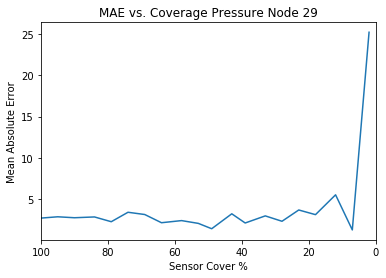

In [4]:
plt.plot(sensors_covered, MAE_average)
plt.ylabel("Mean Absolute Error")
plt.xlabel("Sensor Cover %")
plt.title("MAE vs. Coverage Pressure Node 29")
plt.xlim([100, 0])
plt.show()

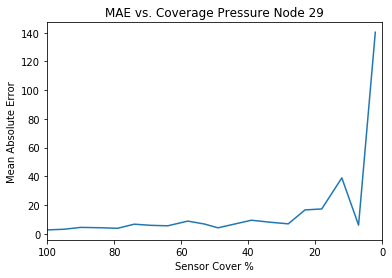

In [9]:
plt.plot(sensors_covered, maximum_MAE)
plt.ylabel("Mean Absolute Error")
plt.xlabel("Sensor Cover %")
plt.title("MAE vs. Coverage Pressure Node 29")
plt.xlim([100, 0])
plt.savefig('/Users/alexellard/Downloads/MAXPressureMAEnode29.png')
plt.show()

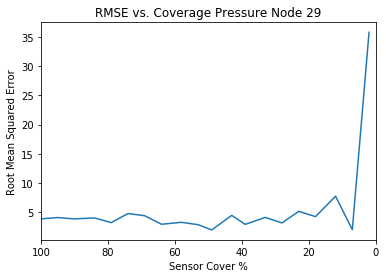

In [6]:
plt.plot(sensors_covered, RMSE_average)
plt.ylabel("Root Mean Squared Error")
plt.xlabel("Sensor Cover %")
plt.title("RMSE vs. Coverage Pressure Node 29")
plt.xlim([100, 0])
plt.show()

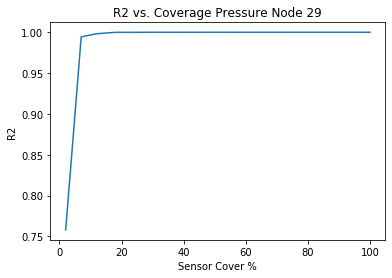

In [8]:
plt.plot(sensors_covered, R2_average)
plt.ylabel("R2")
plt.xlabel("Sensor Cover %")
plt.title("R2 vs. Coverage Pressure Node 29")
plt.show()

In [10]:
#Run pressure node 16

MAE_average_16 = []
RMSE_average_16 = []
R2_average_16 = []
maximum_MAE_16 = []
sensors_covered = []
n_columns_to_drop = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]
for n in n_columns_to_drop:
    MAE_16 = []
    RMSE_16 = []
    R2_16 = []
    for run in range(1,11):
        Y = df[df.columns[48]]
        X = df.drop(columns=['node_16_pressure'])
        X['node_16_pressure'] = Y
        columns = []
        columns_to_drop = random.sample(list(X.columns), n)
        # Drop the selected columns from the dataframe
        if X.columns[-1] in columns_to_drop:
            columns_to_drop.remove(X.columns[-1])
        X.drop(columns_to_drop, axis=1, inplace=True)
        columns.append(columns_to_drop)
        print(columns)
        print('starting df shape:', X.shape)
        print(f'This is training run {run} and has the shape: ', X.shape)
        print(f'The value of dropped columns is {n}')

        # split into train and test sets
        values = X.values
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled = scaler.fit_transform(values)
        train, test = train_test_split(scaled, test_size=0.2, random_state=0)

        # split into input and outputs
        train_X, train_y = train[:, :-1], train[:, -1]
        test_X, test_y = test[:, :-1], test[:, -1]

        #define model
        model = xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.9,
            colsample_bytree=0.8,
            random_state=42
        )

        # fit the model on the training data
        model.fit(train_X, train_y)

        # make predictions on the test data
        y_pred = model.predict(test_X)

        test_y = test_y.reshape((len(test_y), 1))
        print('test y shape :', test_y.shape)
        inv_test_y = concatenate((test_y, test_X[:, -X.shape[1]:]), axis=1)
        print('Inv y shape :', inv_test_y.shape)
        test_y_inverse = scaler.inverse_transform(inv_test_y)
        test_y_inverse = test_y_inverse[:,0]
        
        y_pred = y_pred.reshape((len(y_pred), 1))
        print('y pred shape :', y_pred.shape)
        inv_y_pred = concatenate((y_pred, test_X[:, -X.shape[1]:]), axis=1)
        print('inv y pred :', inv_y_pred.shape)
        y_pred_inverse = scaler.inverse_transform(inv_y_pred)
        y_pred_inverse = y_pred_inverse[:,0]

        # evaluate scaled errors
        mae_inverse = mean_absolute_error(test_y_inverse, y_pred_inverse)
        MAE_16.append(mae_inverse)
        print(f'Run {run} Mean Absolute Error:', mae_inverse)
        rmse_inverse = sqrt(mean_squared_error(test_y_inverse, y_pred_inverse))
        RMSE_16.append(rmse_inverse)
        print('RMSE: %.3f' % rmse_inverse)
        r2_inverse = r2_score(test_y_inverse, y_pred_inverse)
        R2_16.append(r2_inverse)
        print('R^2: %.3f' % r2_inverse)
    percentage_list = round(X.shape[1] / 96 * 100)
    sensors_covered.append(percentage_list)
    MAE_mean = mean(MAE_16)
    RMSE_mean = mean(RMSE_16)
    R2_mean = mean(R2_16)
    max_MAE = max(MAE_16)
    maximum_MAE_16.append(max_MAE)
    MAE_average_16.append(MAE_mean)
    RMSE_average_16.append(RMSE_mean)
    R2_average_16.append(R2_mean)

[[]]
starting df shape: (87600, 96)
This is training run 1 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 1 Mean Absolute Error: 7.354637090832215
RMSE: 10.219
R^2: 1.000
[[]]
starting df shape: (87600, 96)
This is training run 2 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 2 Mean Absolute Error: 7.354637090832215
RMSE: 10.219
R^2: 1.000
[[]]
starting df shape: (87600, 96)
This is training run 3 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 3 Mean Absolute Error: 7.354637090832215
RMSE: 10.219
R^2: 1.000
[[]]
starting df shape: (87600, 96)
This is training run 4 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 4 Mean Absolute Error: 7.354637090832215
RMSE: 10.219
R^2: 1.000
[[]]
starting df shape: (87600, 96)
This is training run 5 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 5 Mean Absolute Error: 7.354637090832215
RMSE: 10.219
R^2: 1.000
[[]]
starting df shape: (87600, 96)
This is training run 6 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 6 Mean Absolute Error: 7.354637090832215
RMSE: 10.219
R^2: 1.000
[[]]
starting df shape: (87600, 96)
This is training run 7 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 7 Mean Absolute Error: 7.354637090832215
RMSE: 10.219
R^2: 1.000
[[]]
starting df shape: (87600, 96)
This is training run 8 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 8 Mean Absolute Error: 7.354637090832215
RMSE: 10.219
R^2: 1.000
[[]]
starting df shape: (87600, 96)
This is training run 9 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 9 Mean Absolute Error: 7.354637090832215
RMSE: 10.219
R^2: 1.000
[[]]
starting df shape: (87600, 96)
This is training run 10 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 10 Mean Absolute Error: 7.354637090832215
RMSE: 10.219
R^2: 1.000
[['node_3_demand', 'node_1_pressure', 'link_17_flow', 'node_21_pressure', 'node_25_pressure']]
starting df shape: (87600, 91)
This is training run 1 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 1 Mean Absolute Error: 7.706061687583214
RMSE: 10.779
R^2: 1.000
[['node_23_demand', 'node_16_demand', 'node_24_demand', 'node_20_demand']]
starting df shape: (87600, 92)
This is training run 2 and has the shape:  (87600, 92)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 92)
y pred shape : (17520, 1)
inv y pred : (17520, 92)
Run 2 Mean Absolute Error: 8.20463588729409
RMSE: 11.434
R^2: 1.000
[['link_18_flow', 'reservoir_demand', 'link_10_flow', 'node_18_demand', 'link_32_flow']]
starting df shape: (87600, 91)
This is training run 3 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 3 Mean Absolute Error: 0.47333358332604997
RMSE: 0.659
R^2: 1.000
[['node_14_demand', 'node_11_pressure', 'link_10_flow', 'link_18_flow', 'link_24_flow']]
starting df shape: (87600, 91)
This is training run 4 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 4 Mean Absolute Error: 7.761835778474066
RMSE: 10.854
R^2: 1.000
[['link_2_flow', 'node_4_pressure', 'node_26_demand', 'node_28_pressure', 'node_31_pressure']]
starting df shape: (87600, 91)
This is training run 5 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 5 Mean Absolute Error: 7.822726623011973
RMSE: 10.887
R^2: 1.000
[['node_12_pressure', 'link_20_flow', 'node_31_demand', 'reservoir_demand', 'node_13_demand']]
starting df shape: (87600, 91)
This is training run 6 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 6 Mean Absolute Error: 0.4586591715902021
RMSE: 0.647
R^2: 1.000
[['node_13_demand', 'node_31_demand', 'link_29_flow', 'node_15_demand', 'node_6_pressure']]
starting df shape: (87600, 91)
This is training run 7 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 7 Mean Absolute Error: 7.744755540097428
RMSE: 10.680
R^2: 1.000
[['link_17_flow', 'reservoir_demand', 'node_21_demand', 'link_29_flow', 'node_6_demand']]
starting df shape: (87600, 91)
This is training run 8 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 8 Mean Absolute Error: 0.48759257262514194
RMSE: 0.683
R^2: 1.000
[['node_12_pressure', 'node_19_pressure', 'link_2_flow', 'node_8_demand', 'reservoir_pressure']]
starting df shape: (87600, 91)
This is training run 9 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 9 Mean Absolute Error: 7.630125722203497
RMSE: 10.751
R^2: 1.000
[['node_9_pressure', 'node_28_demand', 'node_31_pressure', 'node_29_pressure', 'node_16_demand']]
starting df shape: (87600, 91)
This is training run 10 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 10 Mean Absolute Error: 8.454207291611036
RMSE: 11.834
R^2: 1.000
[['node_15_demand', 'node_19_pressure', 'node_15_pressure', 'link_21_flow', 'node_4_pressure', 'link_1_flow', 'node_19_demand', 'node_17_pressure', 'node_8_pressure', 'node_4_demand']]
starting df shape: (87600, 86)
This is training run 1 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 1 Mean Absolute Error: 8.311748284703354
RMSE: 11.430
R^2: 1.000
[['link_26_flow', 'node_1_pressure', 'node_15_pressure', 'node_31_pressure', 'node_4_demand', 'link_16_flow', 'node_29_demand', 'link_13_flow', 'link_11_flow', 'reservoir_demand']]
starting df shape: (87600, 86)
This is training run 2 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 2 Mean Absolute Error: 0.48706978385049704
RMSE: 0.666
R^2: 1.000
[['link_31_flow', 'link_26_flow', 'node_16_demand', 'reservoir_demand', 'node_10_demand', 'node_14_demand', 'node_1_pressure', 'node_31_pressure', 'node_1_demand', 'node_17_demand']]
starting df shape: (87600, 86)
This is training run 3 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 3 Mean Absolute Error: 0.44886167708749924
RMSE: 0.631
R^2: 1.000
[['node_15_pressure', 'node_1_demand', 'node_30_pressure', 'node_18_pressure', 'node_11_demand', 'node_13_demand', 'node_13_pressure', 'node_28_pressure', 'node_6_demand', 'link_11_flow']]
starting df shape: (87600, 86)
This is training run 4 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 4 Mean Absolute Error: 8.169663853398822
RMSE: 11.227
R^2: 1.000
[['node_23_pressure', 'node_1_pressure', 'link_23_flow', 'link_18_flow', 'node_5_pressure', 'link_7_flow', 'node_7_pressure', 'link_8_flow', 'node_31_demand', 'link_5_flow']]
starting df shape: (87600, 86)
This is training run 5 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 5 Mean Absolute Error: 7.571569163618036
RMSE: 10.537
R^2: 1.000
[['node_12_pressure', 'node_7_demand', 'node_27_demand', 'node_11_pressure', 'node_10_demand', 'node_5_demand', 'node_3_demand', 'link_31_flow', 'node_25_pressure', 'node_30_demand']]
starting df shape: (87600, 86)
This is training run 6 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 6 Mean Absolute Error: 6.973810592284074
RMSE: 10.063
R^2: 1.000
[['link_11_flow', 'node_27_demand', 'node_3_pressure', 'link_10_flow', 'link_12_flow', 'node_8_demand', 'node_2_pressure', 'link_19_flow', 'link_14_flow', 'link_29_flow']]
starting df shape: (87600, 86)
This is training run 7 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 7 Mean Absolute Error: 7.543956859213363
RMSE: 10.563
R^2: 1.000
[['link_19_flow', 'node_23_demand', 'node_9_pressure', 'link_13_flow', 'link_3_flow', 'link_22_flow', 'link_29_flow', 'link_16_flow', 'node_28_pressure', 'link_32_flow']]
starting df shape: (87600, 86)
This is training run 8 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 8 Mean Absolute Error: 7.847550307892612
RMSE: 10.891
R^2: 1.000
[['link_30_flow', 'node_26_pressure', 'node_27_demand', 'node_9_pressure', 'node_4_pressure', 'node_2_demand', 'node_6_pressure', 'link_26_flow', 'node_24_demand', 'reservoir_demand']]
starting df shape: (87600, 86)
This is training run 9 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 9 Mean Absolute Error: 0.46484631772755
RMSE: 0.646
R^2: 1.000
[['node_22_pressure', 'link_27_flow', 'node_3_demand', 'reservoir_pressure', 'node_23_demand', 'node_29_pressure', 'node_10_pressure', 'node_30_demand', 'link_30_flow', 'node_26_demand']]
starting df shape: (87600, 86)
This is training run 10 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 10 Mean Absolute Error: 7.777604961738362
RMSE: 10.766
R^2: 1.000
[['node_21_pressure', 'link_22_flow', 'node_18_pressure', 'node_3_demand', 'node_14_pressure', 'link_26_flow', 'link_28_flow', 'link_23_flow', 'link_13_flow', 'link_18_flow', 'reservoir_demand', 'node_1_pressure', 'node_15_demand', 'node_27_demand', 'node_13_demand']]
starting df shape: (87600, 81)
This is training run 1 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 1 Mean Absolute Error: 0.47235586989670963
RMSE: 0.657
R^2: 1.000
[['node_28_pressure', 'node_27_demand', 'link_10_flow', 'link_19_flow', 'node_8_demand', 'link_27_flow', 'node_20_pressure', 'node_15_demand', 'node_5_pressure', 'node_3_demand', 'node_9_demand', 'node_20_demand', 'node_21_demand', 'node_29_pressure', 'node_25_demand']]
starting df shape: (87600, 81)
This is training run 2 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 2 Mean Absolute Error: 7.505584898433875
RMSE: 10.532
R^2: 1.000
[['node_6_pressure', 'node_4_pressure', 'node_11_pressure', 'node_21_pressure', 'node_23_demand', 'node_22_demand', 'node_31_demand', 'link_4_flow', 'node_2_pressure', 'link_27_flow', 'node_4_demand', 'node_11_demand', 'reservoir_pressure', 'link_18_flow', 'node_12_demand']]
starting df shape: (87600, 81)
This is training run 3 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 3 Mean Absolute Error: 7.717863228171449
RMSE: 10.922
R^2: 1.000
[['node_4_pressure', 'node_7_pressure', 'link_11_flow', 'node_17_demand', 'link_8_flow', 'link_1_flow', 'node_12_demand', 'link_31_flow', 'node_25_demand', 'node_28_demand', 'link_9_flow', 'node_18_demand', 'node_10_demand', 'node_2_demand', 'link_15_flow']]
starting df shape: (87600, 81)
This is training run 4 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 4 Mean Absolute Error: 8.508001513542196
RMSE: 11.880
R^2: 1.000
[['node_6_demand', 'link_4_flow', 'node_6_pressure', 'node_1_demand', 'node_27_pressure', 'node_13_demand', 'node_15_demand', 'node_26_pressure', 'link_23_flow', 'link_15_flow', 'node_18_demand', 'node_21_pressure', 'node_5_demand', 'node_23_demand', 'link_25_flow']]
starting df shape: (87600, 81)
This is training run 5 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 5 Mean Absolute Error: 7.965691654059748
RMSE: 11.173
R^2: 1.000
[['node_31_demand', 'node_13_pressure', 'node_7_pressure', 'link_8_flow', 'link_5_flow', 'link_24_flow', 'link_18_flow', 'node_25_demand', 'link_27_flow', 'link_7_flow', 'node_23_demand', 'node_6_pressure', 'node_26_pressure', 'reservoir_pressure']]
starting df shape: (87600, 82)
This is training run 6 and has the shape:  (87600, 82)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 82)
y pred shape : (17520, 1)
inv y pred : (17520, 82)
Run 6 Mean Absolute Error: 7.631105911630267
RMSE: 10.619
R^2: 1.000
[['node_26_demand', 'node_13_pressure', 'link_29_flow', 'node_28_pressure', 'node_4_demand', 'node_14_demand', 'link_30_flow', 'node_29_demand', 'link_17_flow', 'node_7_pressure', 'node_11_demand', 'node_1_pressure', 'node_22_demand', 'node_16_demand', 'link_1_flow']]
starting df shape: (87600, 81)
This is training run 7 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 7 Mean Absolute Error: 8.158486887641141
RMSE: 11.414
R^2: 1.000
[['link_18_flow', 'link_32_flow', 'link_24_flow', 'node_3_demand', 'link_22_flow', 'link_26_flow', 'node_9_pressure', 'node_27_demand', 'link_3_flow', 'link_28_flow', 'node_18_demand', 'link_2_flow', 'link_29_flow', 'link_15_flow', 'node_4_demand']]
starting df shape: (87600, 81)
This is training run 8 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 8 Mean Absolute Error: 7.9669756700949
RMSE: 11.101
R^2: 1.000
[['node_24_pressure', 'node_30_demand', 'node_14_demand', 'link_1_flow', 'link_17_flow', 'node_13_demand', 'node_9_pressure', 'node_23_pressure', 'node_12_pressure', 'node_19_pressure', 'node_6_demand', 'node_31_demand', 'node_8_demand', 'link_22_flow', 'link_15_flow']]
starting df shape: (87600, 81)
This is training run 9 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 9 Mean Absolute Error: 7.425568847071568
RMSE: 10.371
R^2: 1.000
[['node_30_pressure', 'node_16_demand', 'node_1_pressure', 'node_25_demand', 'link_13_flow', 'node_29_pressure', 'node_26_pressure', 'link_9_flow', 'link_3_flow', 'node_13_pressure', 'node_26_demand', 'node_17_demand', 'node_6_pressure', 'link_20_flow', 'link_32_flow']]
starting df shape: (87600, 81)
This is training run 10 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 10 Mean Absolute Error: 8.231254599384366
RMSE: 11.376
R^2: 1.000
[['node_13_pressure', 'node_15_demand', 'link_15_flow', 'node_26_demand', 'node_23_pressure', 'node_25_pressure', 'node_27_demand', 'node_18_demand', 'link_19_flow', 'link_32_flow', 'link_3_flow', 'node_14_demand', 'node_31_pressure', 'link_24_flow', 'node_19_demand', 'link_29_flow', 'node_11_demand', 'link_17_flow', 'node_1_demand', 'link_18_flow']]
starting df shape: (87600, 76)
This is training run 1 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 1 Mean Absolute Error: 7.921061491226482
RMSE: 11.068
R^2: 1.000
[['link_21_flow', 'reservoir_demand', 'node_5_demand', 'node_12_pressure', 'link_30_flow', 'link_26_flow', 'node_28_pressure', 'link_29_flow', 'node_21_demand', 'node_14_demand', 'node_28_demand', 'link_3_flow', 'link_2_flow', 'node_9_pressure', 'node_20_demand', 'link_12_flow', 'link_1_flow', 'link_18_flow', 'link_31_flow', 'node_27_demand']]
starting df shape: (87600, 76)
This is training run 2 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 2 Mean Absolute Error: 0.44532261492690167
RMSE: 0.621
R^2: 1.000
[['node_8_demand', 'node_4_pressure', 'link_29_flow', 'reservoir_demand', 'node_14_demand', 'node_4_demand', 'link_12_flow', 'node_17_pressure', 'node_2_demand', 'node_26_demand', 'node_13_demand', 'node_23_pressure', 'node_17_demand', 'node_20_demand', 'node_31_demand', 'link_19_flow', 'node_2_pressure', 'node_18_pressure', 'node_23_demand', 'link_3_flow']]
starting df shape: (87600, 76)
This is training run 3 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 3 Mean Absolute Error: 0.5051169695538595
RMSE: 0.700
R^2: 1.000
[['node_10_pressure', 'link_10_flow', 'link_3_flow', 'link_22_flow', 'link_7_flow', 'node_31_demand', 'node_18_demand', 'node_28_demand', 'link_1_flow', 'node_10_demand', 'node_8_pressure', 'node_24_demand', 'node_22_pressure', 'link_12_flow', 'node_25_demand', 'node_17_demand', 'node_8_demand', 'node_21_demand', 'node_25_pressure', 'node_18_pressure']]
starting df shape: (87600, 76)
This is training run 4 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 4 Mean Absolute Error: 7.962840174549752
RMSE: 11.041
R^2: 1.000
[['link_25_flow', 'node_1_pressure', 'node_23_pressure', 'node_11_demand', 'node_8_demand', 'node_24_pressure', 'node_14_pressure', 'reservoir_pressure', 'node_8_pressure', 'link_4_flow', 'node_21_pressure', 'node_24_demand', 'node_30_demand', 'link_24_flow', 'node_10_pressure', 'link_8_flow', 'link_15_flow', 'node_9_pressure', 'node_5_pressure', 'node_13_pressure']]
starting df shape: (87600, 76)
This is training run 5 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 5 Mean Absolute Error: 7.933967321299995
RMSE: 11.075
R^2: 1.000
[['node_1_demand', 'link_9_flow', 'node_18_demand', 'link_10_flow', 'node_15_pressure', 'link_19_flow', 'link_2_flow', 'node_29_pressure', 'node_31_pressure', 'link_29_flow', 'node_29_demand', 'node_3_pressure', 'link_21_flow', 'node_5_pressure', 'node_17_demand', 'node_31_demand', 'link_6_flow', 'node_22_pressure', 'link_13_flow', 'node_23_pressure']]
starting df shape: (87600, 76)
This is training run 6 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 6 Mean Absolute Error: 7.959268560736701
RMSE: 11.010
R^2: 1.000
[['node_19_demand', 'node_27_pressure', 'node_7_demand', 'node_23_demand', 'link_30_flow', 'link_4_flow', 'node_13_pressure', 'node_1_demand', 'link_5_flow', 'node_20_demand', 'node_2_demand', 'node_15_demand', 'node_14_pressure', 'link_25_flow', 'node_28_demand', 'node_18_demand', 'link_28_flow', 'node_14_demand', 'link_2_flow', 'node_8_demand']]
starting df shape: (87600, 76)
This is training run 7 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 7 Mean Absolute Error: 7.6957988189044135
RMSE: 10.646
R^2: 1.000
[['node_29_demand', 'node_8_demand', 'node_22_demand', 'node_7_pressure', 'link_8_flow', 'node_30_pressure', 'link_20_flow', 'node_4_demand', 'link_29_flow', 'link_15_flow', 'link_25_flow', 'node_30_demand', 'node_5_demand', 'link_6_flow', 'node_24_demand', 'node_21_demand', 'node_26_pressure', 'node_6_demand', 'link_26_flow', 'node_3_demand']]
starting df shape: (87600, 76)
This is training run 8 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 8 Mean Absolute Error: 8.011662036371844
RMSE: 11.240
R^2: 1.000
[['node_26_demand', 'node_31_demand', 'node_14_demand', 'node_22_demand', 'node_23_pressure', 'link_14_flow', 'link_28_flow', 'link_16_flow', 'link_2_flow', 'node_26_pressure', 'reservoir_pressure', 'node_3_pressure', 'node_7_pressure', 'node_20_pressure', 'node_25_demand', 'node_11_pressure', 'node_27_demand', 'link_30_flow', 'node_28_demand']]
starting df shape: (87600, 77)
This is training run 9 and has the shape:  (87600, 77)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 77)
y pred shape : (17520, 1)
inv y pred : (17520, 77)
Run 9 Mean Absolute Error: 7.663856745518476
RMSE: 10.663
R^2: 1.000
[['node_17_demand', 'node_3_demand', 'link_31_flow', 'link_28_flow', 'node_12_pressure', 'node_18_demand', 'link_11_flow', 'link_29_flow', 'node_3_pressure', 'node_14_pressure', 'node_8_pressure', 'node_8_demand', 'link_8_flow', 'link_19_flow', 'node_2_demand', 'node_2_pressure', 'link_30_flow', 'node_12_demand', 'link_20_flow', 'link_26_flow']]
starting df shape: (87600, 76)
This is training run 10 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 10 Mean Absolute Error: 7.679671346787193
RMSE: 10.616
R^2: 1.000
[['node_11_demand', 'node_23_pressure', 'node_12_demand', 'link_7_flow', 'node_26_pressure', 'node_24_pressure', 'node_2_pressure', 'node_8_pressure', 'node_9_pressure', 'link_2_flow', 'node_18_demand', 'link_32_flow', 'link_25_flow', 'node_21_demand', 'link_26_flow', 'link_4_flow', 'node_1_pressure', 'node_28_demand', 'link_23_flow', 'node_13_pressure', 'node_30_pressure', 'node_6_pressure', 'reservoir_pressure', 'node_29_pressure', 'node_22_pressure']]
starting df shape: (87600, 71)
This is training run 1 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 1 Mean Absolute Error: 7.872699896732262
RMSE: 11.074
R^2: 1.000
[['node_7_pressure', 'node_17_pressure', 'node_17_demand', 'node_18_pressure', 'link_21_flow', 'node_3_demand', 'node_3_pressure', 'link_31_flow', 'link_17_flow', 'node_30_pressure', 'node_20_pressure', 'node_26_demand', 'node_28_demand', 'link_20_flow', 'node_13_demand', 'link_15_flow', 'node_14_demand', 'node_9_demand', 'node_1_pressure', 'node_21_pressure', 'link_30_flow', 'node_6_demand', 'node_4_pressure', 'node_5_demand', 'node_10_demand']]
starting df shape: (87600, 71)
This is training run 2 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 2 Mean Absolute Error: 9.048403199598244
RMSE: 12.569
R^2: 1.000
[['link_25_flow', 'link_4_flow', 'node_28_demand', 'node_28_pressure', 'node_9_demand', 'node_27_pressure', 'node_8_pressure', 'link_23_flow', 'node_17_demand', 'node_7_pressure', 'node_22_demand', 'node_11_demand', 'node_29_demand', 'link_9_flow', 'link_14_flow', 'node_23_pressure', 'node_6_pressure', 'node_16_demand', 'node_31_demand', 'node_27_demand', 'node_24_demand', 'link_1_flow', 'node_13_demand', 'node_3_demand', 'node_21_demand']]
starting df shape: (87600, 71)
This is training run 3 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 3 Mean Absolute Error: 8.058787266743652
RMSE: 11.134
R^2: 1.000
[['node_25_demand', 'link_23_flow', 'link_27_flow', 'node_28_demand', 'node_3_demand', 'link_24_flow', 'node_17_pressure', 'node_2_pressure', 'node_4_pressure', 'node_26_pressure', 'node_30_pressure', 'node_10_pressure', 'node_14_pressure', 'node_23_pressure', 'node_21_demand', 'node_2_demand', 'node_18_pressure', 'node_16_demand', 'link_20_flow', 'node_11_pressure', 'link_13_flow', 'link_19_flow', 'link_29_flow', 'node_24_demand', 'node_22_demand']]
starting df shape: (87600, 71)
This is training run 4 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 4 Mean Absolute Error: 8.767556364808142
RMSE: 12.160
R^2: 1.000
[['link_28_flow', 'node_5_demand', 'link_6_flow', 'node_23_demand', 'link_31_flow', 'node_29_pressure', 'node_25_pressure', 'node_14_demand', 'node_26_pressure', 'node_6_pressure', 'node_15_pressure', 'link_9_flow', 'node_19_demand', 'node_8_pressure', 'node_23_pressure', 'node_15_demand', 'node_11_pressure', 'node_14_pressure', 'node_27_demand', 'node_13_pressure', 'node_2_demand', 'node_16_demand', 'node_28_demand', 'link_20_flow', 'link_32_flow']]
starting df shape: (87600, 71)
This is training run 5 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 5 Mean Absolute Error: 9.277062842226735
RMSE: 12.740
R^2: 1.000
[['node_17_pressure', 'node_30_demand', 'reservoir_demand', 'node_7_demand', 'link_16_flow', 'link_18_flow', 'link_3_flow', 'node_22_demand', 'node_10_demand', 'link_8_flow', 'node_30_pressure', 'link_9_flow', 'node_24_demand', 'node_6_demand', 'node_11_demand', 'link_31_flow', 'link_19_flow', 'node_3_pressure', 'node_23_pressure', 'link_4_flow', 'node_7_pressure', 'node_29_demand', 'node_18_pressure', 'link_28_flow', 'reservoir_pressure']]
starting df shape: (87600, 71)
This is training run 6 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 6 Mean Absolute Error: 0.47981320143064404
RMSE: 0.668
R^2: 1.000
[['node_14_pressure', 'link_25_flow', 'node_19_demand', 'node_17_pressure', 'node_23_pressure', 'link_29_flow', 'link_15_flow', 'reservoir_demand', 'node_8_pressure', 'node_3_demand', 'node_30_demand', 'node_30_pressure', 'link_32_flow', 'node_9_pressure', 'node_9_demand', 'node_11_pressure', 'link_18_flow', 'node_5_demand', 'node_15_demand', 'node_5_pressure', 'link_1_flow', 'node_16_demand', 'node_27_pressure', 'node_18_pressure']]
starting df shape: (87600, 72)
This is training run 7 and has the shape:  (87600, 72)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 72)
y pred shape : (17520, 1)
inv y pred : (17520, 72)
Run 7 Mean Absolute Error: 0.6577346250405912
RMSE: 0.910
R^2: 1.000
[['link_29_flow', 'node_15_pressure', 'node_4_pressure', 'node_6_pressure', 'link_24_flow', 'node_13_demand', 'link_16_flow', 'node_16_demand', 'node_19_demand', 'node_24_demand', 'node_25_demand', 'link_17_flow', 'link_10_flow', 'node_9_demand', 'node_11_pressure', 'link_28_flow', 'node_14_pressure', 'node_8_demand', 'node_7_demand', 'link_13_flow', 'node_26_demand', 'node_31_demand', 'node_21_demand', 'node_14_demand', 'link_21_flow']]
starting df shape: (87600, 71)
This is training run 8 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 8 Mean Absolute Error: 9.884807813002864
RMSE: 13.507
R^2: 1.000
[['node_22_pressure', 'link_7_flow', 'node_13_pressure', 'node_12_demand', 'link_18_flow', 'node_23_demand', 'node_28_demand', 'link_6_flow', 'node_13_demand', 'node_14_pressure', 'node_17_demand', 'link_9_flow', 'node_11_demand', 'link_24_flow', 'link_30_flow', 'link_5_flow', 'link_1_flow', 'node_14_demand', 'node_20_demand', 'link_22_flow', 'node_21_demand', 'node_28_pressure', 'node_26_demand', 'link_27_flow']]
starting df shape: (87600, 72)
This is training run 9 and has the shape:  (87600, 72)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 72)
y pred shape : (17520, 1)
inv y pred : (17520, 72)
Run 9 Mean Absolute Error: 8.139315082193253
RMSE: 11.372
R^2: 1.000
[['node_18_pressure', 'node_26_pressure', 'node_14_demand', 'node_30_demand', 'node_23_demand', 'link_14_flow', 'node_8_demand', 'node_21_pressure', 'node_29_demand', 'node_31_pressure', 'node_11_pressure', 'node_20_pressure', 'node_2_demand', 'link_6_flow', 'node_5_demand', 'node_26_demand', 'link_15_flow', 'node_15_pressure', 'node_18_demand', 'node_28_pressure', 'link_8_flow', 'node_12_demand', 'node_20_demand', 'node_23_pressure']]
starting df shape: (87600, 72)
This is training run 10 and has the shape:  (87600, 72)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 72)
y pred shape : (17520, 1)
inv y pred : (17520, 72)
Run 10 Mean Absolute Error: 8.780107257586028
RMSE: 11.998
R^2: 1.000
[['node_17_demand', 'link_15_flow', 'link_4_flow', 'link_18_flow', 'link_14_flow', 'node_20_demand', 'node_29_demand', 'link_23_flow', 'node_1_pressure', 'node_21_pressure', 'node_31_pressure', 'link_19_flow', 'node_7_pressure', 'node_21_demand', 'node_13_pressure', 'node_5_demand', 'node_24_demand', 'node_26_pressure', 'node_11_demand', 'link_12_flow', 'node_4_pressure', 'node_28_pressure', 'link_3_flow', 'node_22_demand', 'node_4_demand', 'node_12_demand', 'link_26_flow', 'node_3_demand', 'node_9_demand']]
starting df shape: (87600, 67)
This is training run 1 and has the shape:  (87600, 67)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 67)
y pred shape : (17520, 1)
inv y pred : (17520, 67)
Run 1 Mean Absolute Error: 8.173727624117026
RMSE: 11.529
R^2: 1.000
[['node_6_pressure', 'node_31_pressure', 'node_18_pressure', 'node_25_demand', 'node_9_demand', 'reservoir_demand', 'link_8_flow', 'node_28_pressure', 'link_12_flow', 'node_1_pressure', 'link_18_flow', 'link_17_flow', 'node_21_demand', 'link_27_flow', 'node_7_demand', 'node_29_pressure', 'node_23_demand', 'link_1_flow', 'node_22_pressure', 'node_23_pressure', 'node_24_pressure', 'link_10_flow', 'node_17_pressure', 'link_22_flow', 'link_11_flow', 'node_4_demand', 'node_26_demand', 'link_28_flow', 'node_14_pressure', 'node_25_pressure']]
starting df shape: (87600, 66)
This is training run 2 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 2 Mean Absolute Error: 0.5058642885676014
RMSE: 0.703
R^2: 1.000
[['link_20_flow', 'link_11_flow', 'node_10_pressure', 'link_8_flow', 'node_5_pressure', 'link_32_flow', 'node_19_demand', 'node_10_demand', 'reservoir_pressure', 'node_15_demand', 'node_6_pressure', 'node_8_demand', 'node_23_pressure', 'link_15_flow', 'node_12_pressure', 'link_21_flow', 'node_11_demand', 'node_20_pressure', 'link_4_flow', 'node_27_demand', 'link_16_flow', 'node_31_demand', 'node_18_demand', 'node_1_demand', 'link_26_flow', 'node_17_demand', 'node_3_pressure', 'link_23_flow', 'node_5_demand', 'link_9_flow']]
starting df shape: (87600, 66)
This is training run 3 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 3 Mean Absolute Error: 7.176941280502546
RMSE: 10.179
R^2: 1.000
[['node_8_pressure', 'node_29_pressure', 'node_25_demand', 'link_17_flow', 'node_3_pressure', 'node_26_demand', 'node_5_pressure', 'node_12_pressure', 'link_7_flow', 'node_17_pressure', 'link_12_flow', 'node_23_pressure', 'node_24_pressure', 'link_19_flow', 'link_27_flow', 'node_15_pressure', 'node_23_demand', 'node_12_demand', 'node_21_pressure', 'node_8_demand', 'node_22_demand', 'node_14_pressure', 'link_9_flow', 'node_2_demand', 'node_21_demand', 'node_28_demand', 'node_3_demand', 'link_16_flow', 'node_10_pressure']]
starting df shape: (87600, 67)
This is training run 4 and has the shape:  (87600, 67)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 67)
y pred shape : (17520, 1)
inv y pred : (17520, 67)
Run 4 Mean Absolute Error: 7.974806947782037
RMSE: 11.056
R^2: 1.000
[['link_12_flow', 'link_31_flow', 'node_12_pressure', 'link_26_flow', 'node_26_pressure', 'link_18_flow', 'link_10_flow', 'node_27_pressure', 'node_18_pressure', 'node_30_demand', 'link_25_flow', 'link_2_flow', 'link_24_flow', 'node_7_demand', 'node_14_demand', 'link_19_flow', 'node_7_pressure', 'link_30_flow', 'node_12_demand', 'node_8_pressure', 'node_15_pressure', 'link_14_flow', 'link_11_flow', 'node_28_pressure', 'node_19_demand', 'link_21_flow', 'node_20_pressure', 'node_21_pressure', 'node_10_pressure', 'node_19_pressure']]
starting df shape: (87600, 66)
This is training run 5 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 5 Mean Absolute Error: 7.598833954294945
RMSE: 10.589
R^2: 1.000
[['node_24_demand', 'link_8_flow', 'node_19_demand', 'node_30_pressure', 'node_3_pressure', 'link_16_flow', 'link_12_flow', 'link_31_flow', 'reservoir_pressure', 'node_4_pressure', 'link_23_flow', 'link_19_flow', 'node_17_pressure', 'node_11_demand', 'link_27_flow', 'link_13_flow', 'node_14_demand', 'node_31_pressure', 'node_5_pressure', 'node_2_demand', 'link_25_flow', 'node_11_pressure', 'node_6_demand', 'node_16_demand', 'node_17_demand', 'link_32_flow', 'node_4_demand', 'link_29_flow', 'node_25_pressure', 'node_25_demand']]
starting df shape: (87600, 66)
This is training run 6 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 6 Mean Absolute Error: 10.121820051914067
RMSE: 14.108
R^2: 1.000
[['node_7_demand', 'link_24_flow', 'reservoir_demand', 'link_1_flow', 'node_24_pressure', 'node_3_demand', 'node_18_demand', 'link_31_flow', 'node_30_pressure', 'node_10_demand', 'link_29_flow', 'link_7_flow', 'node_13_pressure', 'link_11_flow', 'node_17_demand', 'node_14_pressure', 'link_27_flow', 'node_15_demand', 'node_9_demand', 'link_17_flow', 'link_12_flow', 'node_24_demand', 'link_13_flow', 'link_14_flow', 'link_4_flow', 'node_16_demand', 'node_22_demand', 'node_6_pressure', 'link_15_flow']]
starting df shape: (87600, 67)
This is training run 7 and has the shape:  (87600, 67)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 67)
y pred shape : (17520, 1)
inv y pred : (17520, 67)
Run 7 Mean Absolute Error: 0.6239705428265913
RMSE: 0.889
R^2: 1.000
[['link_20_flow', 'node_20_demand', 'reservoir_demand', 'node_12_demand', 'link_16_flow', 'node_30_pressure', 'node_17_demand', 'node_23_demand', 'link_17_flow', 'node_27_demand', 'link_29_flow', 'node_22_demand', 'link_26_flow', 'node_15_pressure', 'link_18_flow', 'node_30_demand', 'link_9_flow', 'node_21_demand', 'node_24_demand', 'node_23_pressure', 'node_29_pressure', 'node_27_pressure', 'node_15_demand', 'node_3_pressure', 'link_15_flow', 'link_25_flow', 'node_19_pressure', 'node_22_pressure', 'link_1_flow', 'node_29_demand']]
starting df shape: (87600, 66)
This is training run 8 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 8 Mean Absolute Error: 0.5765934211079554
RMSE: 0.800
R^2: 1.000
[['node_10_pressure', 'link_20_flow', 'node_7_pressure', 'node_15_demand', 'node_23_demand', 'link_18_flow', 'node_11_pressure', 'reservoir_pressure', 'node_24_pressure', 'node_22_pressure', 'node_25_demand', 'node_23_pressure', 'link_15_flow', 'link_4_flow', 'node_7_demand', 'node_27_pressure', 'node_9_pressure', 'link_19_flow', 'link_5_flow', 'node_8_demand', 'node_19_demand', 'node_14_demand', 'node_6_pressure', 'node_26_pressure', 'link_17_flow', 'node_30_demand', 'node_17_pressure', 'link_28_flow', 'link_27_flow', 'link_14_flow']]
starting df shape: (87600, 66)
This is training run 9 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 9 Mean Absolute Error: 8.499356545367514
RMSE: 11.686
R^2: 1.000
[['node_30_pressure', 'node_9_pressure', 'link_31_flow', 'link_9_flow', 'link_24_flow', 'node_15_pressure', 'link_13_flow', 'node_11_pressure', 'node_6_demand', 'link_3_flow', 'link_8_flow', 'node_3_pressure', 'link_6_flow', 'link_15_flow', 'link_27_flow', 'node_13_pressure', 'link_23_flow', 'node_24_pressure', 'node_10_pressure', 'link_32_flow', 'node_8_demand', 'node_1_pressure', 'node_27_pressure', 'node_22_demand', 'node_14_demand', 'reservoir_demand', 'link_17_flow', 'node_25_pressure', 'node_12_demand', 'node_4_pressure']]
starting df shape: (87600, 66)
This is training run 10 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 10 Mean Absolute Error: 0.5267867263161069
RMSE: 0.722
R^2: 1.000
[['link_6_flow', 'link_4_flow', 'node_1_demand', 'node_10_demand', 'node_11_demand', 'link_16_flow', 'node_16_demand', 'link_19_flow', 'link_17_flow', 'link_2_flow', 'node_15_demand', 'link_21_flow', 'node_2_pressure', 'link_27_flow', 'node_24_demand', 'link_23_flow', 'link_18_flow', 'link_11_flow', 'link_9_flow', 'node_30_pressure', 'node_19_pressure', 'node_31_pressure', 'link_1_flow', 'node_25_pressure', 'node_6_pressure', 'node_24_pressure', 'node_22_pressure', 'node_4_demand', 'node_1_pressure', 'node_23_pressure', 'link_7_flow', 'link_15_flow', 'node_27_pressure', 'link_8_flow', 'reservoir_demand']]
starting df shape: (87600, 61)
This is training run 1 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 1 Mean Absolute Error: 0.697339987970611
RMSE: 0.996
R^2: 1.000
[['link_21_flow', 'link_26_flow', 'reservoir_pressure', 'node_12_pressure', 'node_25_pressure', 'node_25_demand', 'link_1_flow', 'node_6_pressure', 'node_24_pressure', 'node_17_demand', 'node_14_pressure', 'link_12_flow', 'link_2_flow', 'node_31_demand', 'node_7_demand', 'node_15_pressure', 'node_29_pressure', 'node_2_demand', 'node_19_pressure', 'link_9_flow', 'node_26_demand', 'node_6_demand', 'node_31_pressure', 'link_17_flow', 'link_23_flow', 'node_4_demand', 'link_18_flow', 'node_10_pressure', 'node_24_demand', 'node_16_demand', 'link_8_flow', 'node_18_demand', 'link_16_flow', 'node_26_pressure']]
starting df shape: (87600, 62)
This is training run 2 and has the shape:  (87600, 62)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 62)
y pred shape : (17520, 1)
inv y pred : (17520, 62)
Run 2 Mean Absolute Error: 9.663942928387222
RMSE: 13.393
R^2: 1.000
[['node_23_demand', 'node_5_pressure', 'node_24_pressure', 'node_18_pressure', 'node_16_demand', 'node_28_pressure', 'link_3_flow', 'node_22_pressure', 'node_9_demand', 'node_23_pressure', 'link_17_flow', 'node_15_pressure', 'link_25_flow', 'node_21_demand', 'node_11_demand', 'node_20_demand', 'node_29_demand', 'node_18_demand', 'node_25_demand', 'node_11_pressure', 'node_28_demand', 'node_31_demand', 'node_19_pressure', 'link_18_flow', 'node_6_pressure', 'link_21_flow', 'link_11_flow', 'link_1_flow', 'node_24_demand', 'link_19_flow', 'link_29_flow', 'link_14_flow', 'node_13_pressure', 'node_31_pressure']]
starting df shape: (87600, 62)
This is training run 3 and has the shape:  (87600, 62)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 62)
y pred shape : (17520, 1)
inv y pred : (17520, 62)
Run 3 Mean Absolute Error: 8.909040371573393
RMSE: 12.223
R^2: 1.000
[['node_14_pressure', 'node_5_demand', 'node_14_demand', 'node_18_demand', 'node_1_pressure', 'reservoir_pressure', 'link_10_flow', 'node_13_pressure', 'node_29_demand', 'node_22_pressure', 'node_9_pressure', 'node_3_pressure', 'node_10_demand', 'link_12_flow', 'node_31_pressure', 'node_21_pressure', 'link_28_flow', 'link_8_flow', 'node_2_pressure', 'node_11_demand', 'node_25_pressure', 'link_18_flow', 'link_24_flow', 'link_20_flow', 'node_17_demand', 'node_24_pressure', 'node_8_demand', 'node_7_pressure', 'link_25_flow', 'node_25_demand', 'node_8_pressure', 'link_7_flow', 'link_26_flow', 'node_24_demand', 'link_31_flow']]
starting df shape: (87600, 61)
This is training run 4 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 4 Mean Absolute Error: 7.814945634596553
RMSE: 10.963
R^2: 1.000
[['node_12_pressure', 'link_29_flow', 'link_2_flow', 'link_8_flow', 'node_6_pressure', 'node_22_demand', 'link_30_flow', 'node_26_pressure', 'link_5_flow', 'node_17_pressure', 'node_11_demand', 'link_24_flow', 'node_18_demand', 'node_20_pressure', 'node_21_pressure', 'node_30_pressure', 'node_9_demand', 'node_6_demand', 'node_4_demand', 'node_14_demand', 'reservoir_pressure', 'node_18_pressure', 'node_25_pressure', 'node_31_demand', 'node_29_demand', 'link_11_flow', 'node_5_pressure', 'link_32_flow', 'link_17_flow', 'node_27_demand', 'node_28_pressure', 'reservoir_demand', 'node_3_demand', 'node_24_demand']]
starting df shape: (87600, 62)
This is training run 5 and has the shape:  (87600, 62)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 62)
y pred shape : (17520, 1)
inv y pred : (17520, 62)
Run 5 Mean Absolute Error: 0.4515738387615427
RMSE: 0.636
R^2: 1.000
[['node_1_demand', 'node_21_demand', 'link_19_flow', 'link_29_flow', 'link_4_flow', 'node_7_pressure', 'node_7_demand', 'node_17_pressure', 'link_17_flow', 'link_13_flow', 'node_27_demand', 'node_1_pressure', 'reservoir_demand', 'node_31_pressure', 'node_11_demand', 'node_4_demand', 'link_14_flow', 'node_13_pressure', 'node_12_pressure', 'node_30_pressure', 'link_16_flow', 'node_10_demand', 'node_19_pressure', 'link_6_flow', 'node_31_demand', 'link_8_flow', 'link_23_flow', 'node_15_demand', 'link_9_flow', 'link_20_flow', 'node_5_demand', 'node_15_pressure', 'link_3_flow', 'node_4_pressure']]
starting df shape: (87600, 62)
This is training run 6 and has the shape:  (87600, 62)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 62)
y pred shape : (17520, 1)
inv y pred : (17520, 62)
Run 6 Mean Absolute Error: 0.43607478034429786
RMSE: 0.615
R^2: 1.000
[['link_3_flow', 'node_18_demand', 'node_9_demand', 'link_4_flow', 'link_5_flow', 'node_17_demand', 'link_24_flow', 'link_28_flow', 'node_26_pressure', 'node_24_demand', 'link_14_flow', 'node_26_demand', 'node_15_demand', 'node_10_demand', 'node_20_pressure', 'node_22_demand', 'node_2_pressure', 'node_3_pressure', 'node_8_demand', 'link_8_flow', 'link_17_flow', 'link_23_flow', 'link_27_flow', 'link_30_flow', 'link_22_flow', 'node_1_pressure', 'node_12_demand', 'node_19_demand', 'link_19_flow', 'node_30_demand', 'reservoir_pressure', 'node_12_pressure', 'node_5_demand', 'node_15_pressure', 'node_31_pressure']]
starting df shape: (87600, 61)
This is training run 7 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 7 Mean Absolute Error: 7.372381583816392
RMSE: 10.135
R^2: 1.000
[['node_1_demand', 'link_21_flow', 'node_8_demand', 'node_28_demand', 'link_29_flow', 'node_11_pressure', 'link_30_flow', 'node_13_demand', 'reservoir_demand', 'reservoir_pressure', 'node_21_demand', 'link_14_flow', 'link_26_flow', 'node_8_pressure', 'link_19_flow', 'node_31_pressure', 'node_10_pressure', 'link_22_flow', 'node_29_demand', 'node_1_pressure', 'node_29_pressure', 'link_11_flow', 'node_12_demand', 'link_10_flow', 'node_12_pressure', 'node_17_demand', 'node_19_demand', 'node_22_pressure', 'node_9_pressure', 'node_25_demand', 'node_20_demand', 'node_3_pressure', 'link_4_flow', 'node_5_demand', 'link_20_flow']]
starting df shape: (87600, 61)
This is training run 8 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 8 Mean Absolute Error: 0.4051809136432452
RMSE: 0.571
R^2: 1.000
[['link_28_flow', 'link_12_flow', 'node_14_pressure', 'node_21_demand', 'link_7_flow', 'node_22_pressure', 'link_26_flow', 'link_15_flow', 'node_29_pressure', 'link_14_flow', 'link_5_flow', 'node_30_pressure', 'node_26_pressure', 'node_9_pressure', 'link_31_flow', 'node_11_pressure', 'link_3_flow', 'node_5_demand', 'node_16_demand', 'node_2_demand', 'node_12_pressure', 'node_18_demand', 'node_24_pressure', 'node_3_demand', 'node_15_pressure', 'node_24_demand', 'node_29_demand', 'node_6_pressure', 'link_22_flow', 'link_11_flow', 'node_31_pressure', 'link_4_flow', 'link_19_flow', 'node_9_demand', 'link_27_flow']]
starting df shape: (87600, 61)
This is training run 9 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 9 Mean Absolute Error: 10.890782476806171
RMSE: 15.312
R^2: 1.000
[['node_4_pressure', 'node_23_demand', 'node_7_demand', 'link_3_flow', 'link_18_flow', 'node_2_demand', 'node_15_pressure', 'node_4_demand', 'node_20_demand', 'node_20_pressure', 'node_11_demand', 'node_14_demand', 'link_5_flow', 'reservoir_pressure', 'node_26_pressure', 'link_19_flow', 'node_21_demand', 'link_32_flow', 'link_2_flow', 'link_1_flow', 'node_25_demand', 'node_29_demand', 'node_22_pressure', 'link_24_flow', 'node_2_pressure', 'node_31_pressure', 'node_1_demand', 'node_31_demand', 'node_10_pressure', 'link_31_flow', 'link_9_flow', 'node_25_pressure', 'link_6_flow', 'link_17_flow', 'node_3_demand']]
starting df shape: (87600, 61)
This is training run 10 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 10 Mean Absolute Error: 8.051639338867721
RMSE: 11.042
R^2: 1.000
[['node_27_pressure', 'node_20_pressure', 'link_32_flow', 'link_4_flow', 'node_19_demand', 'node_31_pressure', 'node_25_pressure', 'link_16_flow', 'link_24_flow', 'node_9_pressure', 'link_26_flow', 'node_3_demand', 'node_28_pressure', 'node_1_demand', 'link_25_flow', 'link_5_flow', 'link_11_flow', 'reservoir_demand', 'node_4_demand', 'node_26_demand', 'node_10_demand', 'link_10_flow', 'node_19_pressure', 'node_24_demand', 'node_15_pressure', 'link_3_flow', 'node_22_pressure', 'node_22_demand', 'node_26_pressure', 'node_20_demand', 'link_30_flow', 'node_11_pressure', 'link_1_flow', 'link_15_flow', 'node_30_demand', 'link_20_flow', 'node_2_pressure', 'node_8_pressure', 'node_4_pressure', 'node_6_pressure']]
starting df shape: (87600, 56)
This is training run 1 and has the shape:  (87600, 56)
The value of dropped colum

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 1 Mean Absolute Error: 0.46898372298006197
RMSE: 0.647
R^2: 1.000
[['link_26_flow', 'node_17_pressure', 'node_3_pressure', 'node_15_demand', 'link_11_flow', 'reservoir_pressure', 'node_9_demand', 'link_10_flow', 'node_20_pressure', 'link_18_flow', 'link_27_flow', 'link_5_flow', 'node_18_pressure', 'node_2_pressure', 'node_31_demand', 'link_30_flow', 'node_21_pressure', 'node_24_pressure', 'node_20_demand', 'node_25_pressure', 'node_13_pressure', 'node_13_demand', 'link_32_flow', 'node_18_demand', 'node_30_pressure', 'node_6_pressure', 'link_9_flow', 'node_26_pressure', 'node_14_pressure', 'node_19_demand', 'link_2_flow', 'node_4_pressure', 'link_17_flow', 'node_7_demand', 'node_17_demand', 'link_22_flow', 'node_27_pressure', 'node_30_demand', 'link_4_flow', 'node_10_pressure']]
starting df shape: (87600, 56)
This is training run 2 and has the shape:  (87600, 56)
The value of dropp

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 2 Mean Absolute Error: 10.068317194922049
RMSE: 13.786
R^2: 1.000
[['node_30_pressure', 'node_24_demand', 'node_28_demand', 'node_28_pressure', 'node_12_demand', 'link_10_flow', 'node_13_demand', 'link_20_flow', 'node_8_demand', 'link_8_flow', 'node_6_demand', 'link_17_flow', 'node_14_pressure', 'node_15_pressure', 'node_17_pressure', 'node_25_demand', 'node_20_pressure', 'link_26_flow', 'node_26_demand', 'node_26_pressure', 'node_1_pressure', 'link_12_flow', 'node_11_demand', 'link_22_flow', 'link_15_flow', 'reservoir_demand', 'node_29_demand', 'node_20_demand', 'node_16_demand', 'link_1_flow', 'link_11_flow', 'link_5_flow', 'reservoir_pressure', 'node_13_pressure', 'link_4_flow', 'link_19_flow', 'node_18_demand', 'link_13_flow', 'link_2_flow', 'node_2_demand']]
starting df shape: (87600, 56)
This is training run 3 and has the shape:  (87600, 56)
The value of dropped columns is 4

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 3 Mean Absolute Error: 0.7918957657740389
RMSE: 1.110
R^2: 1.000
[['node_13_pressure', 'link_15_flow', 'link_20_flow', 'link_4_flow', 'link_31_flow', 'node_23_pressure', 'node_9_demand', 'node_5_pressure', 'node_21_pressure', 'node_20_demand', 'link_11_flow', 'node_27_demand', 'node_31_demand', 'node_6_pressure', 'node_26_demand', 'node_12_demand', 'node_21_demand', 'link_3_flow', 'link_29_flow', 'link_9_flow', 'link_16_flow', 'link_1_flow', 'node_8_pressure', 'node_5_demand', 'node_3_demand', 'node_22_pressure', 'link_24_flow', 'node_6_demand', 'node_7_pressure', 'node_11_demand', 'node_14_demand', 'link_7_flow', 'node_13_demand', 'node_24_demand', 'link_8_flow', 'link_28_flow', 'node_29_pressure', 'node_26_pressure', 'reservoir_demand']]
starting df shape: (87600, 57)
This is training run 4 and has the shape:  (87600, 57)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 57)
y pred shape : (17520, 1)
inv y pred : (17520, 57)
Run 4 Mean Absolute Error: 0.5280374009775577
RMSE: 0.745
R^2: 1.000
[['link_25_flow', 'node_28_pressure', 'node_20_pressure', 'node_13_pressure', 'node_4_demand', 'node_16_demand', 'link_30_flow', 'link_22_flow', 'link_29_flow', 'node_14_demand', 'node_6_pressure', 'node_9_demand', 'link_28_flow', 'node_23_pressure', 'node_19_demand', 'node_1_demand', 'node_8_pressure', 'node_26_pressure', 'node_7_demand', 'link_27_flow', 'node_31_demand', 'node_30_pressure', 'link_21_flow', 'link_18_flow', 'node_28_demand', 'node_10_pressure', 'node_24_pressure', 'link_11_flow', 'link_12_flow', 'link_16_flow', 'node_27_pressure', 'node_30_demand', 'node_15_demand', 'node_25_demand', 'node_3_pressure', 'link_2_flow', 'link_10_flow', 'node_15_pressure', 'node_17_pressure', 'node_18_pressure']]
starting df shape: (87600, 56)
This is training run 5 and has the shape:  (87600, 56)
The value of dropped co

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 5 Mean Absolute Error: 10.329070572735219
RMSE: 14.150
R^2: 1.000
[['link_16_flow', 'link_9_flow', 'node_19_demand', 'node_23_pressure', 'reservoir_demand', 'node_28_demand', 'node_14_pressure', 'link_17_flow', 'node_30_pressure', 'link_32_flow', 'node_11_demand', 'node_29_pressure', 'link_11_flow', 'node_4_demand', 'link_24_flow', 'link_1_flow', 'link_8_flow', 'reservoir_pressure', 'node_17_demand', 'link_14_flow', 'node_1_demand', 'link_3_flow', 'node_3_pressure', 'node_2_demand', 'node_21_pressure', 'node_30_demand', 'node_2_pressure', 'node_7_pressure', 'node_6_pressure', 'node_6_demand', 'link_4_flow', 'link_28_flow', 'node_25_demand', 'link_22_flow', 'node_12_demand', 'node_24_pressure', 'node_18_demand', 'link_2_flow', 'node_26_demand', 'node_25_pressure']]
starting df shape: (87600, 56)
This is training run 6 and has the shape:  (87600, 56)
The value of dropped columns is 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 6 Mean Absolute Error: 0.06979706919686503
RMSE: 0.098
R^2: 1.000
[['link_8_flow', 'link_32_flow', 'node_18_demand', 'node_13_demand', 'node_1_pressure', 'reservoir_demand', 'node_17_pressure', 'node_8_pressure', 'node_3_demand', 'node_6_pressure', 'node_3_pressure', 'node_25_pressure', 'link_14_flow', 'link_3_flow', 'node_6_demand', 'node_5_pressure', 'link_12_flow', 'node_27_pressure', 'link_10_flow', 'node_20_pressure', 'node_30_demand', 'link_13_flow', 'link_18_flow', 'link_31_flow', 'link_7_flow', 'node_21_demand', 'link_29_flow', 'link_19_flow', 'node_2_pressure', 'node_29_demand', 'node_30_pressure', 'link_23_flow', 'reservoir_pressure', 'link_17_flow', 'node_18_pressure', 'link_30_flow', 'node_11_pressure', 'link_16_flow', 'link_21_flow']]
starting df shape: (87600, 57)
This is training run 7 and has the shape:  (87600, 57)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 57)
y pred shape : (17520, 1)
inv y pred : (17520, 57)
Run 7 Mean Absolute Error: 0.5379956268738586
RMSE: 0.744
R^2: 1.000
[['node_30_pressure', 'node_13_demand', 'reservoir_demand', 'node_26_demand', 'node_20_demand', 'link_13_flow', 'node_21_demand', 'link_14_flow', 'node_24_pressure', 'link_8_flow', 'node_9_pressure', 'node_3_demand', 'node_25_demand', 'node_5_demand', 'node_28_demand', 'node_6_pressure', 'link_11_flow', 'link_5_flow', 'node_7_pressure', 'link_27_flow', 'link_1_flow', 'node_22_demand', 'node_1_pressure', 'node_15_pressure', 'link_29_flow', 'node_30_demand', 'node_28_pressure', 'link_22_flow', 'link_25_flow', 'node_8_pressure', 'node_17_demand', 'node_1_demand', 'link_9_flow', 'link_19_flow', 'link_32_flow', 'node_20_pressure', 'reservoir_pressure', 'node_10_demand', 'node_4_pressure']]
starting df shape: (87600, 57)
This is training run 8 and has the shape:  (87600, 57)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 57)
y pred shape : (17520, 1)
inv y pred : (17520, 57)
Run 8 Mean Absolute Error: 0.4356170067066721
RMSE: 0.596
R^2: 1.000
[['node_29_pressure', 'link_31_flow', 'link_16_flow', 'node_9_pressure', 'link_28_flow', 'node_3_demand', 'node_14_demand', 'node_5_pressure', 'node_24_demand', 'link_6_flow', 'node_16_demand', 'node_1_demand', 'node_19_demand', 'node_25_pressure', 'link_10_flow', 'link_30_flow', 'node_2_demand', 'node_13_pressure', 'link_20_flow', 'node_22_demand', 'link_25_flow', 'link_22_flow', 'node_26_pressure', 'node_8_pressure', 'link_8_flow', 'link_27_flow', 'node_5_demand', 'link_14_flow', 'link_29_flow', 'link_19_flow', 'node_15_demand', 'node_6_pressure', 'link_1_flow', 'node_21_demand', 'node_10_demand', 'reservoir_pressure', 'node_27_demand', 'node_20_pressure', 'link_12_flow', 'link_9_flow']]
starting df shape: (87600, 56)
This is training run 9 and has the shape:  (87600, 56)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 9 Mean Absolute Error: 9.67513618913201
RMSE: 13.471
R^2: 1.000
[['node_9_demand', 'node_3_demand', 'link_6_flow', 'node_12_demand', 'link_22_flow', 'node_14_demand', 'link_1_flow', 'link_12_flow', 'node_10_pressure', 'node_22_demand', 'link_18_flow', 'node_10_demand', 'link_25_flow', 'node_15_demand', 'node_17_pressure', 'node_31_demand', 'link_14_flow', 'link_21_flow', 'node_20_pressure', 'link_15_flow', 'link_9_flow', 'node_15_pressure', 'node_6_pressure', 'link_4_flow', 'node_1_demand', 'reservoir_pressure', 'node_8_demand', 'link_16_flow', 'node_17_demand', 'node_25_demand', 'node_22_pressure', 'link_11_flow', 'node_5_demand', 'link_28_flow', 'node_13_pressure', 'link_17_flow', 'node_4_demand', 'link_2_flow', 'node_4_pressure']]
starting df shape: (87600, 57)
This is training run 10 and has the shape:  (87600, 57)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 57)
y pred shape : (17520, 1)
inv y pred : (17520, 57)
Run 10 Mean Absolute Error: 11.098159907910812
RMSE: 15.347
R^2: 1.000
[['node_9_pressure', 'node_24_pressure', 'node_24_demand', 'link_25_flow', 'node_22_pressure', 'node_17_pressure', 'link_23_flow', 'node_21_demand', 'link_11_flow', 'node_5_demand', 'link_27_flow', 'node_12_demand', 'link_12_flow', 'link_21_flow', 'node_20_pressure', 'node_26_pressure', 'node_10_pressure', 'node_10_demand', 'node_8_pressure', 'node_16_demand', 'node_28_demand', 'node_14_demand', 'node_11_pressure', 'node_6_pressure', 'node_19_demand', 'node_5_pressure', 'node_29_pressure', 'node_2_pressure', 'link_3_flow', 'node_12_pressure', 'link_5_flow', 'link_28_flow', 'node_14_pressure', 'link_16_flow', 'link_7_flow', 'link_32_flow', 'node_18_pressure', 'node_1_demand', 'node_18_demand', 'node_15_demand', 'link_29_flow', 'node_25_demand', 'node_8_demand', 'link_30_flow', 'node_17_demand']]
starting df shape: (

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)
y pred shape : (17520, 1)
inv y pred : (17520, 51)
Run 1 Mean Absolute Error: 9.676148404850913
RMSE: 13.414
R^2: 1.000
[['node_31_pressure', 'link_4_flow', 'link_26_flow', 'link_21_flow', 'node_11_pressure', 'link_9_flow', 'node_27_demand', 'node_26_pressure', 'link_31_flow', 'node_31_demand', 'node_8_demand', 'link_14_flow', 'link_7_flow', 'node_13_demand', 'node_5_demand', 'link_19_flow', 'node_24_demand', 'link_8_flow', 'link_30_flow', 'node_1_demand', 'node_20_pressure', 'node_7_demand', 'node_2_pressure', 'node_10_demand', 'node_27_pressure', 'node_11_demand', 'node_18_demand', 'link_1_flow', 'node_9_demand', 'link_23_flow', 'node_17_demand', 'node_12_demand', 'node_25_pressure', 'node_18_pressure', 'node_3_pressure', 'link_10_flow', 'node_26_demand', 'node_29_pressure', 'node_2_demand', 'link_5_flow', 'link_29_flow', 'node_14_pressure', 'node_20_demand', 'link_27_flow', 'link_11_flow']]
starting df shape: (87600, 51)
This is tr

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)
y pred shape : (17520, 1)
inv y pred : (17520, 51)
Run 2 Mean Absolute Error: 8.617787687383771
RMSE: 12.305
R^2: 1.000
[['link_28_flow', 'link_23_flow', 'link_18_flow', 'node_23_pressure', 'link_3_flow', 'node_6_pressure', 'node_20_demand', 'link_25_flow', 'node_1_demand', 'node_27_pressure', 'link_24_flow', 'node_18_demand', 'link_17_flow', 'node_28_pressure', 'node_14_demand', 'node_28_demand', 'reservoir_demand', 'node_2_pressure', 'link_9_flow', 'node_7_pressure', 'link_19_flow', 'link_31_flow', 'node_16_demand', 'node_17_pressure', 'node_26_pressure', 'link_5_flow', 'link_10_flow', 'reservoir_pressure', 'node_13_demand', 'node_17_demand', 'node_8_demand', 'node_3_pressure', 'link_32_flow', 'link_15_flow', 'link_16_flow', 'node_9_pressure', 'link_12_flow', 'link_13_flow', 'node_23_demand', 'node_18_pressure', 'node_14_pressure', 'node_4_pressure', 'node_6_demand', 'node_15_demand', 'link_4_flow']]
starting df shape: (87600, 51)
T

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)
y pred shape : (17520, 1)
inv y pred : (17520, 51)
Run 3 Mean Absolute Error: 0.8130742471846023
RMSE: 1.147
R^2: 1.000
[['node_24_demand', 'node_12_demand', 'node_29_demand', 'link_18_flow', 'reservoir_pressure', 'node_8_demand', 'node_1_pressure', 'node_2_pressure', 'node_26_demand', 'link_14_flow', 'link_2_flow', 'node_7_demand', 'link_3_flow', 'node_28_pressure', 'link_13_flow', 'node_16_demand', 'link_8_flow', 'link_26_flow', 'node_22_pressure', 'link_23_flow', 'node_18_demand', 'node_27_pressure', 'node_19_pressure', 'node_29_pressure', 'node_30_demand', 'node_17_pressure', 'node_25_demand', 'node_13_pressure', 'node_23_pressure', 'link_7_flow', 'node_26_pressure', 'node_3_demand', 'node_20_pressure', 'link_12_flow', 'node_17_demand', 'node_14_demand', 'node_5_demand', 'node_3_pressure', 'node_8_pressure', 'node_5_pressure', 'node_31_pressure', 'link_31_flow', 'link_29_flow', 'node_25_pressure']]
starting df shape: (87600, 52)
T

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 52)
y pred shape : (17520, 1)
inv y pred : (17520, 52)
Run 4 Mean Absolute Error: 8.98496802142944
RMSE: 12.523
R^2: 1.000
[['link_29_flow', 'node_30_demand', 'link_25_flow', 'link_28_flow', 'node_13_demand', 'node_9_demand', 'node_22_pressure', 'node_7_demand', 'node_11_demand', 'node_2_demand', 'node_23_demand', 'node_31_demand', 'node_22_demand', 'node_21_pressure', 'node_6_pressure', 'node_26_pressure', 'node_25_pressure', 'node_12_demand', 'node_18_demand', 'link_23_flow', 'node_19_demand', 'node_24_demand', 'node_13_pressure', 'node_19_pressure', 'link_14_flow', 'node_14_pressure', 'node_3_demand', 'node_7_pressure', 'node_23_pressure', 'node_14_demand', 'node_17_pressure', 'link_10_flow', 'reservoir_demand', 'link_15_flow', 'node_18_pressure', 'node_25_demand', 'node_10_pressure', 'node_29_demand', 'node_30_pressure', 'node_15_pressure', 'link_17_flow', 'node_24_pressure', 'node_12_pressure', 'node_26_demand']]
starting df shape: (

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 52)
y pred shape : (17520, 1)
inv y pred : (17520, 52)
Run 5 Mean Absolute Error: 0.5988453169409718
RMSE: 0.853
R^2: 1.000
[['node_8_pressure', 'link_14_flow', 'link_29_flow', 'node_28_pressure', 'node_5_demand', 'node_13_demand', 'node_19_demand', 'reservoir_demand', 'node_30_pressure', 'link_19_flow', 'node_2_pressure', 'link_17_flow', 'node_15_demand', 'link_2_flow', 'node_7_pressure', 'link_11_flow', 'link_13_flow', 'link_26_flow', 'node_29_demand', 'node_27_demand', 'node_4_demand', 'node_11_pressure', 'node_31_pressure', 'link_6_flow', 'node_9_pressure', 'link_16_flow', 'link_30_flow', 'link_28_flow', 'link_27_flow', 'node_14_demand', 'node_24_demand', 'reservoir_pressure', 'node_20_pressure', 'link_12_flow', 'link_25_flow', 'node_27_pressure', 'node_14_pressure', 'node_20_demand', 'link_22_flow', 'node_6_pressure', 'node_28_demand', 'link_1_flow', 'node_3_demand', 'link_9_flow', 'node_22_demand']]
starting df shape: (87600, 51)
Th

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)
y pred shape : (17520, 1)
inv y pred : (17520, 51)
Run 6 Mean Absolute Error: 0.4691864398448283
RMSE: 0.656
R^2: 1.000
[['link_16_flow', 'node_5_demand', 'node_27_pressure', 'node_1_demand', 'node_6_pressure', 'node_8_demand', 'node_22_pressure', 'node_24_demand', 'node_17_demand', 'reservoir_pressure', 'link_20_flow', 'node_2_demand', 'node_15_demand', 'node_4_pressure', 'link_30_flow', 'node_2_pressure', 'node_29_pressure', 'node_12_demand', 'node_26_pressure', 'node_19_demand', 'link_12_flow', 'link_32_flow', 'node_3_pressure', 'link_31_flow', 'link_18_flow', 'link_28_flow', 'link_7_flow', 'link_14_flow', 'link_23_flow', 'node_13_demand', 'node_9_demand', 'node_9_pressure', 'link_6_flow', 'node_3_demand', 'node_21_demand', 'node_29_demand', 'node_28_pressure', 'link_2_flow', 'link_19_flow', 'node_4_demand', 'link_1_flow', 'link_25_flow', 'node_7_demand', 'node_10_pressure']]
starting df shape: (87600, 52)
This is training run 7 an

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 52)
y pred shape : (17520, 1)
inv y pred : (17520, 52)
Run 7 Mean Absolute Error: 7.783226358924413
RMSE: 11.023
R^2: 1.000
[['node_23_demand', 'link_19_flow', 'link_22_flow', 'node_30_pressure', 'node_2_pressure', 'node_11_pressure', 'node_10_demand', 'node_4_pressure', 'link_11_flow', 'reservoir_demand', 'node_29_demand', 'link_17_flow', 'node_7_demand', 'link_24_flow', 'node_13_pressure', 'node_8_pressure', 'node_21_pressure', 'node_27_demand', 'link_13_flow', 'link_21_flow', 'node_9_demand', 'link_4_flow', 'link_30_flow', 'link_20_flow', 'node_21_demand', 'link_18_flow', 'link_2_flow', 'node_14_pressure', 'link_29_flow', 'node_19_demand', 'node_12_pressure', 'node_1_demand', 'node_28_pressure', 'node_5_demand', 'node_22_demand', 'node_12_demand', 'node_22_pressure', 'link_3_flow', 'link_25_flow', 'node_30_demand', 'node_24_pressure', 'node_10_pressure', 'node_9_pressure', 'link_14_flow']]
starting df shape: (87600, 52)
This is trainin

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 52)
y pred shape : (17520, 1)
inv y pred : (17520, 52)
Run 8 Mean Absolute Error: 0.40104294493122433
RMSE: 0.588
R^2: 1.000
[['node_15_pressure', 'node_14_demand', 'link_14_flow', 'node_7_pressure', 'node_29_demand', 'node_18_demand', 'node_17_demand', 'link_26_flow', 'link_5_flow', 'node_26_pressure', 'node_28_demand', 'node_19_demand', 'node_30_demand', 'link_28_flow', 'link_2_flow', 'node_13_pressure', 'node_31_demand', 'node_30_pressure', 'node_24_demand', 'link_6_flow', 'node_11_demand', 'node_21_demand', 'node_5_pressure', 'node_27_pressure', 'link_24_flow', 'reservoir_pressure', 'link_27_flow', 'node_21_pressure', 'link_3_flow', 'node_16_demand', 'link_22_flow', 'node_20_demand', 'node_9_pressure', 'link_12_flow', 'node_9_demand', 'link_31_flow', 'node_6_pressure', 'node_13_demand', 'link_17_flow', 'link_11_flow', 'node_29_pressure', 'link_13_flow', 'node_1_demand', 'node_8_pressure', 'node_14_pressure']]
starting df shape: (87600

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)
y pred shape : (17520, 1)
inv y pred : (17520, 51)
Run 9 Mean Absolute Error: 9.723898323287317
RMSE: 13.548
R^2: 1.000
[['node_23_demand', 'link_20_flow', 'link_18_flow', 'node_8_demand', 'node_28_demand', 'node_28_pressure', 'node_14_pressure', 'node_7_pressure', 'link_16_flow', 'node_11_pressure', 'node_24_demand', 'node_27_demand', 'link_26_flow', 'link_13_flow', 'link_21_flow', 'node_31_demand', 'link_23_flow', 'node_14_demand', 'node_4_demand', 'link_19_flow', 'node_3_demand', 'link_2_flow', 'link_5_flow', 'node_8_pressure', 'node_17_pressure', 'link_30_flow', 'node_29_pressure', 'node_24_pressure', 'node_30_pressure', 'node_18_demand', 'node_12_pressure', 'node_29_demand', 'node_15_pressure', 'link_6_flow', 'link_25_flow', 'node_22_pressure', 'node_13_pressure', 'node_10_demand', 'node_4_pressure', 'node_20_demand', 'link_17_flow', 'node_10_pressure', 'node_26_pressure', 'node_30_demand', 'node_25_demand']]
starting df shape: (

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)
y pred shape : (17520, 1)
inv y pred : (17520, 51)
Run 10 Mean Absolute Error: 9.328477950273198
RMSE: 12.834
R^2: 1.000
[['node_7_pressure', 'node_21_demand', 'node_17_pressure', 'node_3_pressure', 'node_26_pressure', 'node_16_demand', 'node_29_demand', 'node_31_pressure', 'node_6_pressure', 'node_29_pressure', 'link_9_flow', 'link_24_flow', 'link_27_flow', 'link_10_flow', 'link_23_flow', 'node_30_demand', 'node_20_demand', 'link_13_flow', 'node_5_pressure', 'node_27_demand', 'node_28_pressure', 'reservoir_demand', 'link_29_flow', 'link_21_flow', 'node_22_pressure', 'node_15_demand', 'link_20_flow', 'node_13_pressure', 'node_2_demand', 'node_30_pressure', 'node_8_pressure', 'node_9_demand', 'link_1_flow', 'node_18_demand', 'link_32_flow', 'link_2_flow', 'node_15_pressure', 'node_28_demand', 'node_21_pressure', 'node_24_pressure', 'node_22_demand', 'node_1_pressure', 'node_11_demand', 'node_27_pressure', 'node_17_demand', 'node_25_dem

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)
y pred shape : (17520, 1)
inv y pred : (17520, 47)
Run 1 Mean Absolute Error: 0.5543882745716899
RMSE: 0.757
R^2: 1.000
[['link_19_flow', 'node_25_pressure', 'node_3_demand', 'node_23_pressure', 'link_23_flow', 'node_13_demand', 'node_10_pressure', 'node_26_demand', 'node_1_pressure', 'node_9_pressure', 'link_15_flow', 'link_4_flow', 'node_31_pressure', 'link_32_flow', 'link_24_flow', 'link_29_flow', 'link_6_flow', 'node_6_pressure', 'node_4_pressure', 'node_7_demand', 'link_31_flow', 'node_2_demand', 'link_21_flow', 'link_1_flow', 'link_11_flow', 'node_21_pressure', 'node_29_pressure', 'node_19_demand', 'node_30_demand', 'node_27_demand', 'node_14_pressure', 'link_2_flow', 'node_5_pressure', 'link_16_flow', 'link_9_flow', 'node_29_demand', 'node_22_pressure', 'node_11_pressure', 'link_22_flow', 'node_27_pressure', 'node_5_demand', 'node_15_pressure', 'node_24_demand', 'link_25_flow', 'node_20_demand', 'node_8_pressure', 'node_10_dema

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)
y pred shape : (17520, 1)
inv y pred : (17520, 47)
Run 2 Mean Absolute Error: 8.92322422238311
RMSE: 12.339
R^2: 1.000
[['node_5_pressure', 'node_25_pressure', 'link_5_flow', 'node_19_demand', 'link_1_flow', 'node_10_pressure', 'link_26_flow', 'node_25_demand', 'link_15_flow', 'node_8_demand', 'link_11_flow', 'node_17_demand', 'link_14_flow', 'node_7_pressure', 'link_2_flow', 'link_13_flow', 'node_18_demand', 'node_21_pressure', 'link_6_flow', 'reservoir_pressure', 'node_29_pressure', 'node_29_demand', 'node_12_demand', 'node_26_pressure', 'node_18_pressure', 'link_27_flow', 'node_5_demand', 'node_3_demand', 'node_28_demand', 'node_7_demand', 'node_4_pressure', 'node_11_pressure', 'link_12_flow', 'node_2_demand', 'node_10_demand', 'node_14_pressure', 'node_14_demand', 'node_22_pressure', 'node_9_pressure', 'node_4_demand', 'node_22_demand', 'link_31_flow', 'link_19_flow', 'node_6_demand', 'link_8_flow', 'link_18_flow', 'node_20_demand

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)
y pred shape : (17520, 1)
inv y pred : (17520, 47)
Run 3 Mean Absolute Error: 8.70842722531681
RMSE: 12.082
R^2: 1.000
[['link_32_flow', 'link_27_flow', 'reservoir_demand', 'node_29_pressure', 'node_3_pressure', 'link_4_flow', 'node_20_demand', 'link_7_flow', 'node_26_pressure', 'node_18_demand', 'link_22_flow', 'node_29_demand', 'node_31_pressure', 'node_27_demand', 'link_28_flow', 'node_15_demand', 'node_13_pressure', 'node_28_pressure', 'link_18_flow', 'node_5_demand', 'reservoir_pressure', 'node_11_demand', 'node_4_pressure', 'link_2_flow', 'node_10_demand', 'node_21_pressure', 'node_25_pressure', 'link_9_flow', 'node_17_pressure', 'node_30_demand', 'node_14_pressure', 'node_22_pressure', 'link_12_flow', 'link_1_flow', 'link_30_flow', 'link_19_flow', 'node_11_pressure', 'link_25_flow', 'link_8_flow', 'node_12_demand', 'link_20_flow', 'link_13_flow', 'node_24_demand', 'link_21_flow', 'node_6_demand', 'node_1_pressure', 'node_20_pre

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 46)
y pred shape : (17520, 1)
inv y pred : (17520, 46)
Run 4 Mean Absolute Error: 0.5101706140575104
RMSE: 0.715
R^2: 1.000
[['node_5_pressure', 'node_14_pressure', 'node_29_demand', 'link_11_flow', 'link_10_flow', 'node_18_pressure', 'link_24_flow', 'link_28_flow', 'node_7_demand', 'node_4_pressure', 'link_13_flow', 'link_26_flow', 'node_17_pressure', 'link_17_flow', 'node_26_pressure', 'node_14_demand', 'node_3_demand', 'node_31_pressure', 'link_30_flow', 'node_2_pressure', 'node_23_demand', 'node_18_demand', 'node_16_demand', 'node_6_demand', 'node_24_demand', 'link_25_flow', 'link_15_flow', 'node_10_demand', 'node_11_demand', 'reservoir_demand', 'node_27_demand', 'link_29_flow', 'node_20_pressure', 'node_6_pressure', 'node_5_demand', 'link_22_flow', 'node_1_demand', 'link_32_flow', 'link_19_flow', 'node_28_demand', 'node_1_pressure', 'node_19_demand', 'link_1_flow', 'node_30_pressure', 'node_20_demand', 'link_20_flow', 'link_27_flow',

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)
y pred shape : (17520, 1)
inv y pred : (17520, 47)
Run 5 Mean Absolute Error: 0.60328333140593
RMSE: 0.836
R^2: 1.000
[['link_16_flow', 'node_3_pressure', 'node_16_demand', 'node_23_demand', 'node_15_demand', 'node_29_demand', 'node_6_pressure', 'link_1_flow', 'link_10_flow', 'link_29_flow', 'link_3_flow', 'reservoir_pressure', 'node_10_pressure', 'node_2_pressure', 'node_3_demand', 'node_28_pressure', 'node_10_demand', 'node_18_demand', 'link_5_flow', 'node_22_pressure', 'node_22_demand', 'link_28_flow', 'node_30_pressure', 'link_12_flow', 'node_30_demand', 'node_27_pressure', 'node_23_pressure', 'node_11_pressure', 'node_25_pressure', 'node_26_demand', 'link_18_flow', 'link_17_flow', 'link_26_flow', 'node_8_demand', 'node_13_demand', 'node_5_demand', 'node_7_demand', 'link_15_flow', 'node_24_pressure', 'node_28_demand', 'node_26_pressure', 'link_19_flow', 'node_12_demand', 'link_31_flow', 'node_25_demand', 'node_20_pressure', 'node_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)
y pred shape : (17520, 1)
inv y pred : (17520, 47)
Run 6 Mean Absolute Error: 13.879738880452365
RMSE: 20.025
R^2: 1.000
[['node_24_pressure', 'node_5_demand', 'node_9_pressure', 'link_30_flow', 'link_11_flow', 'link_8_flow', 'link_28_flow', 'node_7_pressure', 'node_3_demand', 'node_6_pressure', 'node_17_pressure', 'node_27_pressure', 'link_29_flow', 'node_21_demand', 'link_16_flow', 'node_14_demand', 'link_31_flow', 'link_24_flow', 'link_22_flow', 'node_29_demand', 'node_8_pressure', 'node_22_pressure', 'link_6_flow', 'link_19_flow', 'node_12_demand', 'node_12_pressure', 'node_15_pressure', 'node_7_demand', 'link_27_flow', 'link_23_flow', 'node_31_pressure', 'reservoir_demand', 'link_20_flow', 'node_1_demand', 'node_22_demand', 'node_10_demand', 'link_9_flow', 'node_17_demand', 'link_25_flow', 'node_24_demand', 'node_13_pressure', 'link_7_flow', 'node_10_pressure', 'node_8_demand', 'node_30_demand', 'link_4_flow', 'node_29_pressure',

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)
y pred shape : (17520, 1)
inv y pred : (17520, 47)
Run 7 Mean Absolute Error: 0.43291562308512166
RMSE: 0.599
R^2: 1.000
[['link_29_flow', 'node_21_pressure', 'node_20_pressure', 'link_11_flow', 'node_24_demand', 'node_4_pressure', 'node_29_pressure', 'node_26_demand', 'node_25_pressure', 'node_11_demand', 'link_16_flow', 'link_21_flow', 'node_6_demand', 'link_10_flow', 'link_30_flow', 'node_16_demand', 'node_14_demand', 'node_30_pressure', 'node_22_pressure', 'link_24_flow', 'link_7_flow', 'link_23_flow', 'link_20_flow', 'node_3_pressure', 'link_12_flow', 'node_28_demand', 'node_20_demand', 'link_4_flow', 'node_8_pressure', 'node_21_demand', 'node_18_demand', 'node_19_demand', 'node_2_pressure', 'node_17_pressure', 'node_12_pressure', 'link_6_flow', 'link_1_flow', 'link_22_flow', 'node_2_demand', 'node_30_demand', 'node_29_demand', 'reservoir_demand', 'node_9_demand', 'node_19_pressure', 'node_12_demand', 'node_18_pressure', 'node_13

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)
y pred shape : (17520, 1)
inv y pred : (17520, 47)
Run 8 Mean Absolute Error: 0.5937556348288112
RMSE: 0.834
R^2: 1.000
[['link_30_flow', 'link_13_flow', 'node_9_demand', 'reservoir_demand', 'node_14_demand', 'node_26_demand', 'node_15_demand', 'node_14_pressure', 'link_10_flow', 'node_8_demand', 'reservoir_pressure', 'link_17_flow', 'link_4_flow', 'node_17_pressure', 'node_7_pressure', 'link_6_flow', 'node_23_demand', 'node_2_demand', 'node_24_demand', 'link_19_flow', 'node_10_pressure', 'node_12_pressure', 'node_6_demand', 'node_16_demand', 'node_28_pressure', 'node_11_pressure', 'node_5_demand', 'link_12_flow', 'link_25_flow', 'link_31_flow', 'node_19_demand', 'link_11_flow', 'link_26_flow', 'node_18_demand', 'node_10_demand', 'link_24_flow', 'node_5_pressure', 'node_15_pressure', 'node_19_pressure', 'node_20_demand', 'node_27_demand', 'link_16_flow', 'node_13_pressure', 'node_31_demand', 'link_22_flow', 'node_13_demand', 'node_9_p

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 46)
y pred shape : (17520, 1)
inv y pred : (17520, 46)
Run 9 Mean Absolute Error: 0.8137731210484432
RMSE: 1.128
R^2: 1.000
[['node_29_demand', 'node_24_demand', 'link_29_flow', 'node_4_demand', 'node_25_pressure', 'node_3_demand', 'node_8_demand', 'node_5_pressure', 'link_25_flow', 'node_14_demand', 'link_22_flow', 'node_27_demand', 'node_5_demand', 'node_18_demand', 'node_25_demand', 'node_31_pressure', 'node_30_demand', 'node_29_pressure', 'node_21_demand', 'node_14_pressure', 'node_24_pressure', 'node_20_pressure', 'node_31_demand', 'node_28_demand', 'link_4_flow', 'node_23_pressure', 'node_22_demand', 'link_24_flow', 'node_3_pressure', 'node_1_pressure', 'link_20_flow', 'node_21_pressure', 'link_18_flow', 'link_7_flow', 'link_8_flow', 'node_16_demand', 'reservoir_demand', 'node_17_demand', 'node_22_pressure', 'node_2_demand', 'link_14_flow', 'node_15_pressure', 'link_19_flow', 'node_1_demand', 'link_16_flow', 'link_10_flow', 'link_30

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)
y pred shape : (17520, 1)
inv y pred : (17520, 47)
Run 10 Mean Absolute Error: 0.8852630468201986
RMSE: 1.214
R^2: 1.000
[['node_2_pressure', 'node_25_demand', 'link_12_flow', 'node_28_demand', 'node_17_demand', 'node_27_pressure', 'link_10_flow', 'node_30_pressure', 'node_4_demand', 'link_24_flow', 'link_32_flow', 'node_6_demand', 'node_19_demand', 'link_21_flow', 'node_14_pressure', 'link_22_flow', 'node_22_demand', 'node_31_demand', 'node_20_demand', 'node_8_pressure', 'node_12_demand', 'link_31_flow', 'link_25_flow', 'node_15_demand', 'link_23_flow', 'link_11_flow', 'link_13_flow', 'node_29_demand', 'node_29_pressure', 'reservoir_pressure', 'link_4_flow', 'node_28_pressure', 'node_18_pressure', 'node_17_pressure', 'node_7_pressure', 'node_24_pressure', 'node_3_pressure', 'link_20_flow', 'node_3_demand', 'node_11_demand', 'node_20_pressure', 'node_6_pressure', 'node_21_pressure', 'link_30_flow', 'node_8_demand', 'node_1_demand', 'n

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 41)
y pred shape : (17520, 1)
inv y pred : (17520, 41)
Run 1 Mean Absolute Error: 8.693570235220394
RMSE: 12.451
R^2: 1.000
[['node_24_demand', 'node_14_demand', 'node_23_demand', 'link_11_flow', 'node_3_pressure', 'link_24_flow', 'link_16_flow', 'node_17_demand', 'node_17_pressure', 'node_25_pressure', 'node_21_pressure', 'link_28_flow', 'link_27_flow', 'node_30_pressure', 'node_24_pressure', 'node_29_pressure', 'node_28_pressure', 'node_5_pressure', 'link_31_flow', 'node_25_demand', 'node_6_demand', 'link_10_flow', 'link_8_flow', 'node_31_pressure', 'node_11_pressure', 'node_18_demand', 'node_10_demand', 'node_7_demand', 'node_3_demand', 'node_6_pressure', 'node_9_pressure', 'node_16_demand', 'node_7_pressure', 'node_13_pressure', 'node_13_demand', 'link_29_flow', 'link_7_flow', 'reservoir_demand', 'link_32_flow', 'node_8_demand', 'link_26_flow', 'node_10_pressure', 'link_30_flow', 'link_1_flow', 'node_14_pressure', 'node_12_demand', 'n

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)
y pred shape : (17520, 1)
inv y pred : (17520, 42)
Run 2 Mean Absolute Error: 0.6441079849816005
RMSE: 0.905
R^2: 1.000
[['node_5_demand', 'node_12_pressure', 'node_22_demand', 'node_3_pressure', 'link_29_flow', 'node_19_pressure', 'node_23_demand', 'node_15_demand', 'node_26_demand', 'link_6_flow', 'node_14_pressure', 'node_29_pressure', 'link_20_flow', 'node_18_demand', 'node_13_demand', 'link_8_flow', 'node_16_demand', 'node_1_pressure', 'node_8_pressure', 'node_2_pressure', 'link_17_flow', 'node_28_demand', 'node_10_pressure', 'node_6_pressure', 'node_13_pressure', 'node_9_demand', 'node_25_demand', 'node_12_demand', 'node_31_pressure', 'node_6_demand', 'node_2_demand', 'link_4_flow', 'link_32_flow', 'reservoir_demand', 'node_23_pressure', 'link_31_flow', 'link_3_flow', 'node_21_pressure', 'node_19_demand', 'node_10_demand', 'node_4_demand', 'node_7_pressure', 'link_30_flow', 'link_18_flow', 'node_22_pressure', 'node_17_demand', '

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)
y pred shape : (17520, 1)
inv y pred : (17520, 42)
Run 3 Mean Absolute Error: 0.5060893967298751
RMSE: 0.713
R^2: 1.000
[['node_10_pressure', 'node_16_demand', 'node_7_pressure', 'node_21_demand', 'link_7_flow', 'node_27_pressure', 'link_14_flow', 'node_20_demand', 'link_5_flow', 'node_18_pressure', 'node_7_demand', 'link_4_flow', 'node_26_demand', 'link_3_flow', 'node_10_demand', 'node_31_demand', 'link_30_flow', 'node_20_pressure', 'node_21_pressure', 'node_23_demand', 'node_3_demand', 'node_1_demand', 'node_3_pressure', 'node_11_demand', 'node_6_pressure', 'node_19_pressure', 'node_2_pressure', 'node_17_demand', 'reservoir_pressure', 'link_9_flow', 'node_25_demand', 'node_15_demand', 'link_23_flow', 'node_8_demand', 'node_9_demand', 'link_31_flow', 'reservoir_demand', 'link_25_flow', 'link_17_flow', 'node_29_pressure', 'node_23_pressure', 'node_13_demand', 'node_13_pressure', 'node_12_demand', 'link_12_flow', 'node_11_pressure', 'n

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 41)
y pred shape : (17520, 1)
inv y pred : (17520, 41)
Run 4 Mean Absolute Error: 0.5609185288419779
RMSE: 0.787
R^2: 1.000
[['node_7_pressure', 'link_22_flow', 'node_2_demand', 'node_22_pressure', 'node_6_demand', 'node_3_demand', 'node_29_demand', 'node_30_demand', 'link_32_flow', 'node_10_pressure', 'node_30_pressure', 'link_18_flow', 'link_13_flow', 'link_3_flow', 'node_28_demand', 'node_26_pressure', 'node_5_demand', 'link_5_flow', 'link_21_flow', 'link_31_flow', 'node_4_demand', 'node_24_pressure', 'link_29_flow', 'node_17_pressure', 'node_31_demand', 'link_20_flow', 'node_13_pressure', 'node_18_demand', 'link_27_flow', 'node_7_demand', 'node_27_demand', 'link_9_flow', 'link_12_flow', 'node_15_demand', 'node_27_pressure', 'node_26_demand', 'node_12_pressure', 'node_16_demand', 'node_23_demand', 'node_13_demand', 'node_19_pressure', 'link_2_flow', 'node_11_pressure', 'node_23_pressure', 'node_11_demand', 'node_10_demand', 'node_3_pre

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 41)
y pred shape : (17520, 1)
inv y pred : (17520, 41)
Run 5 Mean Absolute Error: 8.369717274723273
RMSE: 11.810
R^2: 1.000
[['node_21_pressure', 'node_20_pressure', 'node_25_demand', 'node_12_pressure', 'link_7_flow', 'node_5_demand', 'node_14_pressure', 'node_24_pressure', 'node_16_demand', 'node_24_demand', 'link_3_flow', 'node_31_demand', 'node_3_pressure', 'node_17_pressure', 'link_27_flow', 'link_14_flow', 'node_28_demand', 'link_15_flow', 'node_20_demand', 'node_13_pressure', 'link_17_flow', 'link_13_flow', 'node_30_pressure', 'node_14_demand', 'node_7_pressure', 'link_20_flow', 'link_10_flow', 'node_9_pressure', 'node_15_demand', 'node_26_pressure', 'link_21_flow', 'node_4_demand', 'reservoir_pressure', 'node_3_demand', 'node_4_pressure', 'node_27_demand', 'node_1_demand', 'node_19_pressure', 'node_8_pressure', 'link_25_flow', 'node_2_pressure', 'node_7_demand', 'node_25_pressure', 'link_9_flow', 'node_21_demand', 'node_18_demand'

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)
y pred shape : (17520, 1)
inv y pred : (17520, 42)
Run 6 Mean Absolute Error: 14.691053173406788
RMSE: 20.949
R^2: 1.000
[['node_13_demand', 'node_20_pressure', 'node_29_pressure', 'link_28_flow', 'node_15_pressure', 'node_16_demand', 'link_3_flow', 'node_5_demand', 'link_29_flow', 'node_4_demand', 'node_30_pressure', 'node_11_demand', 'node_31_demand', 'link_25_flow', 'node_3_demand', 'node_18_pressure', 'link_12_flow', 'node_8_pressure', 'link_15_flow', 'node_7_pressure', 'node_18_demand', 'node_27_pressure', 'node_3_pressure', 'node_19_demand', 'node_14_pressure', 'node_10_demand', 'link_19_flow', 'node_12_pressure', 'node_12_demand', 'node_23_pressure', 'link_23_flow', 'link_1_flow', 'link_26_flow', 'link_30_flow', 'link_22_flow', 'link_8_flow', 'node_10_pressure', 'node_25_demand', 'link_6_flow', 'node_25_pressure', 'node_28_pressure', 'node_19_pressure', 'node_28_demand', 'node_2_pressure', 'node_23_demand', 'link_24_flow', 'nod

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)
y pred shape : (17520, 1)
inv y pred : (17520, 42)
Run 7 Mean Absolute Error: 11.106487452540714
RMSE: 16.024
R^2: 1.000
[['node_8_pressure', 'node_12_demand', 'link_23_flow', 'node_11_pressure', 'node_31_demand', 'link_25_flow', 'link_10_flow', 'node_11_demand', 'link_24_flow', 'node_29_pressure', 'node_5_demand', 'node_10_pressure', 'node_27_pressure', 'node_3_demand', 'node_17_pressure', 'link_30_flow', 'node_23_demand', 'node_23_pressure', 'node_31_pressure', 'link_27_flow', 'node_17_demand', 'node_13_pressure', 'node_14_pressure', 'node_9_pressure', 'link_1_flow', 'link_8_flow', 'link_16_flow', 'node_20_pressure', 'node_30_pressure', 'node_22_demand', 'link_14_flow', 'node_19_pressure', 'node_13_demand', 'node_2_demand', 'node_15_demand', 'node_18_pressure', 'node_9_demand', 'link_15_flow', 'link_13_flow', 'node_25_pressure', 'node_21_pressure', 'node_26_pressure', 'node_2_pressure', 'link_26_flow', 'reservoir_demand', 'node_15_p

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)
y pred shape : (17520, 1)
inv y pred : (17520, 42)
Run 8 Mean Absolute Error: 0.8862958165457682
RMSE: 1.313
R^2: 1.000
[['node_16_demand', 'node_29_pressure', 'link_27_flow', 'reservoir_demand', 'node_4_demand', 'link_9_flow', 'reservoir_pressure', 'node_25_demand', 'link_6_flow', 'node_30_demand', 'node_17_demand', 'node_23_demand', 'node_14_demand', 'node_8_demand', 'node_28_pressure', 'node_25_pressure', 'link_2_flow', 'link_11_flow', 'link_31_flow', 'node_29_demand', 'node_3_pressure', 'node_7_demand', 'link_8_flow', 'node_5_pressure', 'link_17_flow', 'node_21_demand', 'node_13_demand', 'link_25_flow', 'node_8_pressure', 'node_12_demand', 'node_13_pressure', 'node_12_pressure', 'node_18_pressure', 'node_10_demand', 'node_22_pressure', 'link_32_flow', 'link_28_flow', 'link_23_flow', 'node_1_pressure', 'link_14_flow', 'node_31_demand', 'node_28_demand', 'node_15_demand', 'node_24_demand', 'node_19_demand', 'node_22_demand', 'node_2

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 41)
y pred shape : (17520, 1)
inv y pred : (17520, 41)
Run 9 Mean Absolute Error: 0.4739418052911698
RMSE: 0.670
R^2: 1.000
[['link_30_flow', 'node_29_demand', 'node_3_pressure', 'link_29_flow', 'link_26_flow', 'node_26_pressure', 'node_27_demand', 'link_6_flow', 'node_10_demand', 'node_10_pressure', 'link_1_flow', 'link_15_flow', 'node_5_pressure', 'node_21_pressure', 'node_22_demand', 'node_16_demand', 'node_11_demand', 'link_23_flow', 'node_22_pressure', 'node_31_demand', 'link_28_flow', 'link_25_flow', 'link_18_flow', 'node_12_demand', 'link_16_flow', 'link_32_flow', 'node_17_pressure', 'link_3_flow', 'node_19_demand', 'node_27_pressure', 'node_4_demand', 'node_14_pressure', 'link_10_flow', 'node_25_pressure', 'link_12_flow', 'node_19_pressure', 'node_29_pressure', 'link_11_flow', 'node_2_pressure', 'node_23_demand', 'link_31_flow', 'node_4_pressure', 'node_11_pressure', 'node_24_pressure', 'node_24_demand', 'link_19_flow', 'link_20_f

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)
y pred shape : (17520, 1)
inv y pred : (17520, 42)
Run 10 Mean Absolute Error: 14.093208559022246
RMSE: 20.352
R^2: 1.000
[['node_10_pressure', 'node_27_demand', 'node_23_pressure', 'node_12_pressure', 'node_5_pressure', 'node_4_pressure', 'link_30_flow', 'link_2_flow', 'node_10_demand', 'link_28_flow', 'node_19_pressure', 'node_28_pressure', 'node_4_demand', 'node_11_demand', 'node_16_demand', 'node_21_demand', 'node_29_demand', 'node_7_pressure', 'node_22_pressure', 'node_6_pressure', 'link_25_flow', 'link_26_flow', 'link_23_flow', 'link_19_flow', 'link_18_flow', 'node_26_pressure', 'node_8_demand', 'node_21_pressure', 'node_1_pressure', 'link_22_flow', 'node_13_pressure', 'link_17_flow', 'link_3_flow', 'node_7_demand', 'node_3_pressure', 'link_29_flow', 'link_20_flow', 'node_15_pressure', 'node_23_demand', 'link_31_flow', 'node_25_demand', 'node_17_demand', 'link_9_flow', 'node_18_pressure', 'node_11_pressure', 'link_27_flow', 'lin

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 1 Mean Absolute Error: 8.291092062397501
RMSE: 11.692
R^2: 1.000
[['node_27_pressure', 'link_2_flow', 'node_29_demand', 'node_26_pressure', 'node_30_demand', 'reservoir_demand', 'link_28_flow', 'node_20_demand', 'node_11_demand', 'node_21_demand', 'link_19_flow', 'node_8_demand', 'node_17_pressure', 'link_15_flow', 'node_6_demand', 'node_22_pressure', 'node_17_demand', 'node_28_pressure', 'node_24_pressure', 'node_25_pressure', 'reservoir_pressure', 'node_30_pressure', 'link_17_flow', 'node_12_pressure', 'node_4_pressure', 'node_3_demand', 'node_12_demand', 'node_23_pressure', 'node_27_demand', 'node_10_demand', 'node_20_pressure', 'link_13_flow', 'node_1_pressure', 'node_5_demand', 'node_24_demand', 'link_11_flow', 'node_21_pressure', 'node_14_pressure', 'link_8_flow', 'node_7_pressure', 'node_14_demand', 'node_31_pressure', 'link_20_flow', 'node_18_pressure', 'link_10_flow', 'li

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 2 Mean Absolute Error: 0.8796674947084904
RMSE: 1.221
R^2: 1.000
[['reservoir_pressure', 'link_27_flow', 'node_31_demand', 'node_29_demand', 'link_24_flow', 'node_4_pressure', 'node_18_pressure', 'link_3_flow', 'link_21_flow', 'node_7_pressure', 'node_13_pressure', 'node_17_pressure', 'node_20_demand', 'node_20_pressure', 'node_22_pressure', 'link_11_flow', 'node_18_demand', 'node_8_demand', 'node_11_pressure', 'link_13_flow', 'node_24_demand', 'link_16_flow', 'node_14_pressure', 'node_7_demand', 'node_6_demand', 'node_23_pressure', 'link_17_flow', 'node_30_demand', 'node_13_demand', 'node_27_pressure', 'node_23_demand', 'node_24_pressure', 'link_1_flow', 'node_4_demand', 'node_15_demand', 'node_3_demand', 'link_14_flow', 'node_1_pressure', 'node_28_pressure', 'node_12_pressure', 'link_20_flow', 'link_19_flow', 'node_26_pressure', 'node_11_demand', 'link_9_flow', 'link_25_flow', '

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 3 Mean Absolute Error: 8.92154260771889
RMSE: 12.518
R^2: 1.000
[['link_2_flow', 'node_8_pressure', 'link_16_flow', 'node_20_pressure', 'node_30_pressure', 'node_16_demand', 'link_25_flow', 'link_1_flow', 'node_13_demand', 'reservoir_pressure', 'node_8_demand', 'node_10_pressure', 'link_31_flow', 'link_10_flow', 'link_30_flow', 'node_4_pressure', 'node_22_demand', 'node_12_demand', 'node_29_pressure', 'link_4_flow', 'node_30_demand', 'node_21_demand', 'link_22_flow', 'node_14_demand', 'link_7_flow', 'node_11_pressure', 'link_12_flow', 'node_21_pressure', 'link_8_flow', 'node_1_demand', 'node_2_pressure', 'link_13_flow', 'node_9_demand', 'link_24_flow', 'node_26_pressure', 'node_12_pressure', 'link_11_flow', 'node_18_pressure', 'node_27_pressure', 'link_5_flow', 'node_26_demand', 'node_19_demand', 'node_23_pressure', 'node_24_pressure', 'reservoir_demand', 'node_10_demand', 'node_2

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 36)
y pred shape : (17520, 1)
inv y pred : (17520, 36)
Run 4 Mean Absolute Error: 0.7736548041864499
RMSE: 1.112
R^2: 1.000
[['link_30_flow', 'link_21_flow', 'link_29_flow', 'link_26_flow', 'node_6_pressure', 'node_1_demand', 'node_27_demand', 'node_9_pressure', 'node_30_demand', 'node_5_demand', 'node_15_pressure', 'link_10_flow', 'link_31_flow', 'node_23_pressure', 'node_15_demand', 'node_21_demand', 'node_21_pressure', 'link_24_flow', 'node_1_pressure', 'node_26_demand', 'node_7_demand', 'link_16_flow', 'node_4_pressure', 'link_15_flow', 'node_11_demand', 'node_3_pressure', 'node_24_pressure', 'link_7_flow', 'link_28_flow', 'link_2_flow', 'link_9_flow', 'node_28_pressure', 'node_17_demand', 'link_20_flow', 'link_4_flow', 'link_18_flow', 'node_3_demand', 'node_14_pressure', 'reservoir_pressure', 'node_17_pressure', 'node_28_demand', 'link_14_flow', 'link_1_flow', 'node_11_pressure', 'node_29_pressure', 'link_6_flow', 'node_12_pressure',

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 5 Mean Absolute Error: 9.317194831184317
RMSE: 12.860
R^2: 1.000
[['link_5_flow', 'link_25_flow', 'node_23_pressure', 'node_15_demand', 'node_31_demand', 'link_10_flow', 'reservoir_demand', 'node_17_pressure', 'link_32_flow', 'node_4_pressure', 'node_5_demand', 'node_12_pressure', 'node_6_pressure', 'link_12_flow', 'node_25_demand', 'node_2_pressure', 'node_10_demand', 'reservoir_pressure', 'node_19_demand', 'node_1_demand', 'node_21_demand', 'node_26_demand', 'link_16_flow', 'node_4_demand', 'link_2_flow', 'link_19_flow', 'node_5_pressure', 'node_25_pressure', 'node_11_demand', 'node_27_pressure', 'node_6_demand', 'node_13_pressure', 'node_8_pressure', 'link_29_flow', 'node_24_demand', 'link_15_flow', 'node_9_pressure', 'node_20_demand', 'node_22_demand', 'node_24_pressure', 'link_22_flow', 'link_8_flow', 'link_30_flow', 'node_27_demand', 'link_21_flow', 'node_7_demand', 'node_16

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 36)
y pred shape : (17520, 1)
inv y pred : (17520, 36)
Run 6 Mean Absolute Error: 0.6894597262122673
RMSE: 0.997
R^2: 1.000
[['link_10_flow', 'node_28_pressure', 'node_23_pressure', 'link_20_flow', 'node_17_demand', 'link_28_flow', 'node_13_demand', 'node_14_demand', 'node_8_demand', 'node_15_demand', 'link_1_flow', 'link_11_flow', 'node_21_pressure', 'node_7_pressure', 'node_2_pressure', 'link_30_flow', 'node_9_pressure', 'node_31_demand', 'link_4_flow', 'link_17_flow', 'link_32_flow', 'node_17_pressure', 'node_31_pressure', 'node_18_demand', 'node_3_demand', 'node_22_demand', 'node_7_demand', 'link_6_flow', 'link_15_flow', 'node_20_demand', 'node_20_pressure', 'node_30_demand', 'node_11_demand', 'link_26_flow', 'node_15_pressure', 'node_4_demand', 'node_12_demand', 'link_19_flow', 'node_23_demand', 'node_19_demand', 'node_10_pressure', 'node_25_demand', 'node_25_pressure', 'node_16_demand', 'node_14_pressure', 'link_2_flow', 'link_23_fl

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 7 Mean Absolute Error: 12.662581436872472
RMSE: 17.418
R^2: 1.000
[['link_20_flow', 'node_22_demand', 'node_4_pressure', 'link_31_flow', 'node_11_demand', 'node_3_demand', 'link_14_flow', 'node_20_demand', 'node_21_pressure', 'node_23_pressure', 'link_24_flow', 'node_13_pressure', 'node_18_pressure', 'node_30_pressure', 'node_17_pressure', 'node_14_pressure', 'link_2_flow', 'node_25_demand', 'node_8_pressure', 'node_7_pressure', 'node_28_pressure', 'node_9_pressure', 'node_20_pressure', 'node_21_demand', 'link_7_flow', 'link_17_flow', 'node_15_demand', 'node_1_pressure', 'link_13_flow', 'node_6_demand', 'node_24_pressure', 'node_11_pressure', 'node_24_demand', 'link_6_flow', 'node_12_demand', 'node_27_demand', 'node_29_demand', 'node_26_demand', 'link_10_flow', 'node_9_demand', 'link_8_flow', 'reservoir_pressure', 'link_16_flow', 'node_19_demand', 'node_2_demand', 'link_23_flow', 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 8 Mean Absolute Error: 8.166541151447339
RMSE: 11.316
R^2: 1.000
[['node_22_pressure', 'link_30_flow', 'reservoir_demand', 'node_4_demand', 'link_10_flow', 'node_8_pressure', 'node_3_pressure', 'node_5_demand', 'link_27_flow', 'node_9_demand', 'node_29_pressure', 'link_28_flow', 'node_22_demand', 'node_16_demand', 'node_1_pressure', 'link_7_flow', 'node_31_demand', 'link_12_flow', 'node_31_pressure', 'link_13_flow', 'node_21_demand', 'node_18_demand', 'link_26_flow', 'node_24_demand', 'node_23_pressure', 'node_29_demand', 'link_32_flow', 'link_6_flow', 'node_23_demand', 'link_5_flow', 'link_14_flow', 'link_11_flow', 'node_1_demand', 'node_13_pressure', 'reservoir_pressure', 'node_11_pressure', 'node_9_pressure', 'node_3_demand', 'link_23_flow', 'node_13_demand', 'link_16_flow', 'node_8_demand', 'node_7_demand', 'node_15_pressure', 'link_1_flow', 'node_10_pressure', 'link_20_flow',

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 36)
y pred shape : (17520, 1)
inv y pred : (17520, 36)
Run 9 Mean Absolute Error: 0.6899840814567076
RMSE: 0.967
R^2: 1.000
[['node_25_demand', 'link_16_flow', 'reservoir_pressure', 'reservoir_demand', 'node_26_demand', 'link_4_flow', 'link_28_flow', 'link_23_flow', 'node_27_demand', 'link_26_flow', 'node_23_demand', 'link_20_flow', 'node_2_pressure', 'link_27_flow', 'node_12_demand', 'node_18_demand', 'node_20_pressure', 'link_18_flow', 'node_3_demand', 'node_14_pressure', 'node_28_demand', 'link_10_flow', 'node_11_pressure', 'link_32_flow', 'link_1_flow', 'node_11_demand', 'node_29_demand', 'node_21_demand', 'node_18_pressure', 'link_9_flow', 'node_19_pressure', 'node_28_pressure', 'node_30_demand', 'link_22_flow', 'node_13_pressure', 'link_6_flow', 'node_9_demand', 'node_8_pressure', 'link_21_flow', 'node_4_demand', 'node_17_demand', 'node_5_pressure', 'link_24_flow', 'link_7_flow', 'link_19_flow', 'node_25_pressure', 'node_10_demand',

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 36)
y pred shape : (17520, 1)
inv y pred : (17520, 36)
Run 10 Mean Absolute Error: 0.8833482597196501
RMSE: 1.276
R^2: 1.000
[['node_9_demand', 'link_11_flow', 'node_2_pressure', 'node_28_pressure', 'node_13_pressure', 'node_12_pressure', 'link_13_flow', 'node_8_pressure', 'node_3_demand', 'node_21_pressure', 'node_25_demand', 'node_27_demand', 'node_19_pressure', 'link_7_flow', 'link_12_flow', 'node_17_pressure', 'node_15_demand', 'link_32_flow', 'node_22_pressure', 'link_9_flow', 'node_14_pressure', 'link_15_flow', 'node_7_demand', 'node_19_demand', 'node_10_pressure', 'node_31_pressure', 'link_21_flow', 'node_30_pressure', 'link_18_flow', 'link_27_flow', 'node_18_pressure', 'link_29_flow', 'node_11_demand', 'link_31_flow', 'node_10_demand', 'node_14_demand', 'node_1_demand', 'node_11_pressure', 'node_17_demand', 'node_20_pressure', 'node_31_demand', 'link_8_flow', 'node_24_pressure', 'link_30_flow', 'node_29_pressure', 'link_25_flow', 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 1 Mean Absolute Error: 10.80872803054967
RMSE: 14.966
R^2: 1.000
[['node_8_demand', 'node_12_demand', 'node_1_demand', 'link_14_flow', 'node_4_demand', 'node_22_demand', 'node_10_pressure', 'link_32_flow', 'node_18_pressure', 'link_5_flow', 'link_19_flow', 'link_3_flow', 'link_17_flow', 'node_3_pressure', 'node_27_demand', 'node_18_demand', 'link_18_flow', 'node_12_pressure', 'node_31_pressure', 'link_7_flow', 'node_17_demand', 'node_28_pressure', 'node_24_pressure', 'node_5_pressure', 'node_7_demand', 'node_19_demand', 'node_20_pressure', 'node_4_pressure', 'node_14_pressure', 'node_6_pressure', 'link_27_flow', 'link_13_flow', 'node_28_demand', 'node_19_pressure', 'node_21_pressure', 'node_11_pressure', 'node_13_demand', 'link_11_flow', 'link_20_flow', 'node_13_pressure', 'link_8_flow', 'node_22_pressure', 'node_15_pressure', 'node_2_demand', 'node_1_pressure', 'link_23_flow', 'n

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 31)
y pred shape : (17520, 1)
inv y pred : (17520, 31)
Run 2 Mean Absolute Error: 0.13256983905596553
RMSE: 0.182
R^2: 1.000
[['node_5_pressure', 'node_7_pressure', 'node_29_demand', 'reservoir_demand', 'node_24_demand', 'node_22_pressure', 'link_28_flow', 'node_23_demand', 'node_2_pressure', 'link_17_flow', 'link_9_flow', 'node_3_demand', 'link_32_flow', 'node_13_demand', 'node_4_demand', 'link_3_flow', 'node_18_demand', 'node_8_demand', 'node_26_pressure', 'node_30_demand', 'node_11_pressure', 'node_3_pressure', 'link_8_flow', 'node_8_pressure', 'node_22_demand', 'node_17_demand', 'link_31_flow', 'node_14_pressure', 'node_23_pressure', 'link_30_flow', 'node_15_pressure', 'node_1_pressure', 'link_27_flow', 'link_29_flow', 'node_4_pressure', 'link_25_flow', 'node_25_pressure', 'node_10_demand', 'link_12_flow', 'link_22_flow', 'link_20_flow', 'node_28_demand', 'node_20_demand', 'node_2_demand', 'link_23_flow', 'link_11_flow', 'link_1_flow'

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 3 Mean Absolute Error: 0.8181101263810404
RMSE: 1.120
R^2: 1.000
[['node_22_demand', 'link_13_flow', 'link_11_flow', 'node_28_demand', 'node_27_demand', 'link_17_flow', 'node_18_pressure', 'link_28_flow', 'node_23_demand', 'node_29_pressure', 'node_8_pressure', 'node_30_demand', 'node_10_demand', 'link_7_flow', 'link_19_flow', 'node_25_pressure', 'link_8_flow', 'link_31_flow', 'node_19_pressure', 'reservoir_pressure', 'link_1_flow', 'node_31_pressure', 'node_1_pressure', 'link_23_flow', 'link_32_flow', 'node_30_pressure', 'node_28_pressure', 'node_18_demand', 'link_3_flow', 'link_5_flow', 'link_10_flow', 'node_24_pressure', 'link_24_flow', 'node_22_pressure', 'node_3_demand', 'node_10_pressure', 'node_24_demand', 'node_21_pressure', 'node_6_demand', 'node_9_pressure', 'link_14_flow', 'node_14_pressure', 'link_4_flow', 'node_17_demand', 'node_5_demand', 'link_18_flow', 'node_6_pres

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 4 Mean Absolute Error: 8.940528290913877
RMSE: 12.755
R^2: 1.000
[['node_30_pressure', 'reservoir_pressure', 'node_3_pressure', 'node_22_demand', 'node_28_pressure', 'link_29_flow', 'node_8_demand', 'node_13_demand', 'link_23_flow', 'node_20_demand', 'node_30_demand', 'node_26_demand', 'node_31_pressure', 'node_19_demand', 'node_5_pressure', 'node_2_pressure', 'node_26_pressure', 'link_18_flow', 'node_1_pressure', 'node_22_pressure', 'link_9_flow', 'node_21_demand', 'node_27_demand', 'node_7_demand', 'link_16_flow', 'node_16_demand', 'node_4_pressure', 'link_2_flow', 'node_2_demand', 'link_5_flow', 'link_14_flow', 'link_8_flow', 'node_14_demand', 'node_29_demand', 'link_12_flow', 'node_1_demand', 'node_15_pressure', 'node_27_pressure', 'node_4_demand', 'link_28_flow', 'reservoir_demand', 'link_3_flow', 'node_21_pressure', 'node_3_demand', 'node_11_demand', 'node_28_demand', 'node_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 31)
y pred shape : (17520, 1)
inv y pred : (17520, 31)
Run 5 Mean Absolute Error: 0.8436644513109633
RMSE: 1.174
R^2: 1.000
[['link_6_flow', 'node_7_pressure', 'node_12_demand', 'node_24_pressure', 'link_7_flow', 'node_2_pressure', 'node_26_pressure', 'link_23_flow', 'node_14_demand', 'link_21_flow', 'node_29_demand', 'node_6_demand', 'link_12_flow', 'link_31_flow', 'node_11_demand', 'node_19_pressure', 'node_22_demand', 'node_5_demand', 'node_27_demand', 'link_5_flow', 'node_15_demand', 'node_9_demand', 'node_10_pressure', 'node_20_pressure', 'node_12_pressure', 'node_5_pressure', 'link_13_flow', 'node_28_pressure', 'link_22_flow', 'node_8_demand', 'link_19_flow', 'node_28_demand', 'node_4_pressure', 'node_15_pressure', 'node_23_demand', 'node_25_demand', 'node_30_demand', 'node_19_demand', 'link_10_flow', 'reservoir_pressure', 'link_27_flow', 'link_26_flow', 'link_11_flow', 'link_29_flow', 'link_4_flow', 'link_16_flow', 'node_13_pressur

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 6 Mean Absolute Error: 8.066497359119465
RMSE: 11.425
R^2: 1.000
[['node_8_pressure', 'node_9_pressure', 'node_5_demand', 'node_25_pressure', 'node_10_demand', 'link_15_flow', 'node_11_demand', 'node_30_demand', 'node_2_demand', 'link_20_flow', 'link_6_flow', 'node_28_pressure', 'node_12_pressure', 'node_13_demand', 'node_27_demand', 'node_22_demand', 'link_26_flow', 'link_14_flow', 'node_20_pressure', 'link_27_flow', 'node_27_pressure', 'node_21_pressure', 'node_7_demand', 'node_13_pressure', 'node_23_pressure', 'node_21_demand', 'link_17_flow', 'node_31_pressure', 'link_13_flow', 'reservoir_pressure', 'node_25_demand', 'node_6_pressure', 'node_29_demand', 'node_6_demand', 'node_5_pressure', 'link_5_flow', 'link_16_flow', 'node_9_demand', 'node_12_demand', 'node_14_demand', 'node_26_pressure', 'link_9_flow', 'node_8_demand', 'link_18_flow', 'node_19_demand', 'link_12_flow', 'node

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 31)
y pred shape : (17520, 1)
inv y pred : (17520, 31)
Run 7 Mean Absolute Error: 13.890549714804116
RMSE: 20.782
R^2: 1.000
[['link_8_flow', 'node_18_pressure', 'link_27_flow', 'node_5_pressure', 'link_6_flow', 'link_3_flow', 'link_5_flow', 'link_18_flow', 'node_27_pressure', 'link_14_flow', 'node_27_demand', 'node_28_demand', 'link_1_flow', 'node_28_pressure', 'node_31_demand', 'node_6_pressure', 'node_5_demand', 'node_14_pressure', 'link_31_flow', 'node_31_pressure', 'node_12_pressure', 'node_20_demand', 'node_17_demand', 'link_13_flow', 'node_23_demand', 'node_23_pressure', 'node_21_pressure', 'node_19_demand', 'node_26_demand', 'link_17_flow', 'node_14_demand', 'node_15_pressure', 'link_12_flow', 'link_19_flow', 'node_17_pressure', 'node_22_demand', 'link_22_flow', 'link_29_flow', 'node_11_pressure', 'link_28_flow', 'node_26_pressure', 'node_4_pressure', 'node_1_pressure', 'node_15_demand', 'node_25_pressure', 'link_26_flow', 'node_2

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 8 Mean Absolute Error: 0.972060561305375
RMSE: 1.356
R^2: 1.000
[['node_23_demand', 'link_15_flow', 'node_1_pressure', 'node_28_pressure', 'node_26_demand', 'link_26_flow', 'node_10_demand', 'node_3_pressure', 'link_16_flow', 'node_7_pressure', 'node_6_demand', 'node_13_demand', 'node_9_pressure', 'node_7_demand', 'link_28_flow', 'node_25_demand', 'reservoir_pressure', 'node_18_pressure', 'node_5_pressure', 'node_18_demand', 'node_24_demand', 'node_8_demand', 'link_11_flow', 'node_21_demand', 'node_14_pressure', 'link_5_flow', 'node_23_pressure', 'link_8_flow', 'node_11_pressure', 'node_4_demand', 'node_21_pressure', 'link_19_flow', 'node_15_pressure', 'node_31_demand', 'link_6_flow', 'link_20_flow', 'link_10_flow', 'node_12_pressure', 'link_23_flow', 'link_4_flow', 'node_19_pressure', 'link_1_flow', 'link_32_flow', 'node_13_pressure', 'link_24_flow', 'node_20_pressure', 'link_31_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 31)
y pred shape : (17520, 1)
inv y pred : (17520, 31)
Run 9 Mean Absolute Error: 12.869922523585448
RMSE: 18.817
R^2: 1.000
[['node_17_demand', 'link_5_flow', 'node_12_pressure', 'node_23_demand', 'link_25_flow', 'node_7_pressure', 'link_6_flow', 'link_14_flow', 'node_10_demand', 'node_28_demand', 'node_17_pressure', 'node_26_demand', 'node_27_demand', 'node_18_demand', 'link_24_flow', 'node_5_pressure', 'node_3_pressure', 'node_31_pressure', 'node_3_demand', 'node_15_demand', 'link_17_flow', 'node_29_demand', 'node_27_pressure', 'link_7_flow', 'node_21_pressure', 'reservoir_demand', 'link_15_flow', 'node_25_pressure', 'link_4_flow', 'node_24_pressure', 'link_12_flow', 'link_18_flow', 'node_30_pressure', 'link_3_flow', 'node_1_pressure', 'node_2_demand', 'link_13_flow', 'link_28_flow', 'node_8_demand', 'link_21_flow', 'node_26_pressure', 'link_19_flow', 'node_1_demand', 'link_1_flow', 'node_19_pressure', 'node_22_pressure', 'node_6_deman

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 10 Mean Absolute Error: 0.5230247196584293
RMSE: 0.724
R^2: 1.000
[['node_10_pressure', 'link_27_flow', 'link_29_flow', 'node_26_pressure', 'node_10_demand', 'node_29_pressure', 'link_6_flow', 'link_5_flow', 'node_24_pressure', 'link_25_flow', 'link_16_flow', 'link_13_flow', 'node_6_demand', 'link_7_flow', 'link_2_flow', 'link_9_flow', 'link_8_flow', 'node_3_demand', 'node_30_pressure', 'node_5_pressure', 'link_30_flow', 'link_20_flow', 'node_19_pressure', 'node_11_pressure', 'link_31_flow', 'node_17_demand', 'node_2_demand', 'node_20_demand', 'link_3_flow', 'node_14_pressure', 'node_6_pressure', 'node_20_pressure', 'node_23_pressure', 'reservoir_demand', 'node_7_pressure', 'link_18_flow', 'node_31_demand', 'link_15_flow', 'node_28_demand', 'node_18_pressure', 'link_24_flow', 'link_12_flow', 'link_19_flow', 'node_7_demand', 'node_25_pressure', 'link_14_flow', 'node_5_demand', 'nod

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 26)
y pred shape : (17520, 1)
inv y pred : (17520, 26)
Run 1 Mean Absolute Error: 0.5178631448436544
RMSE: 0.742
R^2: 1.000
[['node_16_demand', 'node_6_demand', 'node_26_demand', 'link_4_flow', 'node_29_pressure', 'node_24_demand', 'node_25_pressure', 'node_31_demand', 'node_11_pressure', 'link_3_flow', 'node_12_demand', 'node_13_pressure', 'node_19_pressure', 'node_28_demand', 'link_13_flow', 'node_6_pressure', 'link_15_flow', 'node_31_pressure', 'node_30_pressure', 'reservoir_pressure', 'reservoir_demand', 'node_9_pressure', 'link_23_flow', 'node_7_pressure', 'node_15_demand', 'link_1_flow', 'node_20_demand', 'node_3_demand', 'node_24_pressure', 'link_21_flow', 'node_12_pressure', 'node_1_demand', 'node_7_demand', 'node_17_demand', 'node_21_pressure', 'node_10_demand', 'node_4_demand', 'node_22_pressure', 'link_12_flow', 'link_26_flow', 'node_8_pressure', 'link_10_flow', 'link_18_flow', 'link_6_flow', 'link_7_flow', 'node_11_demand', 'n

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 2 Mean Absolute Error: 0.43262644978320935
RMSE: 0.602
R^2: 1.000
[['node_11_pressure', 'node_1_pressure', 'node_10_pressure', 'node_9_pressure', 'link_22_flow', 'node_13_pressure', 'link_21_flow', 'link_24_flow', 'node_4_demand', 'link_18_flow', 'node_13_demand', 'node_15_demand', 'node_3_pressure', 'node_20_pressure', 'node_29_demand', 'node_29_pressure', 'node_8_pressure', 'node_15_pressure', 'node_7_demand', 'node_27_pressure', 'link_15_flow', 'link_26_flow', 'node_28_demand', 'link_30_flow', 'link_1_flow', 'node_3_demand', 'link_29_flow', 'link_4_flow', 'link_32_flow', 'link_16_flow', 'node_18_demand', 'link_25_flow', 'link_9_flow', 'link_8_flow', 'link_23_flow', 'link_14_flow', 'node_25_demand', 'node_30_demand', 'link_11_flow', 'node_6_demand', 'node_26_pressure', 'link_2_flow', 'link_6_flow', 'link_7_flow', 'node_24_pressure', 'node_25_pressure', 'reservoir_pressure', 'nod

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 3 Mean Absolute Error: 8.426986067084604
RMSE: 11.794
R^2: 1.000
[['link_21_flow', 'node_7_demand', 'node_24_demand', 'node_10_demand', 'node_4_pressure', 'node_17_pressure', 'link_14_flow', 'node_14_demand', 'link_3_flow', 'node_22_pressure', 'node_17_demand', 'node_31_demand', 'node_5_demand', 'link_10_flow', 'node_10_pressure', 'link_17_flow', 'node_29_demand', 'link_11_flow', 'node_26_pressure', 'link_5_flow', 'node_19_pressure', 'link_25_flow', 'node_8_demand', 'node_27_demand', 'link_1_flow', 'node_12_demand', 'link_16_flow', 'node_18_pressure', 'node_6_demand', 'node_31_pressure', 'node_23_pressure', 'node_3_demand', 'node_11_pressure', 'node_9_pressure', 'link_27_flow', 'node_20_demand', 'node_21_pressure', 'node_20_pressure', 'reservoir_pressure', 'node_9_demand', 'node_1_pressure', 'link_20_flow', 'link_31_flow', 'node_27_pressure', 'node_30_pressure', 'node_30_demand', 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 26)
y pred shape : (17520, 1)
inv y pred : (17520, 26)
Run 4 Mean Absolute Error: 0.5060054537946337
RMSE: 0.696
R^2: 1.000
[['node_3_pressure', 'node_16_demand', 'link_32_flow', 'node_15_pressure', 'node_29_demand', 'link_13_flow', 'node_20_pressure', 'link_7_flow', 'link_1_flow', 'node_1_demand', 'link_30_flow', 'node_30_pressure', 'node_22_demand', 'link_14_flow', 'node_18_demand', 'node_31_pressure', 'node_5_demand', 'node_14_pressure', 'link_25_flow', 'link_21_flow', 'node_11_demand', 'node_24_pressure', 'node_9_demand', 'node_21_demand', 'link_26_flow', 'node_13_demand', 'node_31_demand', 'node_28_demand', 'node_30_demand', 'link_10_flow', 'node_12_pressure', 'node_7_demand', 'link_28_flow', 'node_25_demand', 'node_9_pressure', 'node_28_pressure', 'node_22_pressure', 'link_20_flow', 'node_12_demand', 'node_27_pressure', 'node_27_demand', 'node_8_demand', 'link_3_flow', 'node_3_demand', 'node_19_pressure', 'link_18_flow', 'link_11_fl

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 26)
y pred shape : (17520, 1)
inv y pred : (17520, 26)
Run 5 Mean Absolute Error: 1.1000298395769015
RMSE: 1.551
R^2: 1.000
[['link_24_flow', 'link_2_flow', 'link_27_flow', 'node_26_pressure', 'node_31_demand', 'link_22_flow', 'node_5_pressure', 'node_3_demand', 'node_27_demand', 'node_8_pressure', 'node_30_demand', 'node_4_demand', 'link_21_flow', 'node_9_pressure', 'link_5_flow', 'node_17_demand', 'link_32_flow', 'link_12_flow', 'node_13_pressure', 'node_27_pressure', 'link_10_flow', 'node_29_demand', 'link_18_flow', 'link_15_flow', 'node_22_demand', 'link_1_flow', 'link_13_flow', 'node_20_demand', 'node_25_demand', 'reservoir_demand', 'node_23_pressure', 'link_9_flow', 'node_11_demand', 'node_1_demand', 'node_6_pressure', 'node_28_demand', 'node_2_demand', 'node_5_demand', 'node_12_demand', 'node_12_pressure', 'link_14_flow', 'node_14_pressure', 'node_1_pressure', 'node_10_pressure', 'node_22_pressure', 'node_24_pressure', 'node_19_pre

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 6 Mean Absolute Error: 0.7591015862572587
RMSE: 1.065
R^2: 1.000
[['link_4_flow', 'reservoir_pressure', 'node_5_demand', 'node_17_demand', 'node_31_pressure', 'node_29_demand', 'node_21_demand', 'link_3_flow', 'link_28_flow', 'node_26_demand', 'node_4_demand', 'node_4_pressure', 'node_8_demand', 'link_32_flow', 'node_15_demand', 'node_22_demand', 'link_15_flow', 'node_30_demand', 'link_14_flow', 'node_23_pressure', 'node_10_pressure', 'node_7_pressure', 'node_5_pressure', 'node_7_demand', 'node_19_pressure', 'link_12_flow', 'node_3_demand', 'node_2_demand', 'node_23_demand', 'link_29_flow', 'link_24_flow', 'node_15_pressure', 'link_22_flow', 'node_13_pressure', 'node_13_demand', 'node_30_pressure', 'link_7_flow', 'link_20_flow', 'node_11_demand', 'node_12_pressure', 'link_26_flow', 'node_20_demand', 'link_2_flow', 'node_8_pressure', 'reservoir_demand', 'node_1_pressure', 'link_27_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 26)
y pred shape : (17520, 1)
inv y pred : (17520, 26)
Run 7 Mean Absolute Error: 1.1841697892835579
RMSE: 1.746
R^2: 1.000
[['node_27_pressure', 'node_2_pressure', 'link_3_flow', 'link_30_flow', 'node_23_demand', 'link_5_flow', 'node_1_pressure', 'node_9_demand', 'node_11_demand', 'node_12_pressure', 'link_13_flow', 'node_31_pressure', 'node_28_demand', 'link_18_flow', 'node_10_demand', 'link_27_flow', 'link_6_flow', 'node_30_pressure', 'node_21_pressure', 'node_29_demand', 'node_3_pressure', 'link_9_flow', 'link_12_flow', 'node_7_pressure', 'node_3_demand', 'link_26_flow', 'node_8_pressure', 'node_17_demand', 'link_4_flow', 'link_25_flow', 'node_6_pressure', 'link_2_flow', 'node_19_pressure', 'node_19_demand', 'node_6_demand', 'node_13_pressure', 'node_7_demand', 'node_9_pressure', 'node_30_demand', 'node_14_pressure', 'link_8_flow', 'link_14_flow', 'node_18_pressure', 'node_15_demand', 'node_21_demand', 'node_15_pressure', 'link_29_flo

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 26)
y pred shape : (17520, 1)
inv y pred : (17520, 26)
Run 8 Mean Absolute Error: 0.677333118519948
RMSE: 0.967
R^2: 1.000
[['node_13_demand', 'node_21_demand', 'node_16_demand', 'link_24_flow', 'node_30_pressure', 'node_23_demand', 'node_2_demand', 'reservoir_pressure', 'link_28_flow', 'link_17_flow', 'node_30_demand', 'node_24_demand', 'node_13_pressure', 'node_3_pressure', 'link_26_flow', 'link_11_flow', 'node_21_pressure', 'link_30_flow', 'node_11_pressure', 'link_1_flow', 'node_28_demand', 'node_9_demand', 'reservoir_demand', 'link_20_flow', 'link_3_flow', 'node_20_pressure', 'node_27_pressure', 'node_26_demand', 'node_14_demand', 'link_14_flow', 'link_27_flow', 'node_17_pressure', 'link_32_flow', 'node_22_demand', 'node_25_pressure', 'node_5_pressure', 'node_11_demand', 'node_4_demand', 'link_2_flow', 'link_7_flow', 'node_10_demand', 'node_12_pressure', 'link_21_flow', 'node_14_pressure', 'node_1_pressure', 'link_5_flow', 'node_31_d

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 26)
y pred shape : (17520, 1)
inv y pred : (17520, 26)
Run 9 Mean Absolute Error: 0.12179005927059075
RMSE: 0.171
R^2: 1.000
[['node_11_demand', 'node_29_pressure', 'node_30_demand', 'node_19_demand', 'node_6_pressure', 'link_29_flow', 'node_15_pressure', 'node_28_pressure', 'node_25_demand', 'link_14_flow', 'node_10_pressure', 'node_1_pressure', 'node_14_demand', 'link_31_flow', 'link_25_flow', 'node_22_demand', 'link_15_flow', 'node_17_demand', 'link_19_flow', 'node_26_pressure', 'link_22_flow', 'node_6_demand', 'link_32_flow', 'node_22_pressure', 'node_10_demand', 'node_4_demand', 'reservoir_demand', 'link_28_flow', 'node_20_demand', 'link_20_flow', 'node_16_demand', 'node_27_pressure', 'link_27_flow', 'node_29_demand', 'node_8_pressure', 'node_11_pressure', 'node_18_pressure', 'node_21_demand', 'link_17_flow', 'node_9_pressure', 'node_2_pressure', 'node_20_pressure', 'node_5_pressure', 'link_5_flow', 'node_13_demand', 'node_12_demand'

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 10 Mean Absolute Error: 0.8403786800984979
RMSE: 1.205
R^2: 1.000
[['node_9_pressure', 'link_8_flow', 'link_30_flow', 'node_4_demand', 'reservoir_pressure', 'node_23_demand', 'link_21_flow', 'node_2_demand', 'link_4_flow', 'node_14_pressure', 'node_13_demand', 'node_5_pressure', 'link_17_flow', 'node_30_demand', 'node_25_demand', 'node_3_demand', 'node_26_pressure', 'node_27_demand', 'link_26_flow', 'node_8_demand', 'node_15_pressure', 'node_22_demand', 'link_2_flow', 'link_23_flow', 'link_29_flow', 'link_13_flow', 'link_1_flow', 'node_10_demand', 'node_29_demand', 'node_23_pressure', 'node_21_demand', 'node_12_demand', 'node_1_pressure', 'node_29_pressure', 'node_30_pressure', 'node_11_pressure', 'link_7_flow', 'node_4_pressure', 'link_20_flow', 'node_25_pressure', 'node_22_pressure', 'link_31_flow', 'node_7_demand', 'node_28_pressure', 'link_18_flow', 'node_1_demand', 'node_13_p

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 21)
y pred shape : (17520, 1)
inv y pred : (17520, 21)
Run 1 Mean Absolute Error: 1.0301084370287705
RMSE: 1.473
R^2: 1.000
[['link_30_flow', 'node_21_demand', 'node_29_pressure', 'node_4_demand', 'link_17_flow', 'link_16_flow', 'node_24_demand', 'node_15_pressure', 'node_1_demand', 'link_26_flow', 'link_24_flow', 'node_20_pressure', 'node_1_pressure', 'node_11_pressure', 'link_1_flow', 'link_13_flow', 'node_5_pressure', 'node_7_demand', 'node_13_demand', 'node_19_demand', 'node_16_demand', 'reservoir_pressure', 'node_5_demand', 'link_27_flow', 'node_11_demand', 'link_31_flow', 'node_14_pressure', 'reservoir_demand', 'node_2_pressure', 'link_9_flow', 'node_8_demand', 'link_19_flow', 'node_26_pressure', 'link_32_flow', 'node_31_demand', 'node_25_pressure', 'node_3_demand', 'link_14_flow', 'link_23_flow', 'node_24_pressure', 'node_12_pressure', 'node_3_pressure', 'node_23_pressure', 'link_25_flow', 'node_9_demand', 'node_10_pressure', 'link

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 2 Mean Absolute Error: 0.1840968103061075
RMSE: 0.252
R^2: 1.000
[['link_21_flow', 'node_14_demand', 'node_28_pressure', 'node_2_demand', 'node_22_demand', 'node_20_pressure', 'reservoir_demand', 'node_7_demand', 'node_24_pressure', 'node_1_demand', 'node_11_demand', 'link_27_flow', 'node_16_demand', 'node_27_pressure', 'link_10_flow', 'node_23_pressure', 'node_8_pressure', 'node_15_pressure', 'link_1_flow', 'link_4_flow', 'node_1_pressure', 'node_7_pressure', 'link_17_flow', 'node_3_pressure', 'link_16_flow', 'node_10_demand', 'link_19_flow', 'node_9_demand', 'node_3_demand', 'node_17_demand', 'node_27_demand', 'node_17_pressure', 'link_14_flow', 'node_29_pressure', 'link_12_flow', 'node_23_demand', 'link_24_flow', 'link_18_flow', 'node_28_demand', 'node_4_pressure', 'node_6_pressure', 'node_19_pressure', 'reservoir_pressure', 'node_5_pressure', 'node_31_pressure', 'node_15_deman

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 3 Mean Absolute Error: 1.0144501988845247
RMSE: 1.463
R^2: 0.999
[['link_6_flow', 'node_21_pressure', 'node_11_pressure', 'link_4_flow', 'link_1_flow', 'node_27_pressure', 'node_26_demand', 'node_19_demand', 'node_10_pressure', 'node_20_demand', 'link_21_flow', 'node_28_pressure', 'link_17_flow', 'link_19_flow', 'node_25_demand', 'link_9_flow', 'link_7_flow', 'node_7_demand', 'node_4_pressure', 'node_2_pressure', 'node_9_pressure', 'node_3_pressure', 'node_12_demand', 'link_31_flow', 'node_15_demand', 'node_30_demand', 'reservoir_pressure', 'link_23_flow', 'node_5_pressure', 'node_29_pressure', 'node_23_demand', 'node_13_demand', 'node_5_demand', 'link_3_flow', 'node_22_pressure', 'node_30_pressure', 'link_25_flow', 'node_4_demand', 'link_20_flow', 'node_15_pressure', 'node_22_demand', 'link_27_flow', 'node_2_demand', 'node_1_demand', 'node_24_demand', 'link_10_flow', 'link_24_flo

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 21)
y pred shape : (17520, 1)
inv y pred : (17520, 21)
Run 4 Mean Absolute Error: 7.778318153350172
RMSE: 10.857
R^2: 1.000
[['node_22_demand', 'link_24_flow', 'node_28_pressure', 'node_26_pressure', 'link_28_flow', 'node_17_demand', 'node_21_pressure', 'link_10_flow', 'link_2_flow', 'link_26_flow', 'link_8_flow', 'node_16_demand', 'node_18_pressure', 'link_17_flow', 'node_1_pressure', 'node_14_pressure', 'node_13_demand', 'link_29_flow', 'node_10_pressure', 'link_7_flow', 'node_11_pressure', 'link_21_flow', 'node_7_pressure', 'link_12_flow', 'node_3_demand', 'node_4_pressure', 'link_4_flow', 'link_32_flow', 'node_7_demand', 'link_1_flow', 'node_24_demand', 'node_4_demand', 'node_20_demand', 'link_14_flow', 'link_5_flow', 'node_30_pressure', 'node_13_pressure', 'node_6_demand', 'node_22_pressure', 'node_9_demand', 'node_6_pressure', 'node_17_pressure', 'link_31_flow', 'node_19_pressure', 'node_15_pressure', 'link_20_flow', 'link_16_flow',

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 5 Mean Absolute Error: 13.57652793451925
RMSE: 18.772
R^2: 1.000
[['node_1_pressure', 'node_6_pressure', 'node_4_demand', 'node_21_pressure', 'node_7_pressure', 'node_21_demand', 'node_24_demand', 'link_29_flow', 'node_18_pressure', 'node_3_pressure', 'link_28_flow', 'link_14_flow', 'link_10_flow', 'link_23_flow', 'node_23_demand', 'node_15_pressure', 'link_13_flow', 'node_17_pressure', 'node_27_demand', 'node_19_demand', 'node_11_pressure', 'node_14_pressure', 'node_8_pressure', 'node_24_pressure', 'node_5_pressure', 'link_4_flow', 'node_28_demand', 'node_28_pressure', 'node_1_demand', 'node_29_pressure', 'reservoir_demand', 'link_6_flow', 'link_1_flow', 'node_2_pressure', 'link_19_flow', 'node_5_demand', 'link_26_flow', 'link_20_flow', 'link_25_flow', 'node_27_pressure', 'node_31_pressure', 'node_12_demand', 'node_11_demand', 'node_7_demand', 'link_11_flow', 'link_8_flow', 'node

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 6 Mean Absolute Error: 0.7349164847505438
RMSE: 1.051
R^2: 1.000
[['link_2_flow', 'link_6_flow', 'node_18_pressure', 'node_19_pressure', 'node_31_demand', 'link_15_flow', 'node_8_demand', 'node_13_demand', 'link_8_flow', 'node_9_demand', 'node_3_demand', 'node_10_demand', 'node_28_demand', 'node_8_pressure', 'reservoir_demand', 'link_14_flow', 'node_22_pressure', 'node_27_demand', 'link_27_flow', 'node_30_pressure', 'link_19_flow', 'node_4_pressure', 'node_15_demand', 'node_12_pressure', 'link_25_flow', 'node_25_pressure', 'node_14_demand', 'link_17_flow', 'link_7_flow', 'node_9_pressure', 'node_7_pressure', 'node_30_demand', 'node_1_pressure', 'link_3_flow', 'node_7_demand', 'link_16_flow', 'link_10_flow', 'node_5_pressure', 'node_24_pressure', 'node_19_demand', 'node_16_demand', 'node_23_pressure', 'node_2_demand', 'node_26_demand', 'node_18_demand', 'link_23_flow', 'node_27_pre

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 7 Mean Absolute Error: 0.7602985922441915
RMSE: 1.090
R^2: 1.000
[['node_25_pressure', 'node_12_pressure', 'node_11_demand', 'node_30_demand', 'link_25_flow', 'node_5_demand', 'node_4_pressure', 'node_22_demand', 'link_29_flow', 'node_17_pressure', 'link_4_flow', 'link_5_flow', 'link_9_flow', 'link_31_flow', 'link_19_flow', 'link_18_flow', 'node_6_demand', 'link_23_flow', 'link_24_flow', 'node_15_demand', 'node_25_demand', 'node_14_demand', 'node_1_demand', 'node_19_pressure', 'link_28_flow', 'link_16_flow', 'node_16_demand', 'reservoir_pressure', 'node_29_demand', 'link_30_flow', 'node_10_pressure', 'link_14_flow', 'node_26_pressure', 'link_21_flow', 'node_24_demand', 'link_11_flow', 'node_13_pressure', 'link_3_flow', 'node_8_demand', 'node_5_pressure', 'node_18_pressure', 'node_18_demand', 'node_2_demand', 'node_19_demand', 'node_20_pressure', 'node_27_demand', 'link_7_flow', 'l

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 8 Mean Absolute Error: 0.4922617508505787
RMSE: 0.695
R^2: 1.000
[['node_17_demand', 'link_30_flow', 'node_14_pressure', 'node_30_pressure', 'node_30_demand', 'node_11_pressure', 'node_20_pressure', 'link_17_flow', 'node_20_demand', 'link_29_flow', 'node_9_pressure', 'link_3_flow', 'node_25_pressure', 'node_31_pressure', 'link_22_flow', 'node_13_demand', 'node_31_demand', 'node_27_pressure', 'node_14_demand', 'node_6_demand', 'node_29_pressure', 'node_24_pressure', 'node_3_pressure', 'link_14_flow', 'reservoir_demand', 'link_18_flow', 'link_27_flow', 'node_24_demand', 'node_25_demand', 'link_2_flow', 'node_23_pressure', 'node_26_pressure', 'link_20_flow', 'node_21_pressure', 'node_10_pressure', 'node_5_demand', 'node_15_pressure', 'node_1_demand', 'node_18_pressure', 'link_19_flow', 'link_32_flow', 'link_10_flow', 'node_11_demand', 'node_23_demand', 'node_2_demand', 'link_13_flow'

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 9 Mean Absolute Error: 0.11064583944272043
RMSE: 0.152
R^2: 1.000
[['node_31_demand', 'link_9_flow', 'node_8_pressure', 'node_6_pressure', 'node_17_pressure', 'link_27_flow', 'link_28_flow', 'node_3_demand', 'reservoir_demand', 'node_9_demand', 'node_27_demand', 'link_19_flow', 'node_29_pressure', 'node_13_demand', 'node_21_pressure', 'node_27_pressure', 'link_22_flow', 'link_31_flow', 'node_11_demand', 'link_16_flow', 'link_26_flow', 'link_11_flow', 'node_23_pressure', 'link_25_flow', 'node_25_pressure', 'node_3_pressure', 'node_19_demand', 'node_8_demand', 'link_15_flow', 'node_5_demand', 'node_20_demand', 'node_28_pressure', 'node_30_demand', 'node_2_demand', 'node_26_demand', 'link_4_flow', 'reservoir_pressure', 'link_12_flow', 'node_12_demand', 'link_21_flow', 'link_13_flow', 'node_18_demand', 'node_2_pressure', 'node_18_pressure', 'node_4_pressure', 'link_10_flow', 'node_24_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 10 Mean Absolute Error: 1.3672823627370017
RMSE: 1.972
R^2: 1.000
[['link_11_flow', 'link_2_flow', 'node_31_pressure', 'link_21_flow', 'node_29_demand', 'node_14_pressure', 'node_9_pressure', 'node_9_demand', 'node_3_pressure', 'node_12_demand', 'link_8_flow', 'node_30_pressure', 'node_30_demand', 'node_23_demand', 'node_22_demand', 'node_1_pressure', 'link_32_flow', 'node_21_pressure', 'node_11_pressure', 'link_1_flow', 'node_28_demand', 'node_29_pressure', 'link_13_flow', 'node_8_demand', 'node_19_pressure', 'link_31_flow', 'link_10_flow', 'node_7_demand', 'node_27_demand', 'link_28_flow', 'node_26_demand', 'link_16_flow', 'link_19_flow', 'node_1_demand', 'reservoir_demand', 'node_5_demand', 'node_18_demand', 'node_8_pressure', 'node_24_demand', 'link_17_flow', 'node_4_pressure', 'link_14_flow', 'link_25_flow', 'node_17_pressure', 'node_2_demand', 'node_5_pressure', 'reservoir_p

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 16)
y pred shape : (17520, 1)
inv y pred : (17520, 16)
Run 1 Mean Absolute Error: 0.13720267497365057
RMSE: 0.198
R^2: 1.000
[['node_14_demand', 'reservoir_demand', 'node_18_demand', 'node_9_pressure', 'node_31_pressure', 'link_13_flow', 'link_1_flow', 'node_26_pressure', 'node_21_demand', 'node_11_demand', 'link_17_flow', 'link_27_flow', 'node_8_pressure', 'node_22_demand', 'node_2_demand', 'node_13_pressure', 'link_18_flow', 'link_19_flow', 'node_20_pressure', 'node_27_demand', 'node_14_pressure', 'node_5_demand', 'node_17_pressure', 'link_28_flow', 'node_5_pressure', 'link_4_flow', 'node_4_demand', 'node_15_demand', 'link_31_flow', 'node_2_pressure', 'node_23_pressure', 'node_20_demand', 'node_4_pressure', 'link_3_flow', 'link_21_flow', 'link_32_flow', 'link_25_flow', 'node_7_demand', 'node_6_pressure', 'link_11_flow', 'node_9_demand', 'link_6_flow', 'link_14_flow', 'node_8_demand', 'node_28_pressure', 'node_1_demand', 'link_30_flow', 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 2 Mean Absolute Error: 0.17800781135442262
RMSE: 0.257
R^2: 0.999
[['node_24_pressure', 'node_4_pressure', 'node_31_demand', 'node_20_demand', 'node_21_pressure', 'node_24_demand', 'node_13_pressure', 'node_7_pressure', 'link_4_flow', 'node_27_pressure', 'link_28_flow', 'link_20_flow', 'node_6_pressure', 'link_25_flow', 'link_9_flow', 'link_18_flow', 'node_17_pressure', 'node_25_pressure', 'node_11_demand', 'node_8_demand', 'node_22_pressure', 'node_18_demand', 'link_27_flow', 'node_27_demand', 'node_13_demand', 'link_6_flow', 'link_15_flow', 'node_22_demand', 'link_17_flow', 'node_19_pressure', 'link_21_flow', 'node_28_demand', 'link_3_flow', 'link_14_flow', 'link_24_flow', 'node_3_pressure', 'link_12_flow', 'link_11_flow', 'node_25_demand', 'link_16_flow', 'link_26_flow', 'node_1_pressure', 'node_31_pressure', 'node_6_demand', 'node_29_demand', 'link_13_flow', 'reservoir_demand'

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 3 Mean Absolute Error: 1.192591140106156
RMSE: 1.735
R^2: 0.999
[['node_27_demand', 'link_11_flow', 'node_24_demand', 'link_6_flow', 'link_2_flow', 'node_28_pressure', 'link_20_flow', 'link_16_flow', 'node_22_demand', 'node_2_demand', 'node_12_pressure', 'node_20_pressure', 'node_4_demand', 'link_21_flow', 'link_19_flow', 'node_14_pressure', 'node_30_pressure', 'node_31_pressure', 'node_14_demand', 'node_13_demand', 'node_28_demand', 'link_22_flow', 'link_26_flow', 'node_26_demand', 'node_25_pressure', 'link_14_flow', 'node_6_demand', 'reservoir_demand', 'node_8_demand', 'link_3_flow', 'link_31_flow', 'node_18_pressure', 'link_4_flow', 'link_18_flow', 'node_23_demand', 'node_6_pressure', 'link_32_flow', 'node_18_demand', 'node_3_demand', 'link_15_flow', 'node_9_pressure', 'link_25_flow', 'node_11_pressure', 'reservoir_pressure', 'node_19_demand', 'node_3_pressure', 'node_17_pressu

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 4 Mean Absolute Error: 0.6370705569370078
RMSE: 0.884
R^2: 1.000
[['node_18_demand', 'node_24_pressure', 'link_12_flow', 'node_13_demand', 'node_22_pressure', 'link_13_flow', 'node_10_pressure', 'link_22_flow', 'link_14_flow', 'link_18_flow', 'link_19_flow', 'node_28_demand', 'node_4_demand', 'link_9_flow', 'link_15_flow', 'node_19_demand', 'node_14_pressure', 'node_24_demand', 'node_23_demand', 'node_22_demand', 'node_20_pressure', 'node_25_pressure', 'node_29_pressure', 'link_26_flow', 'link_25_flow', 'node_11_demand', 'node_26_pressure', 'link_23_flow', 'link_28_flow', 'node_26_demand', 'node_13_pressure', 'node_7_demand', 'node_9_demand', 'node_6_pressure', 'node_25_demand', 'node_1_demand', 'node_12_pressure', 'link_3_flow', 'link_2_flow', 'link_27_flow', 'node_19_pressure', 'link_30_flow', 'node_31_demand', 'node_27_pressure', 'node_2_pressure', 'node_29_demand', 'link_7_flo

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 5 Mean Absolute Error: 0.7321139176181253
RMSE: 1.032
R^2: 1.000
[['link_10_flow', 'node_31_demand', 'node_6_pressure', 'link_6_flow', 'node_4_demand', 'node_21_demand', 'node_29_pressure', 'node_7_demand', 'node_2_pressure', 'node_11_demand', 'link_17_flow', 'node_25_pressure', 'node_13_demand', 'node_12_pressure', 'node_26_demand', 'link_3_flow', 'link_28_flow', 'link_27_flow', 'node_14_demand', 'node_12_demand', 'link_30_flow', 'link_29_flow', 'node_28_demand', 'link_9_flow', 'link_13_flow', 'node_26_pressure', 'node_24_demand', 'node_6_demand', 'node_30_pressure', 'link_11_flow', 'node_1_pressure', 'node_20_pressure', 'link_1_flow', 'node_19_pressure', 'link_24_flow', 'link_2_flow', 'link_15_flow', 'link_7_flow', 'link_32_flow', 'node_17_pressure', 'link_18_flow', 'node_4_pressure', 'node_7_pressure', 'node_9_demand', 'node_17_demand', 'reservoir_pressure', 'node_15_demand', '

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 6 Mean Absolute Error: 0.892614289349285
RMSE: 1.232
R^2: 1.000
[['link_13_flow', 'link_26_flow', 'node_26_pressure', 'link_12_flow', 'node_20_pressure', 'node_25_pressure', 'node_12_pressure', 'node_30_demand', 'node_29_pressure', 'node_31_demand', 'node_26_demand', 'node_15_demand', 'node_21_pressure', 'node_23_demand', 'node_4_demand', 'link_10_flow', 'node_22_pressure', 'node_13_demand', 'node_31_pressure', 'node_17_pressure', 'link_5_flow', 'link_28_flow', 'node_7_pressure', 'node_17_demand', 'link_32_flow', 'node_12_demand', 'node_21_demand', 'link_2_flow', 'link_16_flow', 'node_8_pressure', 'node_2_demand', 'link_18_flow', 'node_29_demand', 'link_27_flow', 'link_15_flow', 'node_14_pressure', 'node_18_pressure', 'link_9_flow', 'link_4_flow', 'node_11_demand', 'link_14_flow', 'link_3_flow', 'node_13_pressure', 'node_27_demand', 'link_29_flow', 'node_16_demand', 'link_23_flow'

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 7 Mean Absolute Error: 1.2019299164688693
RMSE: 1.753
R^2: 0.999
[['node_19_demand', 'link_1_flow', 'link_32_flow', 'node_13_demand', 'node_25_demand', 'link_6_flow', 'node_18_demand', 'node_17_demand', 'node_17_pressure', 'node_29_demand', 'node_20_demand', 'node_3_demand', 'node_19_pressure', 'reservoir_pressure', 'node_1_demand', 'link_14_flow', 'node_21_pressure', 'node_13_pressure', 'link_10_flow', 'node_2_pressure', 'link_7_flow', 'node_5_pressure', 'node_20_pressure', 'link_8_flow', 'node_24_demand', 'node_1_pressure', 'link_23_flow', 'node_28_pressure', 'node_10_demand', 'link_30_flow', 'link_15_flow', 'node_23_demand', 'node_9_pressure', 'link_3_flow', 'node_4_demand', 'link_26_flow', 'link_21_flow', 'node_16_demand', 'link_11_flow', 'node_28_demand', 'node_15_pressure', 'node_3_pressure', 'node_22_demand', 'node_31_demand', 'node_27_pressure', 'node_2_demand', 'node_24_p

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 8 Mean Absolute Error: 14.421320019620545
RMSE: 20.971
R^2: 1.000
[['node_26_demand', 'node_27_pressure', 'node_29_demand', 'link_23_flow', 'node_17_demand', 'node_18_pressure', 'link_22_flow', 'node_17_pressure', 'node_14_demand', 'node_4_demand', 'link_27_flow', 'node_28_pressure', 'node_30_demand', 'node_31_demand', 'link_31_flow', 'node_13_demand', 'link_14_flow', 'node_12_pressure', 'link_7_flow', 'node_12_demand', 'link_11_flow', 'reservoir_demand', 'node_3_pressure', 'link_8_flow', 'node_25_pressure', 'node_24_demand', 'link_21_flow', 'node_10_demand', 'node_20_pressure', 'link_15_flow', 'node_8_demand', 'node_7_demand', 'node_25_demand', 'node_1_demand', 'link_25_flow', 'node_15_pressure', 'node_5_pressure', 'node_22_pressure', 'link_12_flow', 'link_5_flow', 'link_28_flow', 'node_16_demand', 'node_11_demand', 'node_4_pressure', 'node_2_pressure', 'node_30_pressure', 'node_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 9 Mean Absolute Error: 0.4600223088025579
RMSE: 0.655
R^2: 1.000
[['link_30_flow', 'node_1_pressure', 'node_21_demand', 'link_10_flow', 'node_2_pressure', 'node_10_pressure', 'link_25_flow', 'node_23_demand', 'link_12_flow', 'node_16_demand', 'node_9_pressure', 'node_14_demand', 'link_6_flow', 'node_12_demand', 'node_2_demand', 'node_20_demand', 'reservoir_pressure', 'link_32_flow', 'link_26_flow', 'node_19_pressure', 'link_7_flow', 'link_31_flow', 'node_15_demand', 'node_24_demand', 'node_15_pressure', 'node_30_demand', 'link_19_flow', 'node_3_pressure', 'link_16_flow', 'node_11_pressure', 'link_15_flow', 'node_25_pressure', 'node_20_pressure', 'node_29_demand', 'node_18_pressure', 'node_6_demand', 'node_3_demand', 'node_14_pressure', 'link_24_flow', 'node_8_pressure', 'link_17_flow', 'node_17_demand', 'link_23_flow', 'link_5_flow', 'node_6_pressure', 'node_21_pressure', 'node_26

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 10 Mean Absolute Error: 1.1912977517645298
RMSE: 1.709
R^2: 0.999


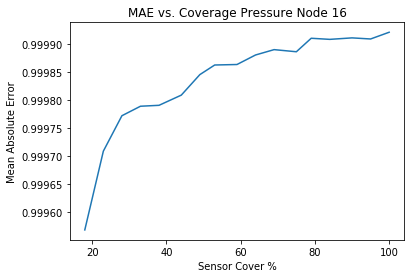

In [18]:
#run this after cell above finishes training 
plt.plot(sensors_covered, R2_average_16)
plt.ylabel("Mean Absolute Error")
plt.xlabel("Sensor Cover %")
plt.title("MAE vs. Coverage Pressure Node 16")
plt.show()

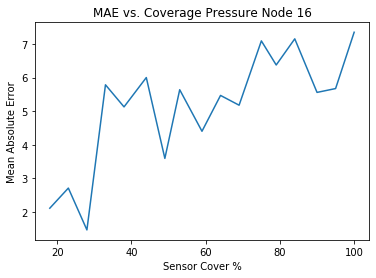

In [22]:
#run this after cell above finishes training 
plt.plot(sensors_covered, MAE_average_16)
plt.ylabel("Mean Absolute Error")
plt.xlabel("Sensor Cover %")
plt.title("MAE vs. Coverage Pressure Node 16")
plt.show()